# This Jupyter notebook does a chained fit of 2-point and 3-point 

In [20]:
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

In [21]:
import gvar as gv
import h5py
import lsqfit
import h5data_methods as h5_dm

In [22]:
import pickle

In [23]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
a = 0.12

# Pion mass
mpi = 0.1885
#mpi = 0.2

# Plot constants
t_min_plt = 1
t_max_plt = 25

# Array of tsep values
tsep_vals = np.arange(3,13,1)
tsep_vals

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [24]:
def Ei(n_selec, p):
    Ea = p['E0']
    for l in range(1, n_selec+1):
        Ea += p['dE{}'.format(l)]
        
    #print(Ea)
    return Ea

In [25]:
data = {}
data['2pt'] = h5_dm.get_2pt("a12m310_a_avg.h5")
data['2pt_SS'] = data['2pt'][:,:,0]
data['2pt_PS'] = data['2pt'][:,:,1]
data['3pt_A3_unsymm'] = h5_dm.get_3pt("a12m310_a_avg.h5", "A3", 3, 13)
data['3pt_V4_unsymm'] = h5_dm.get_3pt("a12m310_a_avg.h5", "V4", 3, 13)
data['FH_N_A3'] = h5_dm.get_FH("a12m310_a_fh.h5", "gA")
data['FH_N_V4'] = h5_dm.get_FH("a12m310_a_fh.h5", "gV")
data['FH_N'] = h5_dm.get_FH("a12m310_a_fh.h5", "all")

In [26]:
gv_avg_data = gv.BufferDict()
gv_avg_data = gv.dataset.avg_data(data)

# Symmetrize the 3-point data
gv_avg_data['3pt_A3'] = np.array([ [ (gv_avg_data['3pt_A3_unsymm'][i][j] + gv_avg_data['3pt_A3_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_A3_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_A3_unsymm']))]) 
gv_avg_data['3pt_V4'] = np.array([ [ (gv_avg_data['3pt_V4_unsymm'][i][j] + gv_avg_data['3pt_V4_unsymm'][i][i + tsep_vals[0] - j])/2. for j in range(len(gv_avg_data['3pt_V4_unsymm'][i]))] for i in range(len(gv_avg_data['3pt_V4_unsymm']))])

# Calculate the ratio between 3-point and 2-point data, for both A3 and V4
gv_avg_data['C_ratio_A3'] = np.array([ [gv_avg_data['3pt_A3'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_A3'] = np.array([np.sum(gv_avg_data['3pt_A3'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_A3'] = np.array([ (gv_avg_data['Csum_A3'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_A3'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

gv_avg_data['C_ratio_V4'] = np.array([ [gv_avg_data['3pt_V4'][i][j]/gv_avg_data['2pt_SS'][i+tsep_vals[0]] for j in range(1, i+3)] for i in range(len(tsep_vals))])
gv_avg_data['Csum_V4'] = np.array([np.sum(gv_avg_data['3pt_V4'][i][1:i+3]) for i in range(len(tsep_vals))])
gv_avg_data['C^FH_V4'] = np.array([ (gv_avg_data['Csum_V4'][i + 1]/gv_avg_data['2pt_SS'][i + tsep_vals[0] + 1]) - (gv_avg_data['Csum_V4'][i]/gv_avg_data['2pt_SS'][i + tsep_vals[0]]) for i in range(len(tsep_vals)-1)])

# The A3 and V4 3-point and sum-subtracted samples are combined into arrays of (A3, V4) pairs 
gv_avg_data['3pt_combined'] = np.array([ [ [gv_avg_data['3pt_A3'][i][j], gv_avg_data['3pt_V4'][i][j]] for j in range(len(gv_avg_data['3pt_A3'][i]))] for i in range(len(gv_avg_data['3pt_A3']))])
gv_avg_data['C^FH_combined'] = np.transpose(np.append([gv_avg_data['C^FH_A3'],], [gv_avg_data['C^FH_V4'],], axis = 0))

gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))

gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])
gv_avg_data['2pt_zPeff'] = np.array([np.exp(gv_avg_data['2pt_PS_meff'][t]*t)*gv_avg_data['2pt_PS'][t]/gv_avg_data['2pt_zSeff'][t] for t in range(63)])


# Sum-subtract the Feynman-Hellman raw data to get a FH dataset
gv_avg_data['2pt_D'] = np.transpose(np.array([gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS'], gv_avg_data['2pt_SS'], gv_avg_data['2pt_PS']]))
gv_avg_data['FH'] = np.roll(gv_avg_data['FH_N']/gv_avg_data['2pt_D'], -1, axis = 0) - gv_avg_data['FH_N']/gv_avg_data['2pt_D']


<ipython-input-26-d3c020a9eefb>:21: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_meff'] = np.log(np.array([gv_avg_data['2pt'][j,:]/gv_avg_data['2pt'][j+1,:] for j in range(63)]))
<ipython-input-26-d3c020a9eefb>:22: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_SS_meff'] = np.log(np.array([gv_avg_data['2pt_SS'][j]/gv_avg_data['2pt_SS'][j+1] for j in range(63)]))
<ipython-input-26-d3c020a9eefb>:23: RuntimeWarning: invalid value encountered in log
  gv_avg_data['2pt_PS_meff'] = np.log(np.array([gv_avg_data['2pt_PS'][j]/gv_avg_data['2pt_PS'][j+1] for j in range(63)]))
<ipython-input-26-d3c020a9eefb>:25: RuntimeWarning: invalid value encountered in sqrt
  gv_avg_data['2pt_zSeff'] = np.array([np.sqrt(np.exp(gv_avg_data['2pt_SS_meff'][t]*t)*gv_avg_data['2pt_SS'][t]) for t in range(63)])


### Define functions

In [27]:
def param_FH(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
            if n >= m:
                sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
                sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    return sub_p

def param_FHdata(p):
    sub_p = gv.BufferDict()
    sub_p['E0'] = p['E0']
    sub_p['Z0'] = p['Z0']
    sub_p['Ztilde0'] = p['Ztilde0']
    
    for k in range(1, num_states_FH - 1):
        sub_p['Z{}'.format(k)] = p['Z{}'.format(k)]
        sub_p['Ztilde{}'.format(k)] = p['Ztilde{}'.format(k)]
        sub_p['log(dE{})'.format(k)] = p['log(dE{})'.format(k)]
        
    sub_p['Z{}'.format(num_states_FH - 1)] = p['Z_FHmax']
    sub_p['Ztilde{}'.format(num_states_FH - 1)] = p['Ztilde_FHmax']
    sub_p['log(dE{})'.format(num_states_FH - 1)] = p['log(FH_dEmax)']
    
    for n in range(num_states_FH-1):
        for m in range(num_states_FH-1):
            if n >= m:    
                sub_p['gA3_{0}{1}'.format(n, m)] = p['gA3_{0}{1}'.format(n, m)]
                sub_p['gV4_{0}{1}'.format(n, m)] = p['gV4_{0}{1}'.format(n, m)]
            
    for n in range(num_states_FH-1):
        #sub_p['gA3_{0}{1}'.format(n, num_states_FH-1)] = p['gA3_{}FHmax'.format(n)]
        sub_p['gA3_{0}{1}'.format(num_states_FH-1, n)] = p['gA3_FHmax{}'.format(n)]
        #sub_p['gV4_{0}{1}'.format(n, num_states_FH-1)] = p['gV4_{}FHmax'.format(n)]
        sub_p['gV4_{0}{1}'.format(num_states_FH-1, n)] = p['gV4_FHmax{}'.format(n)]
        
    sub_p['gA3_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gA3_FHmaxFHmax']
    sub_p['gV4_{0}{1}'.format(num_states_FH-1, num_states_FH-1)] = p['gV4_FHmaxFHmax']
    
    for n in range(num_states_FH):
        sub_p['d_gA_ss_{}'.format(n)] = p['d_gA_ss_{}'.format(n)]
        sub_p['d_gA_ps_{}'.format(n)] = p['d_gA_ps_{}'.format(n)]
        sub_p['d_gV_ss_{}'.format(n)] = p['d_gV_ss_{}'.format(n)]
        sub_p['d_gV_ps_{}'.format(n)] = p['d_gV_ps_{}'.format(n)]
    
    return sub_p

In [28]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

def C_2pt_SS(t, p):
    
    z = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ss)

def C_2pt_PS(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    #print("z: ", z)
    #print("ztilde: ", ztilde)
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.array(sum_ps)

In [29]:
# Precondition: t is a 1-D numpy array of 2-element array like objects t[i] = (t_sep, tau)
  
    
def C_3pt_A3(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gA3_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:    
        En = Ei(n, p)
        Em = Ei(m, p) 
        #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        if m > n:
            result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        else:
            result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
            
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gA3_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result



def C_3pt_V4(t, p):
    #tsep = np.array([np.array([t[i][j][0] for j in range(len(t[i]))]) for i in range(len(t))])
    #tau = np.array([np.array([t[i][j][1] for j in range(len(t[i]))]) for i in range(len(t))])
    tsep, tau = np.transpose(t)
    #print("tsep: ", tsep)
    #print("tau: ", tau)
    
    result = p['Z0']*p['gV4_00']*p['Z0']*np.exp(-p["E0"]*tsep)*np.exp(-(p["E0"] - p["E0"])*tau)
    
    n = 0
    m = 0
    if num_zs == 1:
        return result
    
    m += 1
    while n < num_zs:
        En = Ei(n, p)
        Em = Ei(m, p)
        #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        if m > n:
            result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
        else:
            result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-En*tsep)*np.exp(-(Em - En)*tau)
            
        m += 1
        if m >= num_zs:
            m = 0
            n += 1
    
    
    #for n in range(num_zs):
        #for m in range(num_zs):
            #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*np.exp(-p["E{}".format(n)]*tsep)*np.exp(-(p["E{}".format(m)] - p["E{}".format(n)])*tau)
            # print out the dictionary indices which are called in this summation
            #print("n = ", n, "; m = ", m)
            #print('Z{}'.format(n), "*", 'gV4_{0}{1}'.format(n, m), "*", 'Z{}'.format(m), "*e^(-tsep*", "E{}".format(n), ")*e^(-tau*(", "E{}".format(m), "-", "E{}".format(n), ")")
            
    return result

def C_3pt(t, p):
    A3 = C_3pt_A3(t, p)
    V4 = C_3pt_V4(t, p)
    
    return np.transpose(np.array([[A3], [V4]]), axes=[2,0,1])

In [30]:
num_states_FH = 1 # The number of states that the Feynman-Hellman and sum-subtraction needs

def C_2pt_SS_aux(t, p, n_local):
    
    z = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        E = np.append(E, Ei(i, p))
        
    
    sum_ss = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ss)

def C_2pt_PS_aux(t, p, n_local):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(n_local):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, Ei(i, p))
    
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(n_local)])
    
    return np.array(sum_ps)

def Csum_A3(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                if m > n:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += (t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)]*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                if m > n:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def C_FH_A3(t, p):
    
    return (Csum_A3(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_A3(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH_V4(t, p):
    
    return (Csum_V4(t + 1, param_FH(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FH(p), num_states_FH)) - (Csum_V4(t, param_FH(p), num_states_FH)/C_2pt_SS_aux(t, param_FH(p), num_states_FH))


def C_FH(t, p):
    return np.transpose(np.array([C_FH_A3(t, p), C_FH_V4(t, p)])) #, axes=[2,0,1]

In [31]:
#num_states_FHdata = 1
# Create new functions to fit the new Feynman-Hellman dataset to 
def Csum_A3_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gA_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_A3_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gA_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(m, n)]*p['Ztilde{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gA3_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ss(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Z{}'.format(n)] + p['d_gV_ss_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Z{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Z{}'.format(m)]*mn_ratio
                
    return result

def Csum_V4_FHdata_ps(t, p, n_local):
    result = 0
    for n in range(n_local):
        En = Ei(n, p)
        result += ((t - 1) * p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, n)]*p['Ztilde{}'.format(n)] + p['d_gV_ps_{}'.format(n)])*np.exp(-En*t)
        for m in range(n_local):
            if n == m:
                continue
            else:
                Em = Ei(m, p)
                e_Delta_nm = np.exp((En - Em)/2.)
                e_Delta_mn = np.exp((Em - En)/2.)
                
                mn_ratio = (e_Delta_nm*np.exp(-En*t) - e_Delta_mn*np.exp(-Em*t))/(e_Delta_mn - e_Delta_nm)
                
                #result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                if m > n:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(m, n)]*p['Ztilde{}'.format(m)]*mn_ratio
                else:
                    result += p['Z{}'.format(n)]*p['gV4_{0}{1}'.format(n, m)]*p['Ztilde{}'.format(m)]*mn_ratio
                
    return result


def C_FHdata_A3_ss(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_A3_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_A3_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_A3_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_A3_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_A3_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))


def C_FHdata_V4_ss(t, p):  
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ss(t + 1, p, num_states_FH)/C_2pt_SS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ss(t, p, num_states_FH)/C_2pt_SS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ss(t + 1, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ss(t, param_FHdata(p), num_states_FH)/C_2pt_SS_aux(t, param_FHdata(p), num_states_FH))

def C_FHdata_V4_ps(t, p):
    if(num_zs == num_states_FH):
        return (Csum_V4_FHdata_ps(t + 1, p, num_states_FH)/C_2pt_PS_aux(t + 1, p, num_states_FH)) - (Csum_V4_FHdata_ps(t, p, num_states_FH)/C_2pt_PS_aux(t, p, num_states_FH))

    else:
        return (Csum_V4_FHdata_ps(t + 1, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t + 1, param_FHdata(p), num_states_FH)) - (Csum_V4_FHdata_ps(t, param_FHdata(p), num_states_FH)/C_2pt_PS_aux(t, param_FHdata(p), num_states_FH))



def C_FHdata(t, p):
    return np.transpose(np.array([C_FHdata_A3_ss(t, p), C_FHdata_A3_ps(t, p), C_FHdata_V4_ss(t, p), C_FHdata_V4_ps(t, p)])) #,

In [95]:
# Gets a single 2-element, passes it to C_2pt if it's of the form [None, tau], C_3pt if it's of the form [tsep, tau], C_FH if it's of the form [tsep, None]
def single_choice(t_sel, p):
    if t_sel[0] is None:
        return C_2pt(np.array([t_sel[1]]), p)
    
    else:
        if t_sel[1] is None:
            FH_t_sel_res = C_FH(np.array([t_sel[0]]), p)
            return np.array([[[FH_t_sel_res[0][0]], [FH_t_sel_res[0][1]]]])
        
        else:
            return np.array([C_3pt(np.array([[t_sel[0], t_sel[1]]]), p)])[0]
        
def all_at_once(t, p):
    
    #if np.shape(t) == (2,):
        #return single_choice(t, p)
    
    #else:
        #for t_sel in t:
            #print("Shape of t_sel: ", np.shape(t_sel))
    return [single_choice(t_sel, p)[0] for t_sel in t]
    #t_2pt = t[0]
    #t_3pt = t[1]
    #t_CFH = t[2]
    #return np.array([C_2pt_SS(t_2pt, p), C_2pt_PS(t_2pt, p), C_3pt_A3(t_3pt, p), C_3pt_V4(t_3pt, p), C_FH_A3(t_CFH, p), C_FH_V4(t_CFH, p)]) #np.transpose(
    
# Like all_at_once, but uses dictionaries
def all_at_once_dict(t, p):
    out = gv.BufferDict()
    if '2pt' in t.keys():
        out['2pt'] = C_2pt(t['2pt'], p)
    if '3pt' in t.keys():
        out['3pt'] = C_3pt(t['3pt'], p)
    if 'sum_sub' in t.keys():
        out['C^FH_combined'] = C_FH(t['sum_sub'], p)
    if 'FH' in t.keys():
        out['FH'] = C_FHdata(t['FH'], p)
    
    return out

In [32]:
# In order to be able to work with our 2-d array based functions, we need a way to convert from 2-d array to 1-d arrays and from 1-d arrays to 2-d arrays
# For the independent (time) variable, I'd just set up a 2-d array and a 1-d array with all the data I need
# For the dependent (correlation function) variable, I'd use the time variable arrays to call the correct indices to assign the variables in the conversion
t_2d_array = np.array([np.array([(i+3, j) for j in range(1, i+tsep_vals[0])]) for i in range(len(tsep_vals))])

num_elements = np.sum(np.array([i+tsep_vals[0]-1 for i in range(len(tsep_vals))]))
tsep_t = np.zeros(num_elements)
tau_t = np.zeros(num_elements)

k = 0
for i in range(len(tsep_vals)):
    for j in range(1, i+tsep_vals[0]):
        tsep_t[k] = i + tsep_vals[0]
        tau_t[k] = j
        #print("k = ", k, " tsep = ", tsep_t[k], " tau = ", tau_t[k])
        k += 1

        
t_1d_array = np.transpose(np.array([tsep_t, tau_t])) 

#print(t_2d_array)
#print(t_1d_array)

# Universal precondition for the below functions: x_1d, x_2d, y_1d, and y_2d, in the end, must have the 
# same number of elements. Also, x_1d and y_1d have to have the same dimensions, as must x_2d and y_2d
def convert_1dto2d(x_1d, x_2d, y_1d):
    y_2d = np.array([np.array([None for j in range(len(x_2d[i]))]) for i in range(len(x_2d))])
    i = 0
    j = 0
    for k in range(len(x_1d)):
        y_2d[i][j] = y_1d[k]
        j += 1
        if j >= len(x_2d[i]):
            i +=1
            j = 0
            
    return y_2d

def convert_2dto1d(x_1d, x_2d, y_2d):
    y_1d = np.array([None for k in range(len(x_1d))])
    k = 0
    for i in range(len(x_2d)):
        for j in range(len(x_2d[i])):
            y_1d[k] = y_2d[i][j]
            k += 1
    
    return y_1d
    

In [33]:
# Now try chain-fitting 2pt and 3-point
num_zs = 7
num_states_FH = 2

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit
#tp['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
#tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #tp['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
    #tp['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
    #tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    #tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
#tp['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
#tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

0


In [34]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [35]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])


fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_2pt, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3898.1

Parameters:
             E0       0.662108 +- 0.00386966             [     0.659347 +- 0.00482406 ]  
             Z0   0.000758527 +- 1.69852e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00285896 +- 7.40974e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.22767 +- 0.269401             [       -1.07435 +- 0.453575 ]  
             Z1    0.00033617 +- 0.000119165             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1    0.00218387 +- 0.000966233             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.29311 +- 0.273051             [      -0.732238 +- 0.442562 ]  *
             Z2    0.00061672 +- 0.000187106             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00332786 +- 0.00188838             [     0.0064959 +- 0.0026369 ]  *
       log(dE3)        -0.605473 +- 0.428751             [      -0.853576 +- 0.645681 ]  
         

In [36]:
current_posterior = open('chained_2pt_3pt_Final.obj', 'wb')
pickle.dump(post_3pt, current_posterior)
current_posterior.close()

In [39]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

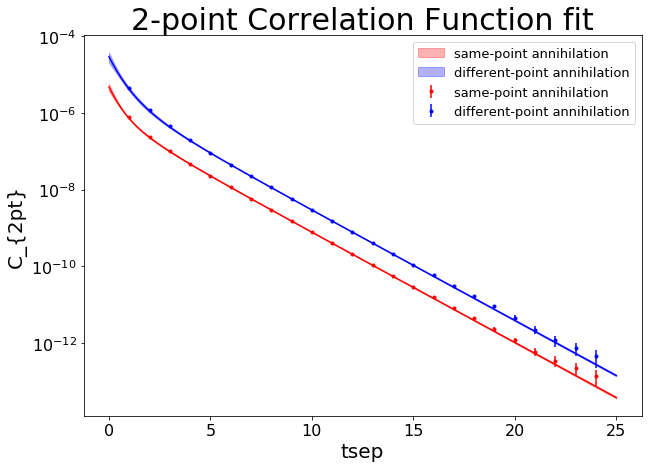

<Figure size 432x288 with 0 Axes>

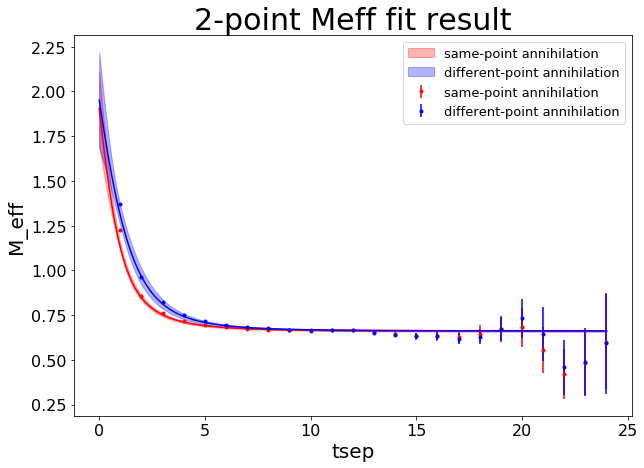

<Figure size 432x288 with 0 Axes>

In [40]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

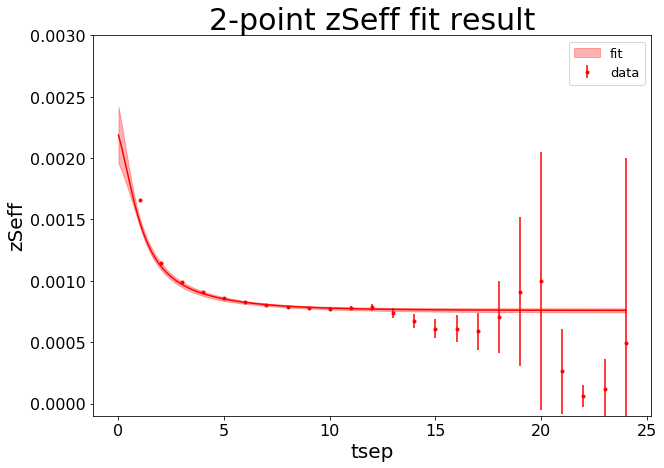

<Figure size 432x288 with 0 Axes>

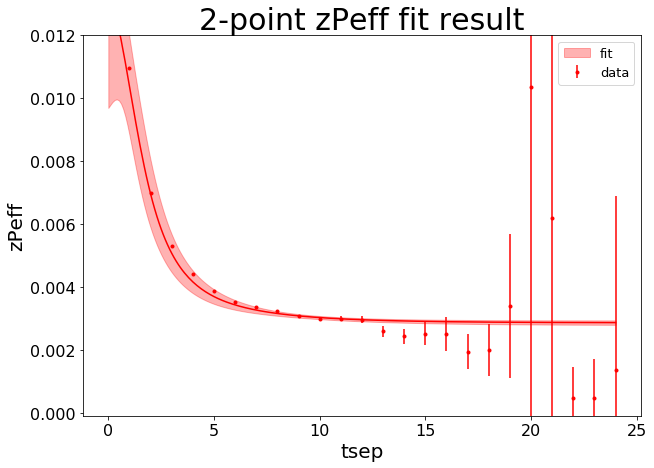

<Figure size 432x288 with 0 Axes>

In [43]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [44]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

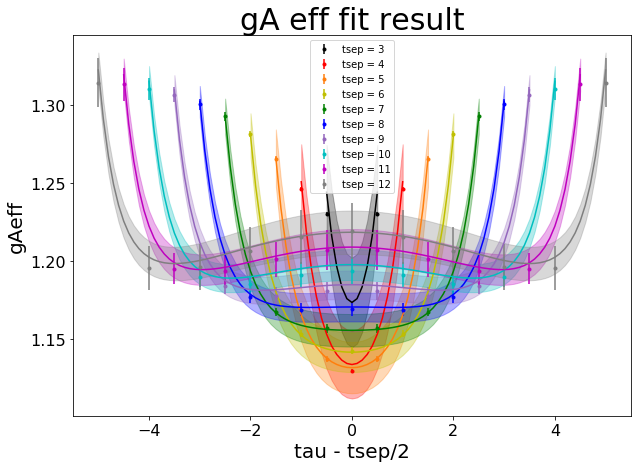

<Figure size 432x288 with 0 Axes>

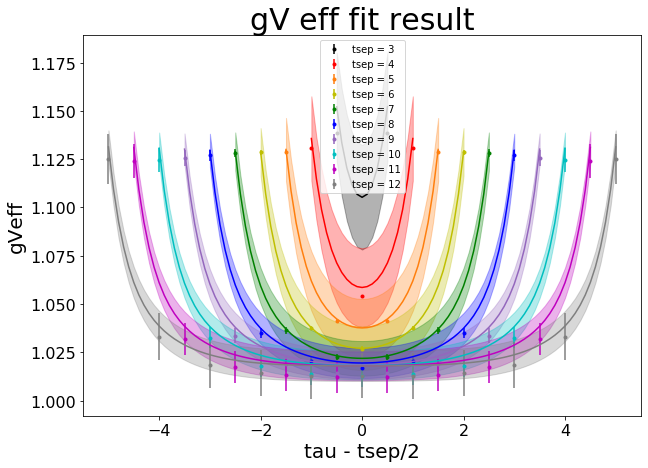

<Figure size 432x288 with 0 Axes>

In [45]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try completing the chain with a 3-point fit with tau cut off of 2

In [46]:
# Create a new set of priors
# Now try chain-fitting 2pt and 3-point
num_zs = 4
num_states_FH = 3

# prior the fits
tp = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#prior_2ptstep['E1'] = gv.gvar(1.3, 0.23)
#prior_2ptstep['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#prior_2ptstep['Z1'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = prior_2ptstep['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

1


In [47]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [48]:

tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_2pt, fcn = C_3pt,debug=True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.5

Parameters:
             E0        0.66084 +- 0.00266371             [     0.661027 +- 0.00280207 ]  
             Z0   0.000755625 +- 9.78603e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00285221 +- 4.3886e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.861442 +- 0.107274             [        -0.8113 +- 0.135657 ]  
             Z1   0.000617033 +- 6.89243e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00415219 +- 0.000569303             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.826668 +- 0.323165             [      -0.516866 +- 0.438609 ]  
             Z2   0.000558668 +- 0.000309334             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00411444 +- 0.00242404             [     0.0059393 +- 0.0030705 ]  
       log(dE3)        -0.486448 +- 0.427236             [       -0.526875 +- 0.58489 ]  
            

In [49]:
current_posterior = open('chained_2pt_3pt_tau2_Final.obj', 'wb')
pickle.dump(post_3pt_tau2, current_posterior)
current_posterior.close()

In [50]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

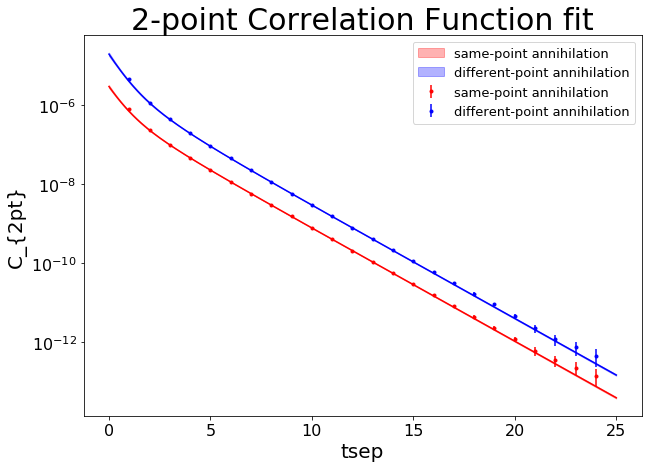

<Figure size 432x288 with 0 Axes>

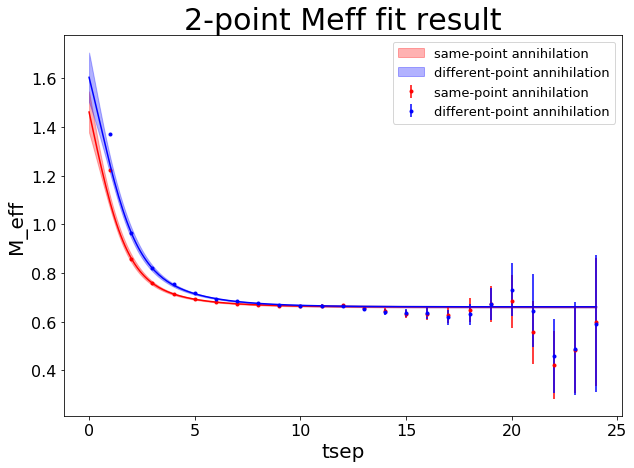

<Figure size 432x288 with 0 Axes>

In [51]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

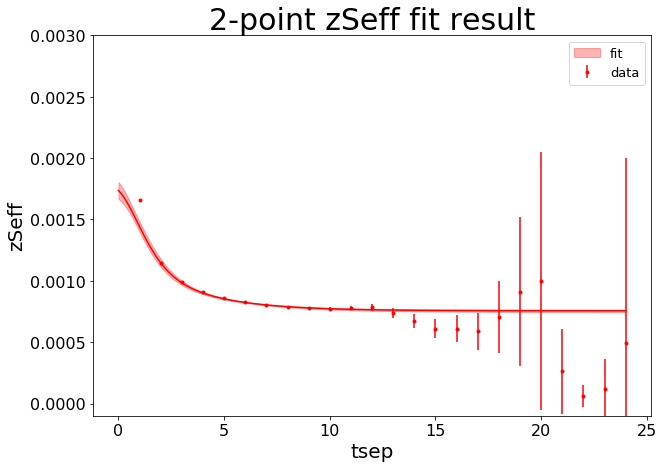

<Figure size 432x288 with 0 Axes>

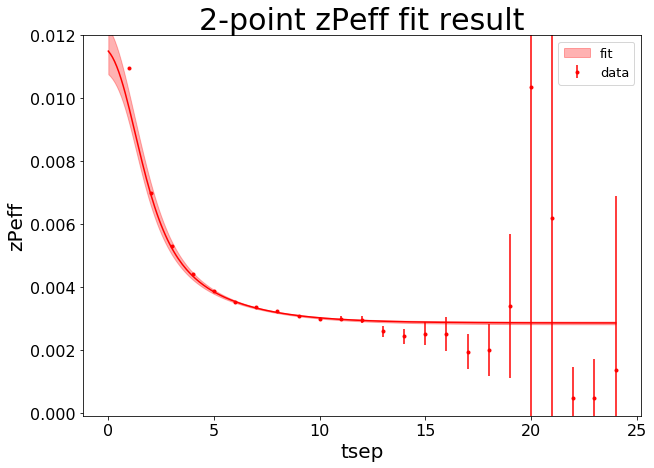

<Figure size 432x288 with 0 Axes>

In [52]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

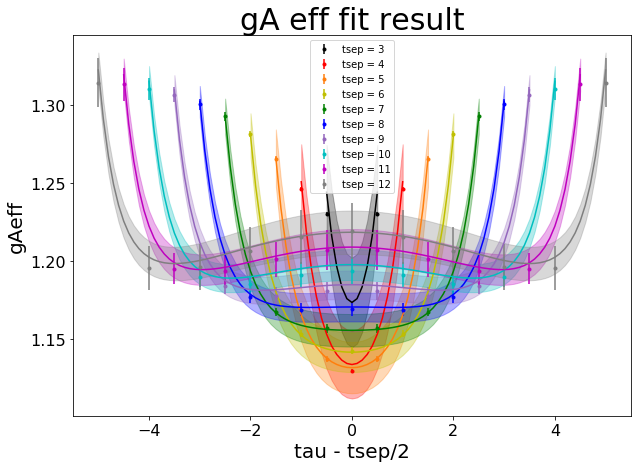

<Figure size 432x288 with 0 Axes>

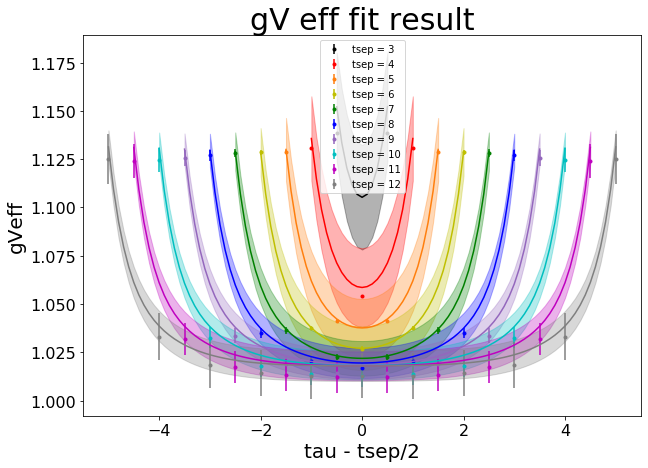

<Figure size 432x288 with 0 Axes>

In [53]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try the same, but with an insertion of Feynman-Hellman

In [54]:
# Now try chain-fitting 2pt and 3-point
num_zs = 7
num_states_FH = 2

# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#tp['E1'] = gv.gvar(1.3, 0.23)
#tp['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#tp['Z1'] = gv.gvar(0.0012, 0.0006)
#tp['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = tp['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    tp["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
tp['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
tp['Ztilde_FHmax'] = gv.gvar(0, 0.01)
tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    tp['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
tp['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



#prior_2ptstep

0


In [55]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.9 [22]    Q = 0.59    logGBF = 483.09

Parameters:
             E0       0.659347 +- 0.00482406             [     0.67 +- 0.02 ]  
             Z0   0.000748018 +- 2.26286e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0    0.00281834 +- 0.000100562             [   0.003 +- 0.003 ]  
       log(dE1)         -1.07435 +- 0.453575             [  -0.97551 +- 0.7 ]  
             Z1   0.000518164 +- 0.000197072             [ 0.0012 +- 0.0006 ]  *
        Ztilde1     0.00318134 +- 0.00168234             [        0 +- 0.01 ]  
       log(dE2)        -0.732238 +- 0.442562             [  -0.97551 +- 0.7 ]  
             Z2   0.000778871 +- 0.000287095             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0064959 +- 0.0026369             [        0 +- 0.01 ]  
       log(dE3)        -0.853576 +- 0.645681             [  -0.97551 +- 0.7 ]  
             Z3   0.000712665 +- 0.000420096             [ 0.0012 +- 0.0006 ]  
        Ztilde3     0.0030271

In [56]:
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_2pt,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.82 [36]    Q = 0.77    logGBF = 134.96

Parameters:
             E0        0.659949 +- 0.00435922             [     0.659347 +- 0.00482406 ]  
             Z0    0.000750701 +- 2.06845e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0     0.00283144 +- 9.17314e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.04455 +- 0.433894             [       -1.07435 +- 0.453575 ]  
             Z1     0.00052056 +- 0.000192475             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1      0.00320739 +- 0.00163523             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -0.781353 +- 0.438272             [      -0.732238 +- 0.442562 ]  
             Z2     0.000736948 +- 0.00028496             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2      0.00645812 +- 0.00260838             [     0.0064959 +- 0.0026369 ]  
       log(dE3)         -0.893886 +- 0.644406             [      -0.853576 +- 0.645681 ]  

In [57]:
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])


fit_3pt = lsqfit.nonlinear_fit(data=(t_1d_array, y_3pt), prior=post_FHdata, fcn = C_3pt, debug = True)
print(fit_3pt.format(pstyle='vv'))
post_3pt = fit_3pt.p

Least Square Fit:
  chi2/dof [dof] = 0.31 [130]    Q = 1    logGBF = 3900.6

Parameters:
             E0        0.661638 +- 0.00351959             [      0.659949 +- 0.00435922 ]  
             Z0    0.000756271 +- 1.56915e-05             [  0.000750701 +- 2.06845e-05 ]  
        Ztilde0     0.00284931 +- 6.84249e-05             [   0.00283144 +- 9.17314e-05 ]  
       log(dE1)          -1.28433 +- 0.250496             [        -1.04455 +- 0.433894 ]  
             Z1    0.000313831 +- 0.000104195             [   0.00052056 +- 0.000192475 ]  *
        Ztilde1     0.00195004 +- 0.000895544             [    0.00320739 +- 0.00163523 ]  
       log(dE2)           -1.3258 +- 0.249902             [       -0.781353 +- 0.438272 ]  *
             Z2    0.000605733 +- 0.000169241             [   0.000736948 +- 0.00028496 ]  
        Ztilde2      0.00340676 +- 0.00175877             [    0.00645812 +- 0.00260838 ]  *
       log(dE3)         -0.500117 +- 0.326248             [       -0.893886 +- 0

In [58]:
current_posterior = open('chained_2pt_3pt_withFH_Final.obj', 'wb')
pickle.dump(post_3pt, current_posterior)
current_posterior.close()

In [59]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

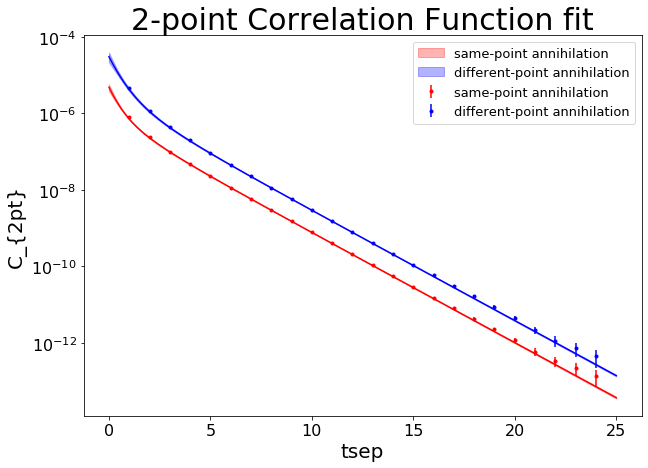

<Figure size 432x288 with 0 Axes>

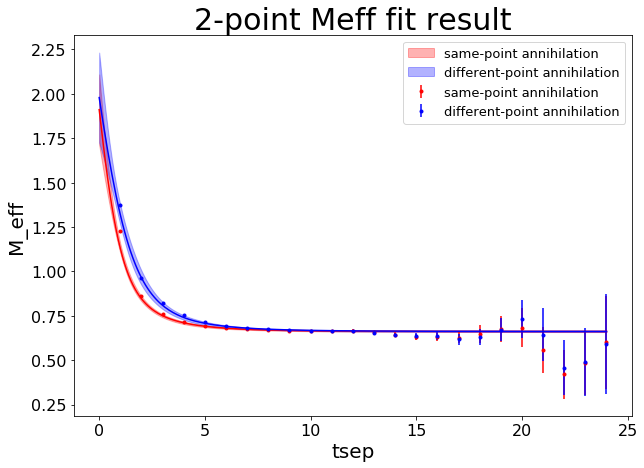

<Figure size 432x288 with 0 Axes>

In [60]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

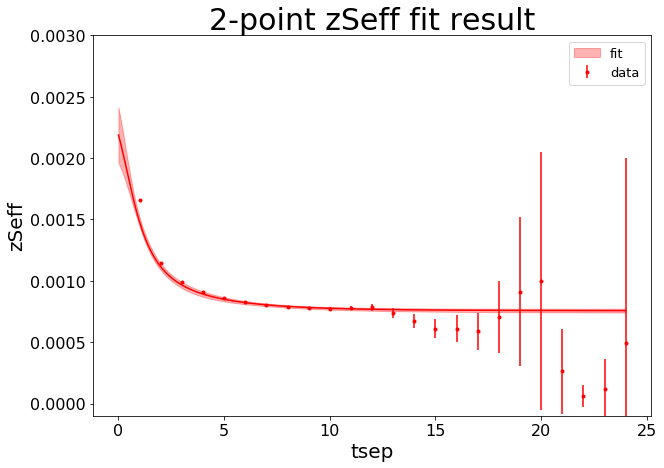

<Figure size 432x288 with 0 Axes>

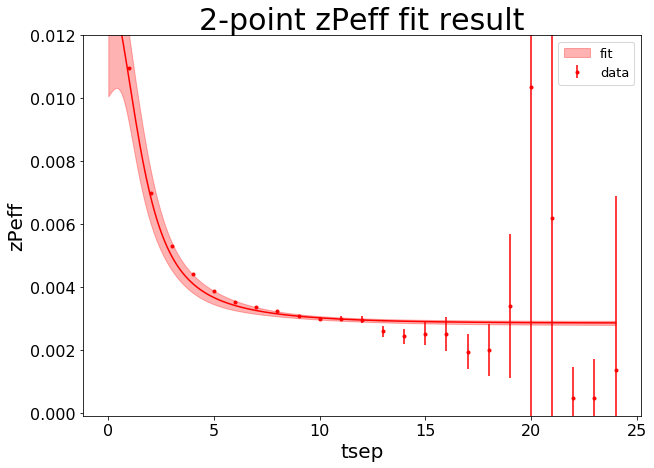

<Figure size 432x288 with 0 Axes>

In [61]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

In [62]:
# Now, plot out the 3-point function
# First, create the x, y, and z values
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

legendlabels_3pt = np.array(["tsep = {}".format(i) for i in tsep_vals])

# set the array of tsep, tau pairs
tau_step = 10

# Create 2-d and 1-d versions of the 3-point (tsep, tau) pairs
t_3pt_fitresult_2d = np.array([ np.array([ [tsep, tau] for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])
t_3pt_fitresult_tsep = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))
t_3pt_fitresult_tau = np.zeros(np.sum(np.array([len(np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)) for tsep in tsep_vals])))

k = 0
for tsep in tsep_vals:
    for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1):
        t_3pt_fitresult_tsep[k] = tsep
        t_3pt_fitresult_tau[k] = tau
        k += 1
        
t_3pt_fitresult_1d = np.transpose(np.array([t_3pt_fitresult_tsep, t_3pt_fitresult_tau]))

# Now, calculate gA3 and gA4

model_A3_3pt_1d = C_3pt_A3(t_3pt_fitresult_1d, post_3pt)
model_V4_3pt_1d = C_3pt_V4(t_3pt_fitresult_1d, post_3pt)

# Convert to 2d
model_A3_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_A3_3pt_1d)
model_V4_3pt_2d = convert_1dto2d(t_3pt_fitresult_1d, t_3pt_fitresult_2d, model_V4_3pt_1d)

# Now, take the ratio, first take the respective 2-point function

model_ratio_2pt = C_2pt_SS(tsep_vals, post_3pt)

model_A3_ratio_2d = np.array([ np.array([ model_A3_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_A3_3pt_2d[i]))]) for i in range(len(model_A3_3pt_2d))])
model_V4_ratio_2d = np.array([ np.array([ model_V4_3pt_2d[i][j]/model_ratio_2pt[i] for j in range(len(model_V4_3pt_2d[i]))]) for i in range(len(model_V4_3pt_2d))])

# Now, to prepare for plotting, split the data into mean, upper-bound and lower-bound
model_A3_ratio_2d_mean = np.array([ [ model_A3_ratio_2d[i][j].mean for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_upbound = np.array([ [ model_A3_ratio_2d[i][j].mean + model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])
model_A3_ratio_2d_lowbound = np.array([ [ model_A3_ratio_2d[i][j].mean - model_A3_ratio_2d[i][j].sdev for j in range(len(model_A3_ratio_2d[i]))] for i in range(len(model_A3_ratio_2d)) ])

model_V4_ratio_2d_mean = np.array([ [ model_V4_ratio_2d[i][j].mean for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_upbound = np.array([ [ model_V4_ratio_2d[i][j].mean + model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])
model_V4_ratio_2d_lowbound = np.array([ [ model_V4_ratio_2d[i][j].mean - model_V4_ratio_2d[i][j].sdev for j in range(len(model_V4_ratio_2d[i]))] for i in range(len(model_V4_ratio_2d)) ])

# Also, convert the 2-d tsep, tau array into an array of tau - tsep/2
t_3pt_tseptau_diff = np.array([ np.array([tau - tsep/2. for tau in np.linspace(1, tsep - 1, (tsep - 2)*step_up +1)]) for tsep in tsep_vals])

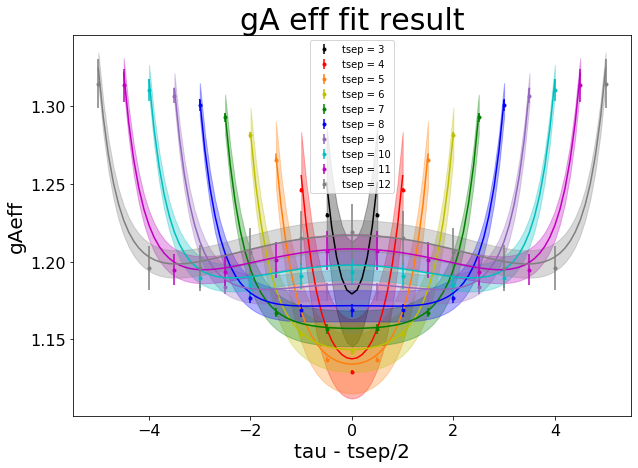

<Figure size 432x288 with 0 Axes>

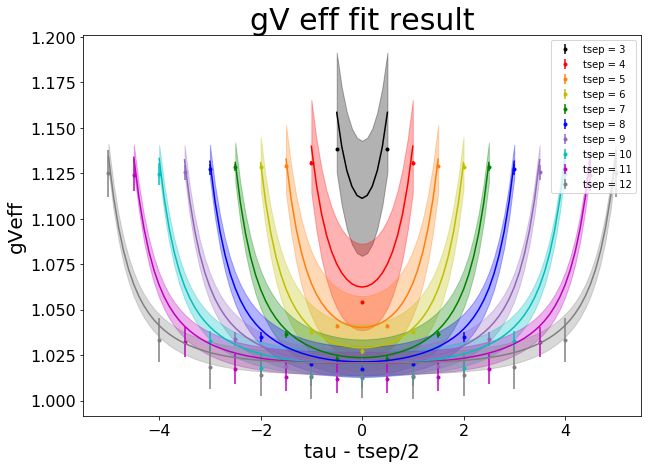

<Figure size 432x288 with 0 Axes>

In [63]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, try completing the chain with a 3-point fit with tau cut off of 2

In [64]:
# Create a new set of priors
# Now try chain-fitting 2pt and 3-point
num_zs = 4
num_states_FH = 3


# prior the fits
prior_2ptstep = gv.BufferDict()

# This is the exponent e_decay_exp such that the increment between two consecutive excited state energies decays as 1/n^e_decay_exp, where n is the order of the excited state energy 
e_decay_exp = 0

tp['E0'] = gv.gvar(0.67, 0.02)
tp['Z0'] = gv.gvar(0.0008, 0.0003)
tp['Ztilde0'] = gv.gvar(0.003, 0.003)

#tp['E1'] = gv.gvar(1.3, 0.23)
#tp['log(E1)'] = gv.gvar(np.log(1.3), np.log(1.3/(1.3 - 0.3)))
#tp['Z1'] = gv.gvar(0.0012, 0.0006)
#tp['Ztilde1'] = gv.gvar(0.006, 0.005)

# Define some constants for prioring the higher-order energies
dE0 = 2*mpi
b = 0.7

# Use constant dE to prior the energies
dE0 = 2*mpi
energyvals = np.array([None]*num_zs)
dEvals = np.array([None]*(num_zs - 1))

#E0_errbar = 0.8
energyvals[0] = gv.gvar(0.67, 0.02)
for k in range(1, num_zs):
    dEvals[k-1] = dE0/np.power(k, e_decay_exp)
    energyvals[k] = energyvals[k-1] + dEvals[k-1]

for n in range(1, num_zs):
    tp['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), b)
    tp['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
    tp['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)
    
    # Insert priors for energy here
    #dE_next = dE0/np.power(n, e_decay_exp)
    #E_next = tp['E{}'.format(n-1)].mean + dE_next
    #sigma_next = np.log(E_next/(E_next - (dE_next*b)))

print(num_states_FH - 2)

for n in range(num_zs):
    tp["d_gA_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gA_ps_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ss_{}".format(n)] = gv.gvar(0,0.00001)
    tp["d_gV_ps_{}".format(n)] = gv.gvar(0,0.00001)
    for m in range(num_zs):
        
        tp['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
        if n == m and n < num_zs-1:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
        else:
            tp['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

tp['gA3_00'] = gv.gvar(1.25, 0.15)
tp['gV4_00'] = gv.gvar(1.07, 0.07)

# Set the "garbage can" for the Feynman Hellman fit, post-Lattice-QCD stage
tp['Z_FHmax'] = gv.gvar(0.0012, 0.0006)
tp['Ztilde_FHmax'] = gv.gvar(0, 0.01)
tp['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

for n in range(num_states_FH-1):
    tp['gA3_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gA3_{}FHmax'.format(n)] = gv.gvar(0, 2)
    tp['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
    tp['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
tp['gA3_FHmaxFHmax'] = gv.gvar(0, 2)
tp['gV4_FHmaxFHmax'] = gv.gvar(0, 2)

# Set the "garbage can" for the Feynman Hellman fit, Lattice-QCD stage
#prior_2ptstep['Z_FHdatamax'] = gv.gvar(0.0012, 0.0006)
#prior_2ptstep['Ztilde_FHdatamax'] = gv.gvar(0, 0.01)
#prior_2ptstep['log(FHdata_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b) 

#for n in range(num_states_FH-1):
    #prior_2ptstep['gA3_FHdatamax{}'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gA3_{}FHdatamax'.format(n)] = gv.gvar(1, 2)
    #prior_2ptstep['gV4_FHdatamax{}'.format(n)] = gv.gvar(0, 2)
    #prior_2ptstep['gV4_{}FHdatamax'.format(n)] = gv.gvar(0, 2)
    
#prior_2ptstep['gA3_FHdatamaxFHdatamax'] = gv.gvar(1, 2)
#prior_2ptstep['gV4_FHdatamaxFHdatamax'] = gv.gvar(0, 2)



#prior_2ptstep

1


In [65]:
# 2-point fit
fit_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=tp,fcn=C_2pt,debug=True)
print(fit_2pt.format(pstyle='vv'))
post_2pt = fit_2pt.p

Least Square Fit:
  chi2/dof [dof] = 0.85 [22]    Q = 0.67    logGBF = 484.64

Parameters:
             E0       0.661027 +- 0.00280207             [     0.67 +- 0.02 ]  
             Z0   0.000756981 +- 1.03675e-05             [ 0.0008 +- 0.0003 ]  
        Ztilde0     0.00286124 +- 4.6968e-05             [   0.003 +- 0.003 ]  
       log(dE1)          -0.8113 +- 0.135657             [  -0.97551 +- 0.7 ]  
             Z1   0.000662449 +- 9.46282e-05             [ 0.0012 +- 0.0006 ]  
        Ztilde1    0.00448214 +- 0.000764342             [        0 +- 0.01 ]  
       log(dE2)        -0.516866 +- 0.438609             [  -0.97551 +- 0.7 ]  
             Z2    0.000799852 +- 0.00040447             [ 0.0012 +- 0.0006 ]  
        Ztilde2       0.0059393 +- 0.0030705             [        0 +- 0.01 ]  
       log(dE3)         -0.526875 +- 0.58489             [  -0.97551 +- 0.7 ]  
             Z3    0.00118014 +- 0.000236461             [ 0.0012 +- 0.0006 ]  
        Ztilde3      0.008748

In [66]:
fit_FHdata = lsqfit.nonlinear_fit(data=(np.array([l for l in tsep_vals[:-1]]), np.array([gv_avg_data['FH'][l] for l in range(np.min(tsep_vals), np.max(tsep_vals))])), prior=post_2pt,fcn=C_FHdata, debug=True)
print(fit_FHdata.format(pstyle='vv'))
post_FHdata = fit_FHdata.p

Least Square Fit:
  chi2/dof [dof] = 0.75 [36]    Q = 0.86    logGBF = 117.84

Parameters:
             E0        0.661559 +- 0.00269517             [     0.661027 +- 0.00280207 ]  
             Z0    0.000759512 +- 9.93649e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00287295 +- 4.46866e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)         -0.775663 +- 0.128287             [        -0.8113 +- 0.135657 ]  
             Z1    0.000674832 +- 9.17004e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1      0.00465417 +- 0.00073394             [  0.00448214 +- 0.000764342 ]  
       log(dE2)         -0.518692 +- 0.437567             [      -0.516866 +- 0.438609 ]  
             Z2     0.00079792 +- 0.000404163             [  0.000799852 +- 0.00040447 ]  
        Ztilde2      0.00566132 +- 0.00306323             [     0.0059393 +- 0.0030705 ]  
       log(dE3)         -0.532217 +- 0.581156             [       -0.526875 +- 0.58489 ]  

In [67]:

tau_cut_val = 2
y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

# Create the dataset to be fit
x_1darray_tau2 = []
y_3pt_tau2 = []

    
for k in range(len(t_1d_array)):
    if(t_1d_array[k][0] >= 4):
        if(t_1d_array[k][1] >= tau_cut_val):
            if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cut_val):
                x_1darray_tau2.append(t_1d_array[k].tolist())
                y_3pt_tau2.append(y_3pt[k].tolist())
                            
x_1darray_tau2 = np.array(x_1darray_tau2)
y_3pt_tau2 = np.array(y_3pt_tau2)

fit_3pt_tau2 = lsqfit.nonlinear_fit(data=(x_1darray_tau2, y_3pt_tau2), prior=post_FHdata, fcn = C_3pt,debug=True)
print(fit_3pt_tau2.format(pstyle='vv'))
post_3pt_tau2 = fit_3pt_tau2.p

Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2730.6

Parameters:
             E0        0.661296 +- 0.00254279             [      0.661559 +- 0.00269517 ]  
             Z0    0.000757793 +- 9.23858e-06             [  0.000759512 +- 9.93649e-06 ]  
        Ztilde0     0.00286198 +- 4.09142e-05             [   0.00287295 +- 4.46866e-05 ]  
       log(dE1)        -0.841095 +- 0.0907562             [       -0.775663 +- 0.128287 ]  
             Z1    0.000618365 +- 5.83047e-05             [  0.000674832 +- 9.17004e-05 ]  
        Ztilde1     0.00423779 +- 0.000476759             [    0.00465417 +- 0.00073394 ]  
       log(dE2)         -0.847369 +- 0.304135             [       -0.518692 +- 0.437567 ]  
             Z2    0.000565852 +- 0.000292771             [   0.00079792 +- 0.000404163 ]  
        Ztilde2      0.00390415 +- 0.00228189             [    0.00566132 +- 0.00306323 ]  
       log(dE3)           -0.44334 +- 0.37653             [       -0.532217 +- 0.581

In [68]:
current_posterior = open('chained_2pt_3pt_tau2_withFH_Final.obj', 'wb')
pickle.dump(post_3pt_tau2, current_posterior)
current_posterior.close()

In [69]:
# Now, plot the fit results of the chained-fit, starting with the 2-point data
step_up = 10
t_min = 0
t_max = 25
tsep_model = np.linspace(t_min, t_max, (t_max - t_min)*step_up +1)

C2ptSS_model = C_2pt_SS(tsep_model, post_3pt_tau2)
C2ptPS_model = C_2pt_PS(tsep_model, post_3pt_tau2)

SS_meff_model = np.log(np.array([C2ptSS_model[j]/C2ptSS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))
PS_meff_model = np.log(np.array([C2ptPS_model[j]/C2ptPS_model[j+step_up] for j in range(len(tsep_model[:-step_up]))]))

zSeff_model = np.array([np.sqrt(np.exp(SS_meff_model[t]*t/step_up)*C2ptSS_model[t]) for t in range(len(tsep_model[:-step_up]))])
zPeff_model = np.array([np.exp(PS_meff_model[t]*t/step_up)*C2ptPS_model[t]/zSeff_model[t] for t in range(len(tsep_model[:-step_up]))])

# Split the models up into mean, upper-bound, and lower-bound
C2ptSS_model_mean = np.array([C2ptSS_model[i].mean for i in range(len(C2ptSS_model))])
C2ptSS_model_upbound = np.array([C2ptSS_model[i].mean + C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptSS_model_lowbound = np.array([C2ptSS_model[i].mean - C2ptSS_model[i].sdev for i in range(len(C2ptSS_model))])
C2ptPS_model_mean = np.array([C2ptPS_model[i].mean for i in range(len(C2ptPS_model))])
C2ptPS_model_upbound = np.array([C2ptPS_model[i].mean + C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])
C2ptPS_model_lowbound = np.array([C2ptPS_model[i].mean - C2ptPS_model[i].sdev for i in range(len(C2ptPS_model))])

SS_meff_model_mean = np.array([SS_meff_model[i].mean for i in range(len(SS_meff_model))])
SS_meff_model_upbound = np.array([SS_meff_model[i].mean + SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
SS_meff_model_lowbound = np.array([SS_meff_model[i].mean - SS_meff_model[i].sdev for i in range(len(SS_meff_model))])
PS_meff_model_mean = np.array([PS_meff_model[i].mean for i in range(len(PS_meff_model))])
PS_meff_model_upbound = np.array([PS_meff_model[i].mean + PS_meff_model[i].sdev for i in range(len(PS_meff_model))])
PS_meff_model_lowbound = np.array([PS_meff_model[i].mean - PS_meff_model[i].sdev for i in range(len(PS_meff_model))])

zSeff_model_mean = np.array([zSeff_model[i].mean for i in range(len(zSeff_model))]) 
zSeff_model_upbound = np.array([zSeff_model[i].mean + zSeff_model[i].sdev for i in range(len(zSeff_model))]) 
zSeff_model_lowbound = np.array([zSeff_model[i].mean - zSeff_model[i].sdev for i in range(len(zSeff_model))])
zPeff_model_mean = np.array([zPeff_model[i].mean for i in range(len(zPeff_model))]) 
zPeff_model_upbound = np.array([zPeff_model[i].mean + zPeff_model[i].sdev for i in range(len(zPeff_model))])
zPeff_model_lowbound = np.array([zPeff_model[i].mean - zPeff_model[i].sdev for i in range(len(zPeff_model))])
#print(np.shape(zSeff_model_lowbound))

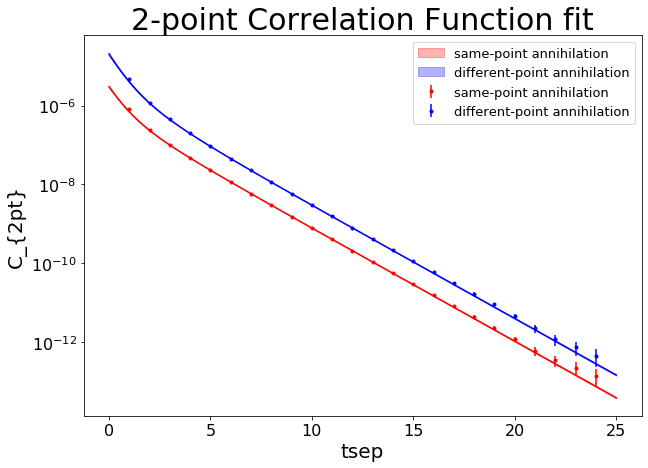

<Figure size 432x288 with 0 Axes>

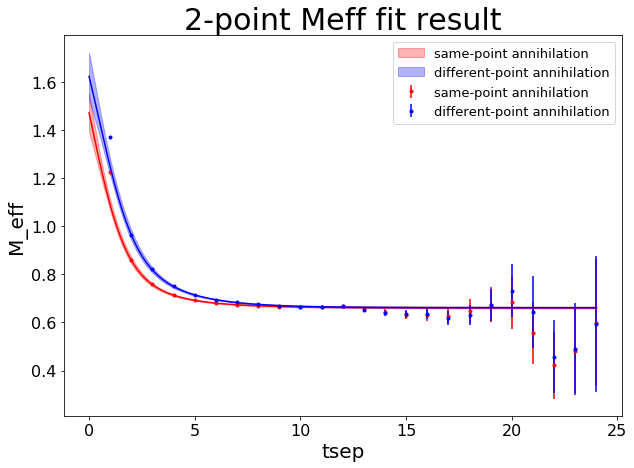

<Figure size 432x288 with 0 Axes>

In [70]:
# Plot the fits

t_plot = np.array([i for i in range(1, 25)])
x_raw2pt = np.array([t_plot, t_plot])
y_raw2pt_mean = np.array([[gv_avg_data['2pt_SS'][i].mean for i in t_plot], [gv_avg_data['2pt_PS'][i].mean for i in t_plot]])
y_raw2pt_sdev = np.array([[gv_avg_data['2pt_SS'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS'][i].sdev for i in t_plot]])
y_2ptmeff_mean = np.array([[gv_avg_data['2pt_SS_meff'][i].mean for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].mean for i in t_plot]])
y_2ptmeff_sdev = np.array([[gv_avg_data['2pt_SS_meff'][i].sdev for i in t_plot], [gv_avg_data['2pt_PS_meff'][i].sdev for i in t_plot]])

x_raw2pt_fit = np.array([tsep_model, tsep_model])
y_raw2pt_fit_mean = np.array([C2ptSS_model_mean, C2ptPS_model_mean])
y_raw2pt_fit_upper = np.array([C2ptSS_model_upbound, C2ptPS_model_upbound])
y_raw2pt_fit_lower = np.array([C2ptSS_model_lowbound, C2ptPS_model_lowbound])
h5_dm.fit_data_plot("2-point Correlation Function fit", "tsep", "C_{2pt}", x_raw2pt, y_raw2pt_mean, x_raw2pt_fit, y_raw2pt_fit_mean, y_raw2pt_fit_upper, y_raw2pt_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_raw2pt_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"], logy = True)

y_2ptmeff_fit_mean = np.array([SS_meff_model_mean, PS_meff_model_mean])
y_2ptmeff_fit_upper = np.array([SS_meff_model_upbound, PS_meff_model_upbound])
y_2ptmeff_fit_lower = np.array([SS_meff_model_lowbound, PS_meff_model_lowbound])

#print(np.shape(x_raw2pt))
#print(np.shape(y_2ptmeff_mean))
#print(np.shape(x_raw2pt_fit[:,:-step_up]))
#print(np.shape(y_2ptmeff_fit_mean))
#print(np.shape(y_2ptmeff_fit_upper))
#print(np.shape(y_2ptmeff_fit_lower))
#print(np.shape(y_2ptmeff_sdev))

h5_dm.fit_data_plot("2-point Meff fit result", "tsep", "M_eff", x_raw2pt, y_2ptmeff_mean, x_raw2pt_fit[:,:-step_up], y_2ptmeff_fit_mean, y_2ptmeff_fit_upper, y_2ptmeff_fit_lower, ['red', 'blue'], 30, 20, 16, 13, ylim = None, nplots = 2, ydat_error = y_2ptmeff_sdev, datalabels = ["same-point annihilation", "different-point annihilation"], fitlabels = ["same-point annihilation", "different-point annihilation"])

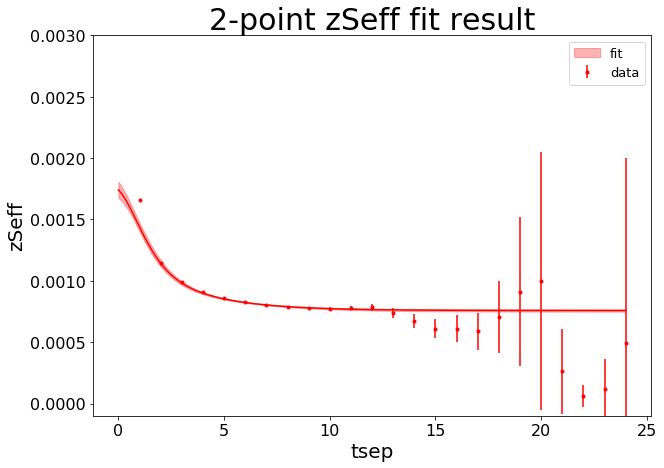

<Figure size 432x288 with 0 Axes>

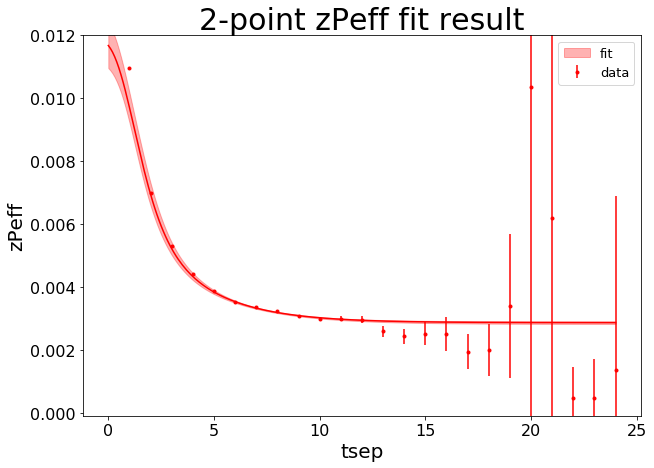

<Figure size 432x288 with 0 Axes>

In [71]:
h5_dm.fit_data_plot("2-point zSeff fit result", "tsep", "zSeff", x_raw2pt[0], [gv_avg_data['2pt_zSeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zSeff_model_mean, zSeff_model_upbound, zSeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.003], ydat_error = [gv_avg_data['2pt_zSeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")
h5_dm.fit_data_plot("2-point zPeff fit result", "tsep", "zPeff", x_raw2pt[1], [gv_avg_data['2pt_zPeff'][i].mean for i in t_plot], x_raw2pt_fit[0,:-step_up], zPeff_model_mean, zPeff_model_upbound, zPeff_model_lowbound, "red", 30, 20, 16, 13, ylim=[-0.0001, 0.012], ydat_error = [gv_avg_data['2pt_zPeff'][i].sdev for i in t_plot], datalabels = "data", fitlabels = "fit")

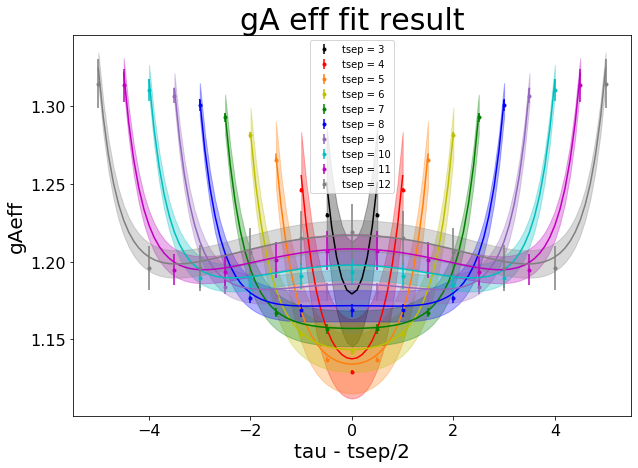

<Figure size 432x288 with 0 Axes>

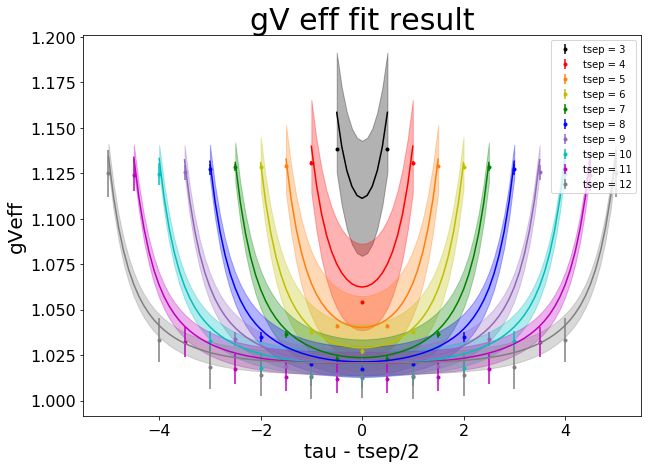

<Figure size 432x288 with 0 Axes>

In [72]:
# The color pallete for plotting the 3-point correlation function
colors_3pt = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey'])

# The raw dataset fitted to
x_3pt = np.array([[j - (i+3)/2. for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].mean for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_A3_err = np.array([ np.array([gv_avg_data['C_ratio_A3'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_A3'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4 = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].mean for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])
y_3pt_V4_err = np.array([ np.array([gv_avg_data['C_ratio_V4'][i][j].sdev for j in range(len(gv_avg_data['C_ratio_V4'][i]))]) for i in range(len(tsep_vals))])

h5_dm.fit_data_plot("gA eff fit result", "tau - tsep/2", "gAeff", x_3pt, y_3pt_A3, t_3pt_tseptau_diff, model_A3_ratio_2d_mean, model_A3_ratio_2d_upbound, model_A3_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_A3']), ydat_error=y_3pt_A3_err, datalabels = legendlabels_3pt) 
h5_dm.fit_data_plot("gV eff fit result", "tau - tsep/2", "gVeff", x_3pt, y_3pt_V4, t_3pt_tseptau_diff, model_V4_ratio_2d_mean, model_V4_ratio_2d_upbound, model_V4_ratio_2d_lowbound, colors_3pt, 30, 20, 16, 13, nplots = len(gv_avg_data['C_ratio_V4']), ydat_error=y_3pt_V4_err, datalabels = legendlabels_3pt) 

#### Now, vary the width of the first excited state, the tau-bounds (calculated as distance from 0 of the minimum and from tsep of the maximum

Set the arrays over which to loop over and the priors and 3-point data-sets to use at each iteration

In [73]:
# Create arrays for the parameters that will be varied
b = np.array([0.1, 0.3, 0.5, 0.7, 1.0])
#tsep_mins = np.array([3, 7, 10])
tau_cuts = np.arange(1,4,1)
n_z_vals = np.arange(3,8,1)
n_FH_vals = np.array([2, 3])

n_zFH_combined = np.arange(6, 16, 1) # these n-values are there to encode both num_zs and n_FH
zFH_splitted = 2 #The number such that n_zFH_combined/2 is num_zs and (n_zFH_combined % 2) + 2 is num_states_FH

In [74]:
# set priors for each dE-set, num-z set, and num-FH-set
priors = []
for i in range(3):
    priors.append([])
    for j in range(len(b)):
        priors[i].append([])
        for k in range(len(n_zFH_combined)):
            priors[i][j].append(gv.BufferDict())
            
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            e_decay_exp = i
            
            priors[i][j][k]['E0'] = gv.gvar(0.67, 0.02)
            priors[i][j][k]['Z0'] = gv.gvar(0.0008, 0.0003)
            priors[i][j][k]['Ztilde0'] = gv.gvar(0.003, 0.003)

            # Define some constants for prioring the higher-order energies
            dE0 = 2*mpi

            # Use constant dE to prior the energies
            energyvals = np.array([None]*num_zs)
            dEvals = np.array([None]*(num_zs - 1))

            #E0_errbar = 0.8
            energyvals[0] = gv.gvar(0.67, 0.02)
            for n in range(1, num_zs):
                dEvals[n-1] = dE0/np.power(n, e_decay_exp)
                energyvals[n] = energyvals[n-1] + dEvals[n-1]
            
            priors[i][j][k]['log(dE1)'] = gv.gvar(np.log(dEvals[0]), b[j])
            priors[i][j][k]['Z1'] = gv.gvar(0.0012, 0.0006)
            priors[i][j][k]['Ztilde1'] = gv.gvar(0, 0.01)
            
            for n in range(2, num_zs):
                priors[i][j][k]['log(dE{})'.format(n)] = gv.gvar(np.log(dEvals[n-1]), 0.7)
                priors[i][j][k]['Z{}'.format(n)] = gv.gvar(0.0012, 0.0006)
                priors[i][j][k]['Ztilde{}'.format(n)] = gv.gvar(0, 0.01)


            for n in range(num_zs):
                for m in range(num_zs):
        
                    priors[i][j][k]['gA3_{0}{1}'.format(n, m)] = gv.gvar(0, 2)
                    if n == m and n < num_zs-1:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(1, 0.1)
                    else:
                        priors[i][j][k]['gV4_{0}{1}'.format(n, m)] = gv.gvar(0, 2)

            priors[i][j][k]['gA3_00'] = gv.gvar(1.25, 0.15)
            priors[i][j][k]['gV4_00'] = gv.gvar(1.07, 0.07)

            # Set the "garbage can" for the Feynman Hellman fit
            #priors[i][j][k]['Z_FHmax'] = gv.gvar(0.0008, 0.0004)
            #if num_states_FH == 2:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), b[j])
            #else:
                #priors[i][j][k]['log(FH_dEmax)'] = gv.gvar(np.log(dEvals[num_states_FH - 2]), 0.7)

            #for n in range(num_states_FH-1):
                #priors[i][j][k]['gA3_FHmax{}'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gA3_{}FHmax'.format(n)] = gv.gvar(1, 2)
                #priors[i][j][k]['gV4_FHmax{}'.format(n)] = gv.gvar(0, 2)
                #priors[i][j][k]['gV4_{}FHmax'.format(n)] = gv.gvar(0, 2)
    
            #priors[i][j][k]['gA3_FHmaxFHmax'] = gv.gvar(1, 2)
            #priors[i][j][k]['gV4_FHmaxFHmax'] = gv.gvar(0, 2)
            
            

In [75]:
list_LogGBF_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a0_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a1_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_LogGBF_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_LogGBF_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_2pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_Q_a2_3pt = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_E0_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2 = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))


In [78]:
# Create 3-point datasets for each tau-cut data set
tau_cut_to_min_tsep = np.array([3, 4, 6])
x_vals_3fit = []
y_vals_3fit = []

y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)

y_3pt = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])

for i in range(len(tau_cuts)):
    x_vals_3fit.append([])
    y_vals_3fit.append([])
    
    for k in range(len(t_1d_array)):
        if(t_1d_array[k][0] >= tau_cut_to_min_tsep[i]):
            if(t_1d_array[k][1] >= tau_cuts[i]):
                if(t_1d_array[k][1] <= t_1d_array[k][0] - tau_cuts[i]):
                    x_vals_3fit[i].append(t_1d_array[k].tolist())
                    y_vals_3fit[i].append(y_3pt[k].tolist())
                            
    x_vals_3fit[i] = np.array(x_vals_3fit[i])
    y_vals_3fit[i] = np.array(y_vals_3fit[i])

In [79]:
for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            num_zs = n_zFH_combined[k]//2
            num_states_FH = n_zFH_combined[k] % 2 + 2
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[0][i][k],fcn=C_2pt,debug=True)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[1][i][k],fcn=C_2pt,debug=True)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(np.array([l for l in range(2, 13)]), np.array([[ [c] for c in gv_avg_data['2pt'][l]] for l in range(2,13)]) ), prior=priors[2][i][k],fcn=C_2pt,debug=True)
                
            fit_a0 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a0_2pt.p,fcn=C_3pt,debug=True)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a1_2pt.p,fcn=C_3pt,debug=True)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_vals_3fit[j], y_vals_3fit[j]), prior=fit_a2_2pt.p,fcn=C_3pt,debug=True)
            
            print("dE constant, lod(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(pstyle='vv'))    
            list_LogGBF_a0_2pt[i][j][k] = fit_a0_2pt.logGBF
            list_LogGBF_a0_3pt[i][j][k] = fit_a0.logGBF
            list_Q_a0_2pt[i][j][k] = fit_a0_2pt.Q
            list_Q_a0_3pt[i][j][k] = fit_a0.Q
            list_E0_a0[i][j][k] = fit_a0.p['E0']
            list_gA00_a0[i][j][k] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j][k] = fit_a0.p['gV4_00']
                
            print("dE proportional to 1/n, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(pstyle='vv')) 
            list_LogGBF_a1_2pt[i][j][k] = fit_a1_2pt.logGBF
            list_LogGBF_a1_3pt[i][j][k] = fit_a1.logGBF
            list_Q_a1_2pt[i][j][k] = fit_a1_2pt.Q
            list_Q_a1_3pt[i][j][k] = fit_a1.Q
            list_E0_a1[i][j][k] = fit_a1.p['E0']
            list_gA00_a1[i][j][k] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j][k] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, log(dE1) bound = ", b[i], " tau_cuts = ", tau_cuts[j], " num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(pstyle='vv'))
            list_LogGBF_a2_2pt[i][j][k] = fit_a2_2pt.logGBF
            list_LogGBF_a2_3pt[i][j][k] = fit_a2.logGBF
            list_Q_a2_2pt[i][j][k] = fit_a2_2pt.Q
            list_Q_a2_3pt[i][j][k] = fit_a2.Q
            list_E0_a2[i][j][k] = fit_a2.p['E0']
            list_gA00_a2[i][j][k] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j][k] = fit_a2.p['gV4_00']
                


dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 6.9 [130]    Q = 3.6e-114    logGBF = 3521.3

Parameters:
             E0       0.657416 +- 0.00143707             [     0.660763 +- 0.00194013 ]  *
             Z0   0.000741488 +- 4.28415e-06             [ 0.000755481 +- 6.18476e-06 ]  **
        Ztilde0    0.00281359 +- 1.94973e-05             [   0.00285135 +- 2.8959e-05 ]  *
       log(dE1)       -0.388105 +- 0.0217095             [       -0.8198 +- 0.0578138 ]  *****
             Z1    0.00108423 +- 1.00873e-05             [ 0.000679381 +- 3.50719e-05 ]  *****
        Ztilde1    0.00715756 +- 8.13664e-05             [   0.0045985 +- 0.000250554 ]  *****
       log(dE2)       0.558085 +- 0.00588618             [     -0.125217 +- 0.0425782 ]  *****
             Z2     0.00159517 +- 7.8436e-06             [  0.00132388 +- 1.75388e-05 ]  *****
        Ztilde2     0.0126254 +- 7.03903e-05             [  0.00984182 +-

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 6.9 [130]    Q = 3.6e-114    logGBF = 3521.3

Parameters:
             E0       0.657416 +- 0.00143707             [     0.660763 +- 0.00194013 ]  *
             Z0   0.000741488 +- 4.28415e-06             [ 0.000755481 +- 6.18476e-06 ]  **
        Ztilde0    0.00281359 +- 1.94973e-05             [   0.00285135 +- 2.8959e-05 ]  *
       log(dE1)       -0.388105 +- 0.0217095             [       -0.8198 +- 0.0578138 ]  *****
             Z1    0.00108423 +- 1.00873e-05             [ 0.000679381 +- 3.50719e-05 ]  *****
        Ztilde1    0.00715756 +- 8.13664e-05             [   0.0045985 +- 0.000250554 ]  *****
       log(dE2)       0.558085 +- 0.00588618             [     -0.125217 +- 0.0425782 ]  *****
             Z2     0.00159517 +- 7.8436e-06             [  0.00132388 +- 1.75388e-05 ]  *****
        Ztilde2     0.0126254 +- 7.03903e-05             [  0.00984182 +-

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.71 [130]    Q = 1    logGBF = 3898.7

Parameters:
             E0       0.665358 +- 0.00223349             [      0.66017 +- 0.00311819 ]  *
             Z0     0.0007739 +- 7.67208e-06             [ 0.000752509 +- 1.16599e-05 ]  *
        Ztilde0    0.00292893 +- 3.21541e-05             [  0.00283822 +- 4.98331e-05 ]  *
       log(dE1)       -0.961399 +- 0.0608004             [     -0.964082 +- 0.0958084 ]  
             Z1   0.000392524 +- 4.29655e-05             [ 0.000558573 +- 9.46835e-05 ]  *
        Ztilde1    0.00312147 +- 0.000236854             [  0.00363474 +- 0.000563347 ]  
       log(dE2)       -0.722169 +- 0.0656094             [      -0.766081 +- 0.488679 ]  
             Z2    0.00133108 +- 6.41655e-05             [ 0.000778734 +- 0.000296933 ]  *
        Ztilde2    0.00851729 +- 0.000403919             [   0.00579599 +- 0.00217274 ]  *
       log(d

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.71 [130]    Q = 1    logGBF = 3898.7

Parameters:
             E0       0.665358 +- 0.00223349             [      0.66017 +- 0.00311819 ]  *
             Z0     0.0007739 +- 7.67208e-06             [ 0.000752509 +- 1.16599e-05 ]  *
        Ztilde0    0.00292893 +- 3.21541e-05             [  0.00283822 +- 4.98331e-05 ]  *
       log(dE1)       -0.961399 +- 0.0608004             [     -0.964082 +- 0.0958084 ]  
             Z1   0.000392524 +- 4.29655e-05             [ 0.000558573 +- 9.46835e-05 ]  *
        Ztilde1    0.00312147 +- 0.000236854             [  0.00363474 +- 0.000563347 ]  
       log(dE2)       -0.722169 +- 0.0656094             [      -0.766081 +- 0.488679 ]  
             Z2    0.00133108 +- 6.41655e-05             [ 0.000778734 +- 0.000296933 ]  *
        Ztilde2    0.00851729 +- 0.000403919             [   0.00579599 +- 0.00217274 ]  *
       log(d

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.41 [130]    Q = 1    logGBF = 3908.7

Parameters:
             E0       0.659428 +- 0.00269411             [     0.659605 +- 0.00329025 ]  
             Z0   0.000749976 +- 1.01386e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00282524 +- 4.30172e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)       -0.892539 +- 0.0775851             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000632703 +- 5.41309e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00420069 +- 0.000357221             [  0.00356033 +- 0.000528734 ]  *
       log(dE2)         -0.17738 +- 0.150668             [      -0.713988 +- 0.424306 ]  *
             Z2    0.00113078 +- 0.000125348             [ 0.000742327 +- 0.000315844 ]  *
        Ztilde2       0.0088192 +- 0.0013579             [   0.00649232 +- 0.00254085 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.41 [130]    Q = 1    logGBF = 3908.7

Parameters:
             E0       0.659428 +- 0.00269411             [     0.659605 +- 0.00329025 ]  
             Z0   0.000749976 +- 1.01386e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00282524 +- 4.30172e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)       -0.892539 +- 0.0775851             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000632703 +- 5.41309e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00420069 +- 0.000357221             [  0.00356033 +- 0.000528734 ]  *
       log(dE2)         -0.17738 +- 0.150668             [      -0.713988 +- 0.424306 ]  *
             Z2    0.00113078 +- 0.000125348             [ 0.000742327 +- 0.000315844 ]  *
        Ztilde2       0.0088192 +- 0.0013579             [   0.00649232 +- 0.00254085 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 1.4e+03 [130]    Q = 0    logGBF = -87764

Parameters:
             E0        0.681384 +- 0.00286521             [     0.659839 +- 0.00334305 ]  *****
             Z0    0.000738333 +- 1.07787e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0     0.00277152 +- 4.50315e-05             [  0.00283276 +- 5.40395e-05 ]  *
       log(dE1)        -0.958381 +- 0.0940788             [     -0.982934 +- 0.0975408 ]  
             Z1    0.000447387 +- 7.92547e-05             [ 0.000559628 +- 9.08169e-05 ]  *
        Ztilde1      0.0030193 +- 0.000492431             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -0.691761 +- 0.316402             [      -0.726969 +- 0.440483 ]  
             Z2    0.000697693 +- 0.000229599             [   0.000751501 +- 0.0003099 ]  
        Ztilde2      0.00632201 +- 0.00220516             [   0.00638306 +- 0.00277991 ]  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.4e+03 [130]    Q = 0    logGBF = -87764

Parameters:
             E0        0.681384 +- 0.00286521             [     0.659839 +- 0.00334305 ]  *****
             Z0    0.000738333 +- 1.07787e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0     0.00277152 +- 4.50315e-05             [  0.00283276 +- 5.40395e-05 ]  *
       log(dE1)        -0.958381 +- 0.0940788             [     -0.982934 +- 0.0975408 ]  
             Z1    0.000447387 +- 7.92547e-05             [ 0.000559628 +- 9.08169e-05 ]  *
        Ztilde1      0.0030193 +- 0.000492431             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -0.691761 +- 0.316402             [      -0.726969 +- 0.440483 ]  
             Z2    0.000697693 +- 0.000229599             [   0.000751501 +- 0.0003099 ]  
        Ztilde2      0.00632201 +- 0.00220516             [   0.00638306 +- 0.00277991 ]  

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3901.2

Parameters:
             E0       0.663178 +- 0.00305069             [     0.660121 +- 0.00338817 ]  
             Z0   0.000764499 +- 1.16307e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00288765 +- 4.88841e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.00968 +- 0.0926265             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000426352 +- 8.16609e-05             [ 0.000550927 +- 9.69924e-05 ]  *
        Ztilde1    0.00302354 +- 0.000472093             [  0.00351932 +- 0.000537723 ]  
       log(dE2)         -1.24773 +- 0.313377             [      -0.722836 +- 0.434256 ]  *
             Z2   0.000624806 +- 0.000214822             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00338422 +- 0.00214411             [   0.00632795 +- 0.00276443 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  0.1  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3901.2

Parameters:
             E0       0.663178 +- 0.00305069             [     0.660121 +- 0.00338817 ]  
             Z0   0.000764499 +- 1.16307e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00288765 +- 4.88841e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.00968 +- 0.0926265             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000426352 +- 8.16609e-05             [ 0.000550927 +- 9.69924e-05 ]  *
        Ztilde1    0.00302354 +- 0.000472093             [  0.00351932 +- 0.000537723 ]  
       log(dE2)         -1.24773 +- 0.313377             [      -0.722836 +- 0.434256 ]  *
             Z2   0.000624806 +- 0.000214822             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00338422 +- 0.00214411             [   0.00632795 +- 0.00276443 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.43 [90]    Q = 1    logGBF = 2728.4

Parameters:
             E0       0.661184 +- 0.00183347             [     0.660763 +- 0.00194013 ]  
             Z0    0.000754958 +- 5.7935e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00284029 +- 2.68853e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.937394 +- 0.0374487             [       -0.8198 +- 0.0578138 ]  **
             Z1   0.000594986 +- 1.98535e-05             [ 0.000679381 +- 3.50719e-05 ]  **
        Ztilde1    0.00402371 +- 0.000140308             [   0.0045985 +- 0.000250554 ]  **
       log(dE2)        -0.22268 +- 0.0271405             [     -0.125217 +- 0.0425782 ]  **
             Z2    0.00129191 +- 1.35858e-05             [  0.00132388 +- 1.75388e-05 ]  *
        Ztilde2    0.00947795 +- 0.000144228             [  0.00984182 +- 0.000188411 ]  *
         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.43 [90]    Q = 1    logGBF = 2728.4

Parameters:
             E0       0.661184 +- 0.00183347             [     0.660763 +- 0.00194013 ]  
             Z0    0.000754958 +- 5.7935e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00284029 +- 2.68853e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.937394 +- 0.0374487             [       -0.8198 +- 0.0578138 ]  **
             Z1   0.000594986 +- 1.98535e-05             [ 0.000679381 +- 3.50719e-05 ]  **
        Ztilde1    0.00402371 +- 0.000140308             [   0.0045985 +- 0.000250554 ]  **
       log(dE2)        -0.22268 +- 0.0271405             [     -0.125217 +- 0.0425782 ]  **
             Z2    0.00129191 +- 1.35858e-05             [  0.00132388 +- 1.75388e-05 ]  *
        Ztilde2    0.00947795 +- 0.000144228             [  0.00984182 +- 0.000188411 ]  *
         

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.33 [90]    Q = 1    logGBF = 2721.4

Parameters:
             E0       0.660403 +- 0.00290145             [      0.66017 +- 0.00311819 ]  
             Z0   0.000753303 +- 1.08444e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0    0.00284138 +- 4.64601e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)        -0.990013 +- 0.090142             [     -0.964082 +- 0.0958084 ]  
             Z1    0.000509185 +- 8.0692e-05             [ 0.000558573 +- 9.46835e-05 ]  
        Ztilde1    0.00330172 +- 0.000489421             [  0.00363474 +- 0.000563347 ]  
       log(dE2)         -1.22135 +- 0.364511             [      -0.766081 +- 0.488679 ]  
             Z2   0.000519017 +- 0.000194721             [ 0.000778734 +- 0.000296933 ]  
        Ztilde2     0.00378162 +- 0.00148347             [   0.00579599 +- 0.00217274 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.33 [90]    Q = 1    logGBF = 2721.4

Parameters:
             E0       0.660403 +- 0.00290145             [      0.66017 +- 0.00311819 ]  
             Z0   0.000753303 +- 1.08444e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0    0.00284138 +- 4.64601e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)        -0.990013 +- 0.090142             [     -0.964082 +- 0.0958084 ]  
             Z1    0.000509185 +- 8.0692e-05             [ 0.000558573 +- 9.46835e-05 ]  
        Ztilde1    0.00330172 +- 0.000489421             [  0.00363474 +- 0.000563347 ]  
       log(dE2)         -1.22135 +- 0.364511             [      -0.766081 +- 0.488679 ]  
             Z2   0.000519017 +- 0.000194721             [ 0.000778734 +- 0.000296933 ]  
        Ztilde2     0.00378162 +- 0.00148347             [   0.00579599 +- 0.00217274 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.31 [90]    Q = 1    logGBF = 2718

Parameters:
             E0        0.660073 +- 0.0031274             [     0.659605 +- 0.00329025 ]  
             Z0   0.000751493 +- 1.19768e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00283474 +- 5.04534e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)        -1.02237 +- 0.0929186             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000512669 +- 7.62199e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1     0.00317986 +- 0.00047382             [  0.00356033 +- 0.000528734 ]  
       log(dE2)         -1.02774 +- 0.346963             [      -0.713988 +- 0.424306 ]  
             Z2   0.000598852 +- 0.000252374             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00493959 +- 0.00220888             [   0.00649232 +- 0.00254085 ]  
       log(dE3)      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.31 [90]    Q = 1    logGBF = 2718

Parameters:
             E0        0.660073 +- 0.0031274             [     0.659605 +- 0.00329025 ]  
             Z0   0.000751493 +- 1.19768e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00283474 +- 5.04534e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)        -1.02237 +- 0.0929186             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000512669 +- 7.62199e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1     0.00317986 +- 0.00047382             [  0.00356033 +- 0.000528734 ]  
       log(dE2)         -1.02774 +- 0.346963             [      -0.713988 +- 0.424306 ]  
             Z2   0.000598852 +- 0.000252374             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00493959 +- 0.00220888             [   0.00649232 +- 0.00254085 ]  
       log(dE3)      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2717.5

Parameters:
             E0       0.660584 +- 0.00316225             [     0.659839 +- 0.00334305 ]  
             Z0   0.000753707 +- 1.21619e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00284342 +- 5.11561e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)        -1.02918 +- 0.0931591             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000489425 +- 8.05359e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00310993 +- 0.000477828             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -1.07908 +- 0.353452             [      -0.726969 +- 0.440483 ]  
             Z2    0.00060194 +- 0.000245197             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00453852 +- 0.00236711             [   0.00638306 +- 0.00277991 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2717.5

Parameters:
             E0       0.660584 +- 0.00316225             [     0.659839 +- 0.00334305 ]  
             Z0   0.000753707 +- 1.21619e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00284342 +- 5.11561e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)        -1.02918 +- 0.0931591             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000489425 +- 8.05359e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00310993 +- 0.000477828             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -1.07908 +- 0.353452             [      -0.726969 +- 0.440483 ]  
             Z2    0.00060194 +- 0.000245197             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00453852 +- 0.00236711             [   0.00638306 +- 0.00277991 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2717.4

Parameters:
             E0       0.661138 +- 0.00317982             [     0.660121 +- 0.00338817 ]  
             Z0   0.000756109 +- 1.22466e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00285261 +- 5.15048e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.03276 +- 0.0931033             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000467655 +- 8.43934e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1    0.00307268 +- 0.000476558             [  0.00351932 +- 0.000537723 ]  
       log(dE2)          -1.0983 +- 0.343415             [      -0.722836 +- 0.434256 ]  
             Z2   0.000623586 +- 0.000231758             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00434287 +- 0.00230404             [   0.00632795 +- 0.00276443 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2717.4

Parameters:
             E0       0.661138 +- 0.00317982             [     0.660121 +- 0.00338817 ]  
             Z0   0.000756109 +- 1.22466e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00285261 +- 5.15048e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -1.03276 +- 0.0931033             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000467655 +- 8.43934e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1    0.00307268 +- 0.000476558             [  0.00351932 +- 0.000537723 ]  
       log(dE2)          -1.0983 +- 0.343415             [      -0.722836 +- 0.434256 ]  
             Z2   0.000623586 +- 0.000231758             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00434287 +- 0.00230404             [   0.00632795 +- 0.00276443 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.28 [56]    Q = 1    logGBF = 1704

Parameters:
             E0        0.66033 +- 0.00190345             [     0.660763 +- 0.00194013 ]  
             Z0   0.000753776 +- 6.05956e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00284175 +- 2.82988e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.842725 +- 0.0558949             [       -0.8198 +- 0.0578138 ]  
             Z1    0.00066636 +- 3.39769e-05             [ 0.000679381 +- 3.50719e-05 ]  
        Ztilde1     0.00449925 +- 0.00024175             [   0.0045985 +- 0.000250554 ]  
       log(dE2)       -0.139712 +- 0.0414402             [     -0.125217 +- 0.0425782 ]  
             Z2    0.00131888 +- 1.71952e-05             [  0.00132388 +- 1.75388e-05 ]  
        Ztilde2    0.00978681 +- 0.000184106             [  0.00984182 +- 0.000188411 ]  
         gA3_00      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.28 [56]    Q = 1    logGBF = 1704

Parameters:
             E0        0.66033 +- 0.00190345             [     0.660763 +- 0.00194013 ]  
             Z0   0.000753776 +- 6.05956e-06             [ 0.000755481 +- 6.18476e-06 ]  
        Ztilde0    0.00284175 +- 2.82988e-05             [   0.00285135 +- 2.8959e-05 ]  
       log(dE1)       -0.842725 +- 0.0558949             [       -0.8198 +- 0.0578138 ]  
             Z1    0.00066636 +- 3.39769e-05             [ 0.000679381 +- 3.50719e-05 ]  
        Ztilde1     0.00449925 +- 0.00024175             [   0.0045985 +- 0.000250554 ]  
       log(dE2)       -0.139712 +- 0.0414402             [     -0.125217 +- 0.0425782 ]  
             Z2    0.00131888 +- 1.71952e-05             [  0.00132388 +- 1.75388e-05 ]  
        Ztilde2    0.00978681 +- 0.000184106             [  0.00984182 +- 0.000188411 ]  
         gA3_00      

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1699.4

Parameters:
             E0       0.660057 +- 0.00303282             [      0.66017 +- 0.00311819 ]  
             Z0   0.000752156 +- 1.13506e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0    0.00283664 +- 4.86066e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)       -0.961241 +- 0.0943411             [     -0.964082 +- 0.0958084 ]  
             Z1   0.000555058 +- 9.22605e-05             [ 0.000558573 +- 9.46835e-05 ]  
        Ztilde1    0.00360492 +- 0.000545578             [  0.00363474 +- 0.000563347 ]  
       log(dE2)        -0.885767 +- 0.452898             [      -0.766081 +- 0.488679 ]  
             Z2   0.000696643 +- 0.000269713             [ 0.000778734 +- 0.000296933 ]  
        Ztilde2     0.00518975 +- 0.00198538             [   0.00579599 +- 0.00217274 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1699.4

Parameters:
             E0       0.660057 +- 0.00303282             [      0.66017 +- 0.00311819 ]  
             Z0   0.000752156 +- 1.13506e-05             [ 0.000752509 +- 1.16599e-05 ]  
        Ztilde0    0.00283664 +- 4.86066e-05             [  0.00283822 +- 4.98331e-05 ]  
       log(dE1)       -0.961241 +- 0.0943411             [     -0.964082 +- 0.0958084 ]  
             Z1   0.000555058 +- 9.22605e-05             [ 0.000558573 +- 9.46835e-05 ]  
        Ztilde1    0.00360492 +- 0.000545578             [  0.00363474 +- 0.000563347 ]  
       log(dE2)        -0.885767 +- 0.452898             [      -0.766081 +- 0.488679 ]  
             Z2   0.000696643 +- 0.000269713             [ 0.000778734 +- 0.000296933 ]  
        Ztilde2     0.00518975 +- 0.00198538             [   0.00579599 +- 0.00217274 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1699.3

Parameters:
             E0       0.659508 +- 0.00318398             [     0.659605 +- 0.00329025 ]  
             Z0   0.000749543 +- 1.21961e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00282746 +- 5.13267e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)       -0.981657 +- 0.0956018             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000565164 +- 8.26397e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00349957 +- 0.000514213             [  0.00356033 +- 0.000528734 ]  
       log(dE2)        -0.809512 +- 0.406316             [      -0.713988 +- 0.424306 ]  
             Z2   0.000661616 +- 0.000295062             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00608131 +- 0.00247348             [   0.00649232 +- 0.00254085 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1699.3

Parameters:
             E0       0.659508 +- 0.00318398             [     0.659605 +- 0.00329025 ]  
             Z0   0.000749543 +- 1.21961e-05             [ 0.000749922 +- 1.26049e-05 ]  
        Ztilde0    0.00282746 +- 5.13267e-05             [  0.00282888 +- 5.29096e-05 ]  
       log(dE1)       -0.981657 +- 0.0956018             [     -0.979227 +- 0.0971999 ]  
             Z1   0.000565164 +- 8.26397e-05             [ 0.000569519 +- 8.43534e-05 ]  
        Ztilde1    0.00349957 +- 0.000514213             [  0.00356033 +- 0.000528734 ]  
       log(dE2)        -0.809512 +- 0.406316             [      -0.713988 +- 0.424306 ]  
             Z2   0.000661616 +- 0.000295062             [ 0.000742327 +- 0.000315844 ]  
        Ztilde2     0.00608131 +- 0.00247348             [   0.00649232 +- 0.00254085 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1699.2

Parameters:
             E0       0.659782 +- 0.00323246             [     0.659839 +- 0.00334305 ]  
             Z0    0.000750709 +- 1.2454e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00283203 +- 5.23531e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)       -0.986114 +- 0.0959604             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000552781 +- 8.83827e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00345991 +- 0.000520523             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -0.82525 +- 0.418913             [      -0.726969 +- 0.440483 ]  
             Z2    0.000673609 +- 0.00028904             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00591488 +- 0.00268374             [   0.00638306 +- 0.00277991 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1699.2

Parameters:
             E0       0.659782 +- 0.00323246             [     0.659839 +- 0.00334305 ]  
             Z0    0.000750709 +- 1.2454e-05             [ 0.000750893 +- 1.28799e-05 ]  
        Ztilde0    0.00283203 +- 5.23531e-05             [  0.00283276 +- 5.40395e-05 ]  
       log(dE1)       -0.986114 +- 0.0959604             [     -0.982934 +- 0.0975408 ]  
             Z1   0.000552781 +- 8.83827e-05             [ 0.000559628 +- 9.08169e-05 ]  
        Ztilde1    0.00345991 +- 0.000520523             [  0.00352605 +- 0.000536794 ]  
       log(dE2)         -0.82525 +- 0.418913             [      -0.726969 +- 0.440483 ]  
             Z2    0.000673609 +- 0.00028904             [   0.000751501 +- 0.0003099 ]  
        Ztilde2     0.00591488 +- 0.00268374             [   0.00638306 +- 0.00277991 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1699.4

Parameters:
             E0        0.660066 +- 0.0032675             [     0.660121 +- 0.00338817 ]  
             Z0   0.000751935 +- 1.26309e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00283657 +- 5.30838e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -0.98692 +- 0.0960225             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000543221 +- 9.37184e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1     0.0034553 +- 0.000520892             [  0.00351932 +- 0.000537723 ]  
       log(dE2)        -0.815359 +- 0.412093             [      -0.722836 +- 0.434256 ]  
             Z2   0.000705953 +- 0.000275451             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00585881 +- 0.00265383             [   0.00632795 +- 0.00276443 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.1  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1699.4

Parameters:
             E0        0.660066 +- 0.0032675             [     0.660121 +- 0.00338817 ]  
             Z0   0.000751935 +- 1.26309e-05             [ 0.000752082 +- 1.31002e-05 ]  
        Ztilde0    0.00283657 +- 5.30838e-05             [  0.00283726 +- 5.49669e-05 ]  
       log(dE1)        -0.98692 +- 0.0960225             [     -0.983415 +- 0.0975814 ]  
             Z1   0.000543221 +- 9.37184e-05             [ 0.000550927 +- 9.69924e-05 ]  
        Ztilde1     0.0034553 +- 0.000520892             [  0.00351932 +- 0.000537723 ]  
       log(dE2)        -0.815359 +- 0.412093             [      -0.722836 +- 0.434256 ]  
             Z2   0.000705953 +- 0.000275451             [ 0.000780238 +- 0.000294295 ]  
        Ztilde2     0.00585881 +- 0.00265383             [   0.00632795 +- 0.00276443 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 5.5 [130]    Q = 7.7e-82    logGBF = 3610.3

Parameters:
             E0        0.660054 +- 0.0013859             [       0.661262 +- 0.001864 ]  
             Z0   0.000753679 +- 4.04882e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00287399 +- 1.85628e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)       -0.329791 +- 0.0212049             [     -0.750973 +- 0.0636921 ]  *****
             Z1     0.00109308 +- 1.0268e-05             [ 0.000717035 +- 4.13974e-05 ]  *****
        Ztilde1    0.00743656 +- 8.87843e-05             [  0.00490633 +- 0.000310126 ]  *****
       log(dE2)       0.562915 +- 0.00598781             [    -0.0946006 +- 0.0542591 ]  *****
             Z2    0.00161322 +- 8.65714e-06             [  0.00133282 +- 2.32641e-05 ]  *****
        Ztilde2     0.0125959 +- 8.04332e-05             [  0.00991329 +- 0.00

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.5 [130]    Q = 7.7e-82    logGBF = 3610.3

Parameters:
             E0        0.660054 +- 0.0013859             [       0.661262 +- 0.001864 ]  
             Z0   0.000753679 +- 4.04882e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00287399 +- 1.85628e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)       -0.329791 +- 0.0212049             [     -0.750973 +- 0.0636921 ]  *****
             Z1     0.00109308 +- 1.0268e-05             [ 0.000717035 +- 4.13974e-05 ]  *****
        Ztilde1    0.00743656 +- 8.87843e-05             [  0.00490633 +- 0.000310126 ]  *****
       log(dE2)       0.562915 +- 0.00598781             [    -0.0946006 +- 0.0542591 ]  *****
             Z2    0.00161322 +- 8.65714e-06             [  0.00133282 +- 2.32641e-05 ]  *****
        Ztilde2     0.0125959 +- 8.04332e-05             [  0.00991329 +- 0.00

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.67 [130]    Q = 1    logGBF = 3900.2

Parameters:
             E0          0.66379 +- 0.002205             [     0.660577 +- 0.00300591 ]  *
             Z0   0.000767599 +- 7.60676e-06             [  0.000754708 +- 1.1433e-05 ]  *
        Ztilde0    0.00290391 +- 3.28611e-05             [  0.00284953 +- 5.12123e-05 ]  *
       log(dE1)       -0.895345 +- 0.0695823             [      -0.882707 +- 0.174874 ]  
             Z1   0.000484662 +- 4.35145e-05             [ 0.000611861 +- 0.000126893 ]  *
        Ztilde1    0.00359603 +- 0.000294931             [   0.0040643 +- 0.000960595 ]  
       log(dE2)       -0.679516 +- 0.0830221             [      -0.663524 +- 0.517413 ]  
             Z2    0.00134806 +- 8.61512e-05             [ 0.000777956 +- 0.000357367 ]  *
        Ztilde2    0.00877738 +- 0.000651874             [   0.00580809 +- 0.00263897 ]  *
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.67 [130]    Q = 1    logGBF = 3900.2

Parameters:
             E0          0.66379 +- 0.002205             [     0.660577 +- 0.00300591 ]  *
             Z0   0.000767599 +- 7.60676e-06             [  0.000754708 +- 1.1433e-05 ]  *
        Ztilde0    0.00290391 +- 3.28611e-05             [  0.00284953 +- 5.12123e-05 ]  *
       log(dE1)       -0.895345 +- 0.0695823             [      -0.882707 +- 0.174874 ]  
             Z1   0.000484662 +- 4.35145e-05             [ 0.000611861 +- 0.000126893 ]  *
        Ztilde1    0.00359603 +- 0.000294931             [   0.0040643 +- 0.000960595 ]  
       log(dE2)       -0.679516 +- 0.0830221             [      -0.663524 +- 0.517413 ]  
             Z2    0.00134806 +- 8.61512e-05             [ 0.000777956 +- 0.000357367 ]  *
        Ztilde2    0.00877738 +- 0.000651874             [   0.00580809 +- 0.00263897 ]  *
       log(d

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910.1

Parameters:
             E0       0.660231 +- 0.00281387             [     0.659435 +- 0.00390573 ]  
             Z0   0.000754179 +- 1.10622e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00284415 +- 4.76381e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)        -0.809878 +- 0.100625             [       -0.99783 +- 0.248314 ]  
             Z1   0.000663054 +- 5.19875e-05             [  0.000561969 +- 0.00012922 ]  
        Ztilde1    0.00451447 +- 0.000402251             [   0.00348387 +- 0.00110222 ]  
       log(dE2)        -0.173285 +- 0.159065             [      -0.718406 +- 0.440565 ]  *
             Z2     0.00110245 +- 0.00012134             [  0.00074424 +- 0.000309818 ]  *
        Ztilde2     0.00869662 +- 0.00139635             [   0.00653126 +- 0.00249658 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910.1

Parameters:
             E0       0.660231 +- 0.00281387             [     0.659435 +- 0.00390573 ]  
             Z0   0.000754179 +- 1.10622e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00284415 +- 4.76381e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)        -0.809878 +- 0.100625             [       -0.99783 +- 0.248314 ]  
             Z1   0.000663054 +- 5.19875e-05             [  0.000561969 +- 0.00012922 ]  
        Ztilde1    0.00451447 +- 0.000402251             [   0.00348387 +- 0.00110222 ]  
       log(dE2)        -0.173285 +- 0.159065             [      -0.718406 +- 0.440565 ]  *
             Z2     0.00110245 +- 0.00012134             [  0.00074424 +- 0.000309818 ]  *
        Ztilde2     0.00869662 +- 0.00139635             [   0.00653126 +- 0.00249658 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 5.6e+02 [130]    Q = 0    logGBF = -32718

Parameters:
             E0        0.676667 +- 0.00331198             [     0.659522 +- 0.00395257 ]  ****
             Z0    0.000765518 +- 1.37632e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0      0.0029202 +- 5.95453e-05             [  0.00282517 +- 7.28433e-05 ]  *
       log(dE1)         -0.982792 +- 0.217629             [       -1.01826 +- 0.257059 ]  
             Z1     0.00047402 +- 0.000117629             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1     0.00276423 +- 0.000926862             [   0.00338666 +- 0.00110453 ]  
       log(dE2)         -0.682747 +- 0.323384             [        -0.73134 +- 0.44665 ]  
             Z2    0.000788905 +- 0.000222535             [  0.000754253 +- 0.00030153 ]  
        Ztilde2      0.00728953 +- 0.00216523             [   0.00646777 +- 0.00270635 ]  
 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.6e+02 [130]    Q = 0    logGBF = -32718

Parameters:
             E0        0.676667 +- 0.00331198             [     0.659522 +- 0.00395257 ]  ****
             Z0    0.000765518 +- 1.37632e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0      0.0029202 +- 5.95453e-05             [  0.00282517 +- 7.28433e-05 ]  *
       log(dE1)         -0.982792 +- 0.217629             [       -1.01826 +- 0.257059 ]  
             Z1     0.00047402 +- 0.000117629             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1     0.00276423 +- 0.000926862             [   0.00338666 +- 0.00110453 ]  
       log(dE2)         -0.682747 +- 0.323384             [        -0.73134 +- 0.44665 ]  
             Z2    0.000788905 +- 0.000222535             [  0.000754253 +- 0.00030153 ]  
        Ztilde2      0.00728953 +- 0.00216523             [   0.00646777 +- 0.00270635 ]  
 

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3899.3

Parameters:
             E0       0.662554 +- 0.00344639             [     0.659793 +- 0.00390366 ]  
             Z0   0.000761116 +- 1.42264e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00287142 +- 6.14756e-05             [  0.00282935 +- 7.16289e-05 ]  
       log(dE1)          -1.1268 +- 0.200374             [       -1.02135 +- 0.258219 ]  
             Z1   0.000372758 +- 0.000107733             [ 0.000536467 +- 0.000142419 ]  *
        Ztilde1    0.00252781 +- 0.000824675             [   0.00336976 +- 0.00110632 ]  
       log(dE2)          -1.29447 +- 0.29322             [      -0.727832 +- 0.439049 ]  *
             Z2   0.000615421 +- 0.000199769             [ 0.000779732 +- 0.000290216 ]  
        Ztilde2     0.00333802 +- 0.00201608             [    0.00641512 +- 0.0026987 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3899.3

Parameters:
             E0       0.662554 +- 0.00344639             [     0.659793 +- 0.00390366 ]  
             Z0   0.000761116 +- 1.42264e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00287142 +- 6.14756e-05             [  0.00282935 +- 7.16289e-05 ]  
       log(dE1)          -1.1268 +- 0.200374             [       -1.02135 +- 0.258219 ]  
             Z1   0.000372758 +- 0.000107733             [ 0.000536467 +- 0.000142419 ]  *
        Ztilde1    0.00252781 +- 0.000824675             [   0.00336976 +- 0.00110632 ]  
       log(dE2)          -1.29447 +- 0.29322             [      -0.727832 +- 0.439049 ]  *
             Z2   0.000615421 +- 0.000199769             [ 0.000779732 +- 0.000290216 ]  
        Ztilde2     0.00333802 +- 0.00201608             [    0.00641512 +- 0.0026987 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.3

Parameters:
             E0       0.661219 +- 0.00176548             [       0.661262 +- 0.001864 ]  
             Z0   0.000755678 +- 5.46494e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00284567 +- 2.55279e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)         -0.90719 +- 0.035514             [     -0.750973 +- 0.0636921 ]  **
             Z1   0.000602171 +- 1.94663e-05             [ 0.000717035 +- 4.13974e-05 ]  **
        Ztilde1    0.00407916 +- 0.000147501             [  0.00490633 +- 0.000310126 ]  **
       log(dE2)        -0.242946 +- 0.028965             [    -0.0946006 +- 0.0542591 ]  **
             Z2    0.00127851 +- 1.59432e-05             [  0.00133282 +- 2.32641e-05 ]  **
        Ztilde2    0.00937939 +- 0.000168151             [  0.00991329 +- 0.000234581 ]  **
       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.3

Parameters:
             E0       0.661219 +- 0.00176548             [       0.661262 +- 0.001864 ]  
             Z0   0.000755678 +- 5.46494e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00284567 +- 2.55279e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)         -0.90719 +- 0.035514             [     -0.750973 +- 0.0636921 ]  **
             Z1   0.000602171 +- 1.94663e-05             [ 0.000717035 +- 4.13974e-05 ]  **
        Ztilde1    0.00407916 +- 0.000147501             [  0.00490633 +- 0.000310126 ]  **
       log(dE2)        -0.242946 +- 0.028965             [    -0.0946006 +- 0.0542591 ]  **
             Z2    0.00127851 +- 1.59432e-05             [  0.00133282 +- 2.32641e-05 ]  **
        Ztilde2    0.00937939 +- 0.000168151             [  0.00991329 +- 0.000234581 ]  **
       

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.33 [90]    Q = 1    logGBF = 2721.5

Parameters:
             E0       0.660362 +- 0.00287153             [     0.660577 +- 0.00300591 ]  
             Z0   0.000753238 +- 1.08812e-05             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0     0.00284071 +- 4.8386e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)        -0.944468 +- 0.133902             [      -0.882707 +- 0.174874 ]  
             Z1    0.00055428 +- 8.89308e-05             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00363333 +- 0.000689751             [   0.0040643 +- 0.000960595 ]  
       log(dE2)         -1.08147 +- 0.381868             [      -0.663524 +- 0.517413 ]  
             Z2    0.00051005 +- 0.000249358             [ 0.000777956 +- 0.000357367 ]  
        Ztilde2     0.00377729 +- 0.00190972             [   0.00580809 +- 0.00263897 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.33 [90]    Q = 1    logGBF = 2721.5

Parameters:
             E0       0.660362 +- 0.00287153             [     0.660577 +- 0.00300591 ]  
             Z0   0.000753238 +- 1.08812e-05             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0     0.00284071 +- 4.8386e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)        -0.944468 +- 0.133902             [      -0.882707 +- 0.174874 ]  
             Z1    0.00055428 +- 8.89308e-05             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00363333 +- 0.000689751             [   0.0040643 +- 0.000960595 ]  
       log(dE2)         -1.08147 +- 0.381868             [      -0.663524 +- 0.517413 ]  
             Z2    0.00051005 +- 0.000249358             [ 0.000777956 +- 0.000357367 ]  
        Ztilde2     0.00377729 +- 0.00190972             [   0.00580809 +- 0.00263897 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2716.5

Parameters:
             E0       0.658732 +- 0.00364986             [     0.659435 +- 0.00390573 ]  
             Z0   0.000744837 +- 1.52599e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00280485 +- 6.61086e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)          -1.1474 +- 0.203084             [       -0.99783 +- 0.248314 ]  
             Z1     0.000467758 +- 0.0001028             [  0.000561969 +- 0.00012922 ]  
        Ztilde1    0.00268489 +- 0.000859384             [   0.00348387 +- 0.00110222 ]  
       log(dE2)         -1.04879 +- 0.345826             [      -0.718406 +- 0.440565 ]  
             Z2    0.000601451 +- 0.00024433             [  0.00074424 +- 0.000309818 ]  
        Ztilde2      0.00521237 +- 0.0021981             [   0.00653126 +- 0.00249658 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2716.5

Parameters:
             E0       0.658732 +- 0.00364986             [     0.659435 +- 0.00390573 ]  
             Z0   0.000744837 +- 1.52599e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00280485 +- 6.61086e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)          -1.1474 +- 0.203084             [       -0.99783 +- 0.248314 ]  
             Z1     0.000467758 +- 0.0001028             [  0.000561969 +- 0.00012922 ]  
        Ztilde1    0.00268489 +- 0.000859384             [   0.00348387 +- 0.00110222 ]  
       log(dE2)         -1.04879 +- 0.345826             [      -0.718406 +- 0.440565 ]  
             Z2    0.000601451 +- 0.00024433             [  0.00074424 +- 0.000309818 ]  
        Ztilde2      0.00521237 +- 0.0021981             [   0.00653126 +- 0.00249658 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.8

Parameters:
             E0       0.659258 +- 0.00371193             [     0.659522 +- 0.00395257 ]  
             Z0   0.000746888 +- 1.56238e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00281238 +- 6.75366e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.17785 +- 0.210054             [       -1.01826 +- 0.257059 ]  
             Z1   0.000435083 +- 0.000106903             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1    0.00254033 +- 0.000858153             [   0.00338666 +- 0.00110453 ]  
       log(dE2)           -1.089 +- 0.347865             [        -0.73134 +- 0.44665 ]  
             Z2   0.000612041 +- 0.000235286             [  0.000754253 +- 0.00030153 ]  
        Ztilde2     0.00486044 +- 0.00234044             [   0.00646777 +- 0.00270635 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.8

Parameters:
             E0       0.659258 +- 0.00371193             [     0.659522 +- 0.00395257 ]  
             Z0   0.000746888 +- 1.56238e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00281238 +- 6.75366e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.17785 +- 0.210054             [       -1.01826 +- 0.257059 ]  
             Z1   0.000435083 +- 0.000106903             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1    0.00254033 +- 0.000858153             [   0.00338666 +- 0.00110453 ]  
       log(dE2)           -1.089 +- 0.347865             [        -0.73134 +- 0.44665 ]  
             Z2   0.000612041 +- 0.000235286             [  0.000754253 +- 0.00030153 ]  
        Ztilde2     0.00486044 +- 0.00234044             [   0.00646777 +- 0.00270635 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.7

Parameters:
             E0        0.659907 +- 0.0036781             [     0.659793 +- 0.00390366 ]  
             Z0   0.000749634 +- 1.54117e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0     0.0028225 +- 6.67252e-05             [  0.00282935 +- 7.16289e-05 ]  
       log(dE1)         -1.19181 +- 0.210663             [       -1.02135 +- 0.258219 ]  
             Z1   0.000407692 +- 0.000110708             [ 0.000536467 +- 0.000142419 ]  
        Ztilde1    0.00246325 +- 0.000857496             [   0.00336976 +- 0.00110632 ]  
       log(dE2)         -1.10436 +- 0.338396             [      -0.727832 +- 0.439049 ]  
             Z2    0.00063436 +- 0.000225528             [ 0.000779732 +- 0.000290216 ]  
        Ztilde2     0.00469834 +- 0.00229289             [    0.00641512 +- 0.0026987 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.7

Parameters:
             E0        0.659907 +- 0.0036781             [     0.659793 +- 0.00390366 ]  
             Z0   0.000749634 +- 1.54117e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0     0.0028225 +- 6.67252e-05             [  0.00282935 +- 7.16289e-05 ]  
       log(dE1)         -1.19181 +- 0.210663             [       -1.02135 +- 0.258219 ]  
             Z1   0.000407692 +- 0.000110708             [ 0.000536467 +- 0.000142419 ]  
        Ztilde1    0.00246325 +- 0.000857496             [   0.00336976 +- 0.00110632 ]  
       log(dE2)         -1.10436 +- 0.338396             [      -0.727832 +- 0.439049 ]  
             Z2    0.00063436 +- 0.000225528             [ 0.000779732 +- 0.000290216 ]  
        Ztilde2     0.00469834 +- 0.00229289             [    0.00641512 +- 0.0026987 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660711 +- 0.00182493             [       0.661262 +- 0.001864 ]  
             Z0    0.000756024 +- 5.7417e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00285547 +- 2.72962e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)       -0.787062 +- 0.0604997             [     -0.750973 +- 0.0636921 ]  
             Z1   0.000694235 +- 3.94342e-05             [ 0.000717035 +- 4.13974e-05 ]  
        Ztilde1    0.00472885 +- 0.000293991             [  0.00490633 +- 0.000310126 ]  
       log(dE2)       -0.122713 +- 0.0521118             [    -0.0946006 +- 0.0542591 ]  
             Z2    0.00132245 +- 2.25871e-05             [  0.00133282 +- 2.32641e-05 ]  
        Ztilde2    0.00981551 +- 0.000227834             [  0.00991329 +- 0.000234581 ]  
         gA3_00     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660711 +- 0.00182493             [       0.661262 +- 0.001864 ]  
             Z0    0.000756024 +- 5.7417e-06             [ 0.000758267 +- 5.88992e-06 ]  
        Ztilde0    0.00285547 +- 2.72962e-05             [  0.00286826 +- 2.81426e-05 ]  
       log(dE1)       -0.787062 +- 0.0604997             [     -0.750973 +- 0.0636921 ]  
             Z1   0.000694235 +- 3.94342e-05             [ 0.000717035 +- 4.13974e-05 ]  
        Ztilde1    0.00472885 +- 0.000293991             [  0.00490633 +- 0.000310126 ]  
       log(dE2)       -0.122713 +- 0.0521118             [    -0.0946006 +- 0.0542591 ]  
             Z2    0.00132245 +- 2.25871e-05             [  0.00133282 +- 2.32641e-05 ]  
        Ztilde2    0.00981551 +- 0.000227834             [  0.00991329 +- 0.000234581 ]  
         gA3_00     

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1700.6

Parameters:
             E0       0.660424 +- 0.00289527             [     0.660577 +- 0.00300591 ]  
             Z0   0.000754178 +- 1.09472e-05             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0    0.00284693 +- 4.88904e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)         -0.87674 +- 0.160467             [      -0.882707 +- 0.174874 ]  
             Z1    0.00061603 +- 0.000117246             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00408953 +- 0.000872685             [   0.0040643 +- 0.000960595 ]  
       log(dE2)        -0.734907 +- 0.467531             [      -0.663524 +- 0.517413 ]  
             Z2   0.000701271 +- 0.000329482             [ 0.000777956 +- 0.000357367 ]  
        Ztilde2     0.00525855 +- 0.00245089             [   0.00580809 +- 0.00263897 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1700.6

Parameters:
             E0       0.660424 +- 0.00289527             [     0.660577 +- 0.00300591 ]  
             Z0   0.000754178 +- 1.09472e-05             [  0.000754708 +- 1.1433e-05 ]  
        Ztilde0    0.00284693 +- 4.88904e-05             [  0.00284953 +- 5.12123e-05 ]  
       log(dE1)         -0.87674 +- 0.160467             [      -0.882707 +- 0.174874 ]  
             Z1    0.00061603 +- 0.000117246             [ 0.000611861 +- 0.000126893 ]  
        Ztilde1    0.00408953 +- 0.000872685             [   0.0040643 +- 0.000960595 ]  
       log(dE2)        -0.734907 +- 0.467531             [      -0.663524 +- 0.517413 ]  
             Z2   0.000701271 +- 0.000329482             [ 0.000777956 +- 0.000357367 ]  
        Ztilde2     0.00525855 +- 0.00245089             [   0.00580809 +- 0.00263897 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.9

Parameters:
             E0         0.6593 +- 0.00366925             [     0.659435 +- 0.00390573 ]  
             Z0   0.000748459 +- 1.54169e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00282252 +- 6.68755e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)         -1.00676 +- 0.227779             [       -0.99783 +- 0.248314 ]  
             Z1   0.000554134 +- 0.000122192             [  0.000561969 +- 0.00012922 ]  
        Ztilde1     0.00339142 +- 0.00100553             [   0.00348387 +- 0.00110222 ]  
       log(dE2)         -0.82033 +- 0.413228             [      -0.718406 +- 0.440565 ]  
             Z2   0.000663377 +- 0.000286663             [  0.00074424 +- 0.000309818 ]  
        Ztilde2     0.00610599 +- 0.00242953             [   0.00653126 +- 0.00249658 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.9

Parameters:
             E0         0.6593 +- 0.00366925             [     0.659435 +- 0.00390573 ]  
             Z0   0.000748459 +- 1.54169e-05             [ 0.000749046 +- 1.65637e-05 ]  
        Ztilde0    0.00282252 +- 6.68755e-05             [  0.00282485 +- 7.17336e-05 ]  
       log(dE1)         -1.00676 +- 0.227779             [       -0.99783 +- 0.248314 ]  
             Z1   0.000554134 +- 0.000122192             [  0.000561969 +- 0.00012922 ]  
        Ztilde1     0.00339142 +- 0.00100553             [   0.00348387 +- 0.00110222 ]  
       log(dE2)         -0.82033 +- 0.413228             [      -0.718406 +- 0.440565 ]  
             Z2   0.000663377 +- 0.000286663             [  0.00074424 +- 0.000309818 ]  
        Ztilde2     0.00610599 +- 0.00242953             [   0.00653126 +- 0.00249658 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.7

Parameters:
             E0        0.659454 +- 0.0037359             [     0.659522 +- 0.00395257 ]  
             Z0   0.000748973 +- 1.57906e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00282401 +- 6.83937e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.02862 +- 0.236679             [       -1.01826 +- 0.257059 ]  
             Z1    0.000534813 +- 0.00012788             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1     0.00328524 +- 0.00100998             [   0.00338666 +- 0.00110453 ]  
       log(dE2)        -0.835516 +- 0.417258             [        -0.73134 +- 0.44665 ]  
             Z2   0.000678054 +- 0.000277886             [  0.000754253 +- 0.00030153 ]  
        Ztilde2     0.00598125 +- 0.00261082             [   0.00646777 +- 0.00270635 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.7

Parameters:
             E0        0.659454 +- 0.0037359             [     0.659522 +- 0.00395257 ]  
             Z0   0.000748973 +- 1.57906e-05             [ 0.000749254 +- 1.68334e-05 ]  
        Ztilde0    0.00282401 +- 6.83937e-05             [  0.00282517 +- 7.28433e-05 ]  
       log(dE1)         -1.02862 +- 0.236679             [       -1.01826 +- 0.257059 ]  
             Z1    0.000534813 +- 0.00012788             [ 0.000546054 +- 0.000135628 ]  
        Ztilde1     0.00328524 +- 0.00100998             [   0.00338666 +- 0.00110453 ]  
       log(dE2)        -0.835516 +- 0.417258             [        -0.73134 +- 0.44665 ]  
             Z2   0.000678054 +- 0.000277886             [  0.000754253 +- 0.00030153 ]  
        Ztilde2     0.00598125 +- 0.00261082             [   0.00646777 +- 0.00270635 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.8

Parameters:
             E0       0.659736 +- 0.00370671             [     0.659793 +- 0.00390366 ]  
             Z0    0.00075017 +- 1.55818e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00282829 +- 6.76063e-05             [  0.00282935 +- 7.16289e-05 ]  
       log(dE1)         -1.03323 +- 0.238225             [       -1.02135 +- 0.258219 ]  
             Z1    0.000523511 +- 0.00013361             [ 0.000536467 +- 0.000142419 ]  
        Ztilde1      0.00326511 +- 0.0010132             [   0.00336976 +- 0.00110632 ]  
       log(dE2)        -0.827745 +- 0.409778             [      -0.727832 +- 0.439049 ]  
             Z2   0.000706214 +- 0.000267788             [ 0.000779732 +- 0.000290216 ]  
        Ztilde2     0.00592324 +- 0.00258948             [    0.00641512 +- 0.0026987 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.3  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.8

Parameters:
             E0       0.659736 +- 0.00370671             [     0.659793 +- 0.00390366 ]  
             Z0    0.00075017 +- 1.55818e-05             [ 0.000750389 +- 1.65108e-05 ]  
        Ztilde0    0.00282829 +- 6.76063e-05             [  0.00282935 +- 7.16289e-05 ]  
       log(dE1)         -1.03323 +- 0.238225             [       -1.02135 +- 0.258219 ]  
             Z1    0.000523511 +- 0.00013361             [ 0.000536467 +- 0.000142419 ]  
        Ztilde1      0.00326511 +- 0.0010132             [   0.00336976 +- 0.00110632 ]  
       log(dE2)        -0.827745 +- 0.409778             [      -0.727832 +- 0.439049 ]  
             Z2   0.000706214 +- 0.000267788             [ 0.000779732 +- 0.000290216 ]  
        Ztilde2     0.00592324 +- 0.00258948             [    0.00641512 +- 0.0026987 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 5.4 [130]    Q = 3.7e-79    logGBF = 3617.9

Parameters:
             E0       0.660287 +- 0.00138115             [     0.661317 +- 0.00185626 ]  
             Z0   0.000754743 +- 4.02664e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00287928 +- 1.84744e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)       -0.324965 +- 0.0211535             [     -0.743842 +- 0.0640593 ]  *****
             Z1    0.00109394 +- 1.03026e-05             [ 0.000721193 +- 4.20203e-05 ]  *****
        Ztilde1    0.00746277 +- 8.95787e-05             [  0.00494035 +- 0.000315795 ]  *****
       log(dE2)       0.563758 +- 0.00600405             [    -0.0907287 +- 0.0557807 ]  *****
             Z2    0.00161554 +- 8.75804e-06             [  0.00133405 +- 2.40882e-05 ]  *****
        Ztilde2     0.0125953 +- 8.16503e-05             [  0.00992262 +- 0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.4 [130]    Q = 3.7e-79    logGBF = 3617.9

Parameters:
             E0       0.660287 +- 0.00138115             [     0.661317 +- 0.00185626 ]  
             Z0   0.000754743 +- 4.02664e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00287928 +- 1.84744e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)       -0.324965 +- 0.0211535             [     -0.743842 +- 0.0640593 ]  *****
             Z1    0.00109394 +- 1.03026e-05             [ 0.000721193 +- 4.20203e-05 ]  *****
        Ztilde1    0.00746277 +- 8.95787e-05             [  0.00494035 +- 0.000315795 ]  *****
       log(dE2)       0.563758 +- 0.00600405             [    -0.0907287 +- 0.0557807 ]  *****
             Z2    0.00161554 +- 8.75804e-06             [  0.00133405 +- 2.40882e-05 ]  *****
        Ztilde2     0.0125953 +- 8.16503e-05             [  0.00992262 +- 0.00

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.64 [130]    Q = 1    logGBF = 3905

Parameters:
             E0       0.663808 +- 0.00201606             [     0.660921 +- 0.00284682 ]  *
             Z0    0.000769648 +- 6.8056e-06             [ 0.000756459 +- 1.06079e-05 ]  *
        Ztilde0    0.00292168 +- 2.98416e-05             [  0.00285856 +- 4.79919e-05 ]  *
       log(dE1)       -0.700856 +- 0.0583323             [      -0.825909 +- 0.145105 ]  
             Z1   0.000620677 +- 3.54253e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1     0.0045895 +- 0.000265944             [   0.0043951 +- 0.000816383 ]  
       log(dE2)       -0.974173 +- 0.0848062             [      -0.550693 +- 0.462468 ]  
             Z2   0.000976221 +- 9.81153e-05             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2    0.00581933 +- 0.000860976             [   0.00589957 +- 0.00299159 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.64 [130]    Q = 1    logGBF = 3905

Parameters:
             E0       0.663808 +- 0.00201606             [     0.660921 +- 0.00284682 ]  *
             Z0    0.000769648 +- 6.8056e-06             [ 0.000756459 +- 1.06079e-05 ]  *
        Ztilde0    0.00292168 +- 2.98416e-05             [  0.00285856 +- 4.79919e-05 ]  *
       log(dE1)       -0.700856 +- 0.0583323             [      -0.825909 +- 0.145105 ]  
             Z1   0.000620677 +- 3.54253e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1     0.0045895 +- 0.000265944             [   0.0043951 +- 0.000816383 ]  
       log(dE2)       -0.974173 +- 0.0848062             [      -0.550693 +- 0.462468 ]  
             Z2   0.000976221 +- 9.81153e-05             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2    0.00581933 +- 0.000860976             [   0.00589957 +- 0.00299159 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910.1

Parameters:
             E0       0.660327 +- 0.00283353             [     0.659292 +- 0.00443945 ]  
             Z0    0.00075469 +- 1.12303e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00284613 +- 4.84073e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)         -0.79966 +- 0.101406             [       -1.01361 +- 0.341391 ]  
             Z1   0.000665437 +- 5.00813e-05             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1     0.00453689 +- 0.00038882             [   0.00342155 +- 0.00143908 ]  
       log(dE2)        -0.174066 +- 0.159225             [      -0.721526 +- 0.451979 ]  *
             Z2      0.00109625 +- 0.0001183             [ 0.000745932 +- 0.000304917 ]  *
        Ztilde2     0.00875286 +- 0.00137233             [   0.00655971 +- 0.00246308 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910.1

Parameters:
             E0       0.660327 +- 0.00283353             [     0.659292 +- 0.00443945 ]  
             Z0    0.00075469 +- 1.12303e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00284613 +- 4.84073e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)         -0.79966 +- 0.101406             [       -1.01361 +- 0.341391 ]  
             Z1   0.000665437 +- 5.00813e-05             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1     0.00453689 +- 0.00038882             [   0.00342155 +- 0.00143908 ]  
       log(dE2)        -0.174066 +- 0.159225             [      -0.721526 +- 0.451979 ]  *
             Z2      0.00109625 +- 0.0001183             [ 0.000745932 +- 0.000304917 ]  *
        Ztilde2     0.00875286 +- 0.00137233             [   0.00655971 +- 0.00246308 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 6.3e+02 [130]    Q = 0    logGBF = -37082

Parameters:
             E0        0.676332 +- 0.00346779             [     0.659266 +- 0.00454049 ]  ***
             Z0    0.000761115 +- 1.50444e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0     0.00290054 +- 6.57657e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)          -1.01582 +- 0.271444             [       -1.04727 +- 0.368686 ]  
             Z1    0.000452841 +- 0.000131992             [  0.00053565 +- 0.000168077 ]  
        Ztilde1      0.00263067 +- 0.00107817             [   0.00328037 +- 0.00145635 ]  
       log(dE2)           -0.6891 +- 0.309293             [      -0.733736 +- 0.450266 ]  
             Z2     0.00080755 +- 0.000203394             [ 0.000756317 +- 0.000295678 ]  
        Ztilde2      0.00730301 +- 0.00205258             [    0.0065203 +- 0.00265763 ]  
   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 6.3e+02 [130]    Q = 0    logGBF = -37082

Parameters:
             E0        0.676332 +- 0.00346779             [     0.659266 +- 0.00454049 ]  ***
             Z0    0.000761115 +- 1.50444e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0     0.00290054 +- 6.57657e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)          -1.01582 +- 0.271444             [       -1.04727 +- 0.368686 ]  
             Z1    0.000452841 +- 0.000131992             [  0.00053565 +- 0.000168077 ]  
        Ztilde1      0.00263067 +- 0.00107817             [   0.00328037 +- 0.00145635 ]  
       log(dE2)           -0.6891 +- 0.309293             [      -0.733736 +- 0.450266 ]  
             Z2     0.00080755 +- 0.000203394             [ 0.000756317 +- 0.000295678 ]  
        Ztilde2      0.00730301 +- 0.00205258             [    0.0065203 +- 0.00265763 ]  
   

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3898.5

Parameters:
             E0        0.66224 +- 0.00371716             [     0.659519 +- 0.00442344 ]  
             Z0   0.000759333 +- 1.59849e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00286288 +- 6.95876e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.19325 +- 0.246854             [       -1.05363 +- 0.373142 ]  
             Z1   0.000347687 +- 0.000116331             [ 0.000525084 +- 0.000175445 ]  *
        Ztilde1    0.00229133 +- 0.000931692             [   0.00325229 +- 0.00145967 ]  
       log(dE2)         -1.29762 +- 0.280199             [      -0.730864 +- 0.441267 ]  *
             Z2   0.000615358 +- 0.000191321             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00332943 +- 0.00193318             [    0.0064692 +- 0.00265596 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  0.5  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3898.5

Parameters:
             E0        0.66224 +- 0.00371716             [     0.659519 +- 0.00442344 ]  
             Z0   0.000759333 +- 1.59849e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00286288 +- 6.95876e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.19325 +- 0.246854             [       -1.05363 +- 0.373142 ]  
             Z1   0.000347687 +- 0.000116331             [ 0.000525084 +- 0.000175445 ]  *
        Ztilde1    0.00229133 +- 0.000931692             [   0.00325229 +- 0.00145967 ]  
       log(dE2)         -1.29762 +- 0.280199             [      -0.730864 +- 0.441267 ]  *
             Z2   0.000615358 +- 0.000191321             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00332943 +- 0.00193318             [    0.0064692 +- 0.00265596 ]  *
       log(dE3)

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.2

Parameters:
             E0       0.661227 +- 0.00175817             [     0.661317 +- 0.00185626 ]  
             Z0   0.000755781 +- 5.42895e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00284641 +- 2.53706e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)       -0.903362 +- 0.0352107             [     -0.743842 +- 0.0640593 ]  **
             Z1   0.000603225 +- 1.94015e-05             [ 0.000721193 +- 4.20203e-05 ]  **
        Ztilde1    0.00408741 +- 0.000147851             [  0.00494035 +- 0.000315795 ]  **
       log(dE2)       -0.245538 +- 0.0291833             [    -0.0907287 +- 0.0557807 ]  **
             Z2    0.00127651 +- 1.62412e-05             [  0.00133405 +- 2.40882e-05 ]  **
        Ztilde2    0.00936488 +- 0.000171092             [  0.00992262 +- 0.000240895 ]  **
       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.2

Parameters:
             E0       0.661227 +- 0.00175817             [     0.661317 +- 0.00185626 ]  
             Z0   0.000755781 +- 5.42895e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00284641 +- 2.53706e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)       -0.903362 +- 0.0352107             [     -0.743842 +- 0.0640593 ]  **
             Z1   0.000603225 +- 1.94015e-05             [ 0.000721193 +- 4.20203e-05 ]  **
        Ztilde1    0.00408741 +- 0.000147851             [  0.00494035 +- 0.000315795 ]  **
       log(dE2)       -0.245538 +- 0.0291833             [    -0.0907287 +- 0.0557807 ]  **
             Z2    0.00127651 +- 1.62412e-05             [  0.00133405 +- 2.40882e-05 ]  **
        Ztilde2    0.00936488 +- 0.000171092             [  0.00992262 +- 0.000240895 ]  **
       

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.3

Parameters:
             E0       0.660736 +- 0.00270842             [     0.660921 +- 0.00284682 ]  
             Z0   0.000755107 +- 1.00193e-05             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0     0.00284967 +- 4.4862e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)        -0.877972 +- 0.112441             [      -0.825909 +- 0.145105 ]  
             Z1   0.000604649 +- 7.28266e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00404847 +- 0.000592539             [   0.0043951 +- 0.000816383 ]  
       log(dE2)          -0.8819 +- 0.338484             [      -0.550693 +- 0.462468 ]  
             Z2   0.000545801 +- 0.000298277             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2     0.00402944 +- 0.00231582             [   0.00589957 +- 0.00299159 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.3

Parameters:
             E0       0.660736 +- 0.00270842             [     0.660921 +- 0.00284682 ]  
             Z0   0.000755107 +- 1.00193e-05             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0     0.00284967 +- 4.4862e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)        -0.877972 +- 0.112441             [      -0.825909 +- 0.145105 ]  
             Z1   0.000604649 +- 7.28266e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00404847 +- 0.000592539             [   0.0043951 +- 0.000816383 ]  
       log(dE2)          -0.8819 +- 0.338484             [      -0.550693 +- 0.462468 ]  
             Z2   0.000545801 +- 0.000298277             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2     0.00402944 +- 0.00231582             [   0.00589957 +- 0.00299159 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2715.9

Parameters:
             E0         0.65818 +- 0.0039614             [     0.659292 +- 0.00443945 ]  
             Z0   0.000742014 +- 1.71688e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00279223 +- 7.49278e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)          -1.20188 +- 0.25131             [       -1.01361 +- 0.341391 ]  
             Z1    0.000450274 +- 0.00011536             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1     0.00249377 +- 0.00101343             [   0.00342155 +- 0.00143908 ]  
       log(dE2)         -1.04889 +- 0.344353             [      -0.721526 +- 0.451979 ]  
             Z2   0.000605399 +- 0.000239152             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2     0.00530636 +- 0.00217179             [   0.00655971 +- 0.00246308 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [90]    Q = 1    logGBF = 2715.9

Parameters:
             E0         0.65818 +- 0.0039614             [     0.659292 +- 0.00443945 ]  
             Z0   0.000742014 +- 1.71688e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00279223 +- 7.49278e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)          -1.20188 +- 0.25131             [       -1.01361 +- 0.341391 ]  
             Z1    0.000450274 +- 0.00011536             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1     0.00249377 +- 0.00101343             [   0.00342155 +- 0.00143908 ]  
       log(dE2)         -1.04889 +- 0.344353             [      -0.721526 +- 0.451979 ]  
             Z2   0.000605399 +- 0.000239152             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2     0.00530636 +- 0.00217179             [   0.00655971 +- 0.00246308 ]  
       log(dE3)     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.1

Parameters:
             E0       0.658664 +- 0.00408288             [     0.659266 +- 0.00454049 ]  
             Z0    0.00074368 +- 1.79635e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0    0.00279785 +- 7.82819e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)          -1.2496 +- 0.269543             [       -1.04727 +- 0.368686 ]  
             Z1   0.000413612 +- 0.000120241             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00231598 +- 0.00101656             [   0.00328037 +- 0.00145635 ]  
       log(dE2)         -1.07866 +- 0.342338             [      -0.733736 +- 0.450266 ]  
             Z2   0.000619692 +- 0.000228931             [ 0.000756317 +- 0.000295678 ]  
        Ztilde2     0.00496252 +- 0.00229345             [    0.0065203 +- 0.00265763 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.1

Parameters:
             E0       0.658664 +- 0.00408288             [     0.659266 +- 0.00454049 ]  
             Z0    0.00074368 +- 1.79635e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0    0.00279785 +- 7.82819e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)          -1.2496 +- 0.269543             [       -1.04727 +- 0.368686 ]  
             Z1   0.000413612 +- 0.000120241             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00231598 +- 0.00101656             [   0.00328037 +- 0.00145635 ]  
       log(dE2)         -1.07866 +- 0.342338             [      -0.733736 +- 0.450266 ]  
             Z2   0.000619692 +- 0.000228931             [ 0.000756317 +- 0.000295678 ]  
        Ztilde2     0.00496252 +- 0.00229345             [    0.0065203 +- 0.00265763 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.9

Parameters:
             E0        0.659326 +- 0.0040292             [     0.659519 +- 0.00442344 ]  
             Z0   0.000746426 +- 1.76677e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00280771 +- 7.72235e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)          -1.2712 +- 0.272843             [       -1.05363 +- 0.373142 ]  
             Z1   0.000384231 +- 0.000124265             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1     0.00221935 +- 0.00101882             [   0.00325229 +- 0.00145967 ]  
       log(dE2)          -1.09031 +- 0.33294             [      -0.730864 +- 0.441267 ]  
             Z2   0.000641227 +- 0.000221712             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00481624 +- 0.00225418             [    0.0064692 +- 0.00265596 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.9

Parameters:
             E0        0.659326 +- 0.0040292             [     0.659519 +- 0.00442344 ]  
             Z0   0.000746426 +- 1.76677e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00280771 +- 7.72235e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)          -1.2712 +- 0.272843             [       -1.05363 +- 0.373142 ]  
             Z1   0.000384231 +- 0.000124265             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1     0.00221935 +- 0.00101882             [   0.00325229 +- 0.00145967 ]  
       log(dE2)          -1.09031 +- 0.33294             [      -0.730864 +- 0.441267 ]  
             Z2   0.000641227 +- 0.000221712             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00481624 +- 0.00225418             [    0.0064692 +- 0.00265596 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660754 +- 0.00181689             [     0.661317 +- 0.00185626 ]  
             Z0   0.000756262 +- 5.70756e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00285691 +- 2.71743e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)       -0.781312 +- 0.0607349             [     -0.743842 +- 0.0640593 ]  
             Z1    0.00069724 +- 3.99534e-05             [ 0.000721193 +- 4.20203e-05 ]  
        Ztilde1    0.00475365 +- 0.000298804             [  0.00494035 +- 0.000315795 ]  
       log(dE2)       -0.120756 +- 0.0534836             [    -0.0907287 +- 0.0557807 ]  
             Z2    0.00132283 +- 2.33543e-05             [  0.00133405 +- 2.40882e-05 ]  
        Ztilde2    0.00981832 +- 0.000233757             [  0.00992262 +- 0.000240895 ]  
         gA3_00     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660754 +- 0.00181689             [     0.661317 +- 0.00185626 ]  
             Z0   0.000756262 +- 5.70756e-06             [ 0.000758562 +- 5.85835e-06 ]  
        Ztilde0    0.00285691 +- 2.71743e-05             [  0.00287004 +- 2.80409e-05 ]  
       log(dE1)       -0.781312 +- 0.0607349             [     -0.743842 +- 0.0640593 ]  
             Z1    0.00069724 +- 3.99534e-05             [ 0.000721193 +- 4.20203e-05 ]  
        Ztilde1    0.00475365 +- 0.000298804             [  0.00494035 +- 0.000315795 ]  
       log(dE2)       -0.120756 +- 0.0534836             [    -0.0907287 +- 0.0557807 ]  
             Z2    0.00132283 +- 2.33543e-05             [  0.00133405 +- 2.40882e-05 ]  
        Ztilde2    0.00981832 +- 0.000233757             [  0.00992262 +- 0.000240895 ]  
         gA3_00     

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1701.6

Parameters:
             E0       0.660697 +- 0.00273643             [     0.660921 +- 0.00284682 ]  
             Z0   0.000755597 +- 1.01227e-05             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00285415 +- 4.55696e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)        -0.829662 +- 0.131888             [      -0.825909 +- 0.145105 ]  
             Z1   0.000650982 +- 9.41087e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00437741 +- 0.000735198             [   0.0043951 +- 0.000816383 ]  
       log(dE2)        -0.617326 +- 0.417177             [      -0.550693 +- 0.462468 ]  
             Z2   0.000712305 +- 0.000366746             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2     0.00532823 +- 0.00279602             [   0.00589957 +- 0.00299159 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1701.6

Parameters:
             E0       0.660697 +- 0.00273643             [     0.660921 +- 0.00284682 ]  
             Z0   0.000755597 +- 1.01227e-05             [ 0.000756459 +- 1.06079e-05 ]  
        Ztilde0    0.00285415 +- 4.55696e-05             [  0.00285856 +- 4.79919e-05 ]  
       log(dE1)        -0.829662 +- 0.131888             [      -0.825909 +- 0.145105 ]  
             Z1   0.000650982 +- 9.41087e-05             [ 0.000652143 +- 0.000102702 ]  
        Ztilde1    0.00437741 +- 0.000735198             [   0.0043951 +- 0.000816383 ]  
       log(dE2)        -0.617326 +- 0.417177             [      -0.550693 +- 0.462468 ]  
             Z2   0.000712305 +- 0.000366746             [ 0.000792305 +- 0.000397396 ]  
        Ztilde2     0.00532823 +- 0.00279602             [   0.00589957 +- 0.00299159 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.7

Parameters:
             E0       0.659161 +- 0.00402728             [     0.659292 +- 0.00443945 ]  
             Z0   0.000747721 +- 1.77184e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00281916 +- 7.76677e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)           -1.024 +- 0.296978             [       -1.01361 +- 0.341391 ]  
             Z1   0.000546943 +- 0.000144585             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1     0.00332155 +- 0.00124644             [   0.00342155 +- 0.00143908 ]  
       log(dE2)        -0.824441 +- 0.415765             [      -0.721526 +- 0.451979 ]  
             Z2   0.000666485 +- 0.000280169             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2      0.0061299 +- 0.00239318             [   0.00655971 +- 0.00246308 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.7

Parameters:
             E0       0.659161 +- 0.00402728             [     0.659292 +- 0.00443945 ]  
             Z0   0.000747721 +- 1.77184e-05             [ 0.000748305 +- 1.98721e-05 ]  
        Ztilde0    0.00281916 +- 7.76677e-05             [  0.00282145 +- 8.70663e-05 ]  
       log(dE1)           -1.024 +- 0.296978             [       -1.01361 +- 0.341391 ]  
             Z1   0.000546943 +- 0.000144585             [ 0.000555787 +- 0.000159759 ]  
        Ztilde1     0.00332155 +- 0.00124644             [   0.00342155 +- 0.00143908 ]  
       log(dE2)        -0.824441 +- 0.415765             [      -0.721526 +- 0.451979 ]  
             Z2   0.000666485 +- 0.000280169             [ 0.000745932 +- 0.000304917 ]  
        Ztilde2      0.0061299 +- 0.00239318             [   0.00655971 +- 0.00246308 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.4

Parameters:
             E0       0.659234 +- 0.00415641             [     0.659266 +- 0.00454049 ]  
             Z0   0.000747778 +- 1.85644e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0     0.0028185 +- 8.13621e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)         -1.05784 +- 0.321698             [       -1.04727 +- 0.368686 ]  
             Z1   0.000523566 +- 0.000151858             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00317638 +- 0.00126429             [   0.00328037 +- 0.00145635 ]  
       log(dE2)        -0.837385 +- 0.413676             [      -0.733736 +- 0.450266 ]  
             Z2   0.000683069 +- 0.000269903             [ 0.000756317 +- 0.000295678 ]  
        Ztilde2     0.00602739 +- 0.00255537             [    0.0065203 +- 0.00265763 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.4

Parameters:
             E0       0.659234 +- 0.00415641             [     0.659266 +- 0.00454049 ]  
             Z0   0.000747778 +- 1.85644e-05             [ 0.000747906 +- 2.06135e-05 ]  
        Ztilde0     0.0028185 +- 8.13621e-05             [  0.00281895 +- 9.03927e-05 ]  
       log(dE1)         -1.05784 +- 0.321698             [       -1.04727 +- 0.368686 ]  
             Z1   0.000523566 +- 0.000151858             [  0.00053565 +- 0.000168077 ]  
        Ztilde1     0.00317638 +- 0.00126429             [   0.00328037 +- 0.00145635 ]  
       log(dE2)        -0.837385 +- 0.413676             [      -0.733736 +- 0.450266 ]  
             Z2   0.000683069 +- 0.000269903             [ 0.000756317 +- 0.000295678 ]  
        Ztilde2     0.00602739 +- 0.00255537             [    0.0065203 +- 0.00265763 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.4

Parameters:
             E0         0.6595 +- 0.00409336             [     0.659519 +- 0.00442344 ]  
             Z0   0.000748883 +- 1.81899e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00282229 +- 8.00437e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.06629 +- 0.326762             [       -1.05363 +- 0.373142 ]  
             Z1   0.000510981 +- 0.000158081             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1     0.00314296 +- 0.00127134             [   0.00325229 +- 0.00145967 ]  
       log(dE2)        -0.830967 +- 0.405554             [      -0.730864 +- 0.441267 ]  
             Z2   0.000708173 +- 0.000262425             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00596804 +- 0.00254025             [    0.0064692 +- 0.00265596 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.5  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.4

Parameters:
             E0         0.6595 +- 0.00409336             [     0.659519 +- 0.00442344 ]  
             Z0   0.000748883 +- 1.81899e-05             [ 0.000748943 +- 1.99588e-05 ]  
        Ztilde0    0.00282229 +- 8.00437e-05             [  0.00282263 +- 8.80174e-05 ]  
       log(dE1)         -1.06629 +- 0.326762             [       -1.05363 +- 0.373142 ]  
             Z1   0.000510981 +- 0.000158081             [ 0.000525084 +- 0.000175445 ]  
        Ztilde1     0.00314296 +- 0.00127134             [   0.00325229 +- 0.00145967 ]  
       log(dE2)        -0.830967 +- 0.405554             [      -0.730864 +- 0.441267 ]  
             Z2   0.000708173 +- 0.000262425             [ 0.000779136 +- 0.000287889 ]  
        Ztilde2     0.00596804 +- 0.00254025             [    0.0064692 +- 0.00265596 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 5.4 [130]    Q = 2e-78    logGBF = 3620

Parameters:
             E0       0.660352 +- 0.00137983             [     0.661333 +- 0.00185409 ]  
             Z0   0.000755037 +- 4.02046e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00288074 +- 1.84499e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)       -0.323639 +- 0.0211392             [     -0.741833 +- 0.0641553 ]  *****
             Z1    0.00109419 +- 1.03129e-05             [ 0.000722372 +- 4.21941e-05 ]  *****
        Ztilde1    0.00747007 +- 8.98039e-05             [     0.00495 +- 0.000317372 ]  *****
       log(dE2)       0.564005 +- 0.00600891             [    -0.0896115 +- 0.0562207 ]  *****
             Z2     0.00161621 +- 8.7871e-06             [   0.0013344 +- 2.43304e-05 ]  *****
        Ztilde2     0.0125952 +- 8.20004e-05             [   0.00992533 +- 0.00024

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.4 [130]    Q = 2e-78    logGBF = 3620

Parameters:
             E0       0.660352 +- 0.00137983             [     0.661333 +- 0.00185409 ]  
             Z0   0.000755037 +- 4.02046e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00288074 +- 1.84499e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)       -0.323639 +- 0.0211392             [     -0.741833 +- 0.0641553 ]  *****
             Z1    0.00109419 +- 1.03129e-05             [ 0.000722372 +- 4.21941e-05 ]  *****
        Ztilde1    0.00747007 +- 8.98039e-05             [     0.00495 +- 0.000317372 ]  *****
       log(dE2)       0.564005 +- 0.00600891             [    -0.0896115 +- 0.0562207 ]  *****
             Z2     0.00161621 +- 8.7871e-06             [   0.0013344 +- 2.43304e-05 ]  *****
        Ztilde2     0.0125952 +- 8.20004e-05             [   0.00992533 +- 0.00024

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.62 [130]    Q = 1    logGBF = 3906.6

Parameters:
             E0       0.663603 +- 0.00200882             [     0.661027 +- 0.00280207 ]  
             Z0   0.000768852 +- 6.76159e-06             [ 0.000756981 +- 1.03675e-05 ]  *
        Ztilde0    0.00291847 +- 2.97043e-05             [   0.00286124 +- 4.6968e-05 ]  *
       log(dE1)       -0.689963 +- 0.0570139             [        -0.8113 +- 0.135657 ]  
             Z1   0.000640349 +- 3.48541e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00470874 +- 0.000267427             [  0.00448214 +- 0.000764342 ]  
       log(dE2)       -0.958422 +- 0.0781514             [      -0.516866 +- 0.438609 ]  *
             Z2    0.00093914 +- 9.65953e-05             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00555699 +- 0.00089425             [     0.0059393 +- 0.0030705 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.62 [130]    Q = 1    logGBF = 3906.6

Parameters:
             E0       0.663603 +- 0.00200882             [     0.661027 +- 0.00280207 ]  
             Z0   0.000768852 +- 6.76159e-06             [ 0.000756981 +- 1.03675e-05 ]  *
        Ztilde0    0.00291847 +- 2.97043e-05             [   0.00286124 +- 4.6968e-05 ]  *
       log(dE1)       -0.689963 +- 0.0570139             [        -0.8113 +- 0.135657 ]  
             Z1   0.000640349 +- 3.48541e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00470874 +- 0.000267427             [  0.00448214 +- 0.000764342 ]  
       log(dE2)       -0.958422 +- 0.0781514             [      -0.516866 +- 0.438609 ]  *
             Z2    0.00093914 +- 9.65953e-05             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00555699 +- 0.00089425             [     0.0059393 +- 0.0030705 ]  
       log(dE3)

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910.1

Parameters:
             E0       0.660332 +- 0.00284045             [     0.659205 +- 0.00479119 ]  
             Z0    0.00075474 +- 1.12964e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00284614 +- 4.86902e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)        -0.797579 +- 0.100988             [        -1.0233 +- 0.397312 ]  
             Z1   0.000665571 +- 4.90537e-05             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1     0.00453451 +- 0.00037911             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        -0.173589 +- 0.158817             [      -0.723191 +- 0.458657 ]  *
             Z2    0.00109402 +- 0.000116365             [ 0.000746991 +- 0.000302079 ]  *
        Ztilde2     0.00880456 +- 0.00135469             [   0.00657521 +- 0.00244518 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910.1

Parameters:
             E0       0.660332 +- 0.00284045             [     0.659205 +- 0.00479119 ]  
             Z0    0.00075474 +- 1.12964e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00284614 +- 4.86902e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)        -0.797579 +- 0.100988             [        -1.0233 +- 0.397312 ]  
             Z1   0.000665571 +- 4.90537e-05             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1     0.00453451 +- 0.00037911             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        -0.173589 +- 0.158817             [      -0.723191 +- 0.458657 ]  *
             Z2    0.00109402 +- 0.000116365             [ 0.000746991 +- 0.000302079 ]  *
        Ztilde2     0.00880456 +- 0.00135469             [   0.00657521 +- 0.00244518 ]  
       log(dE3)  

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 4.9e+03 [130]    Q = 0    logGBF = -3.1346e+05

Parameters:
             E0        0.658916 +- 0.00285317             [     0.659109 +- 0.00497707 ]  
             Z0    0.000614858 +- 1.12772e-05             [ 0.000747066 +- 2.34176e-05 ]  *****
        Ztilde0     0.00236083 +- 4.80203e-05             [  0.00281508 +- 0.000103288 ]  ****
       log(dE1)          -1.06571 +- 0.186414             [       -1.06542 +- 0.444697 ]  
             Z1    0.000292759 +- 0.000109313             [  0.000529446 +- 0.00018905 ]  *
        Ztilde1    0.000218984 +- 0.000753769             [   0.00321742 +- 0.00167507 ]  *
       log(dE2)         -0.734973 +- 0.248934             [      -0.734767 +- 0.452652 ]  
             Z2    0.000395564 +- 0.000186349             [  0.00075761 +- 0.000292611 ]  *
        Ztilde2      0.00323823 +- 0.00182403             [    0.00654625 +- 0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 4.9e+03 [130]    Q = 0    logGBF = -3.1346e+05

Parameters:
             E0        0.658916 +- 0.00285317             [     0.659109 +- 0.00497707 ]  
             Z0    0.000614858 +- 1.12772e-05             [ 0.000747066 +- 2.34176e-05 ]  *****
        Ztilde0     0.00236083 +- 4.80203e-05             [  0.00281508 +- 0.000103288 ]  ****
       log(dE1)          -1.06571 +- 0.186414             [       -1.06542 +- 0.444697 ]  
             Z1    0.000292759 +- 0.000109313             [  0.000529446 +- 0.00018905 ]  *
        Ztilde1    0.000218984 +- 0.000753769             [   0.00321742 +- 0.00167507 ]  *
       log(dE2)         -0.734973 +- 0.248934             [      -0.734767 +- 0.452652 ]  
             Z2    0.000395564 +- 0.000186349             [  0.00075761 +- 0.000292611 ]  *
        Ztilde2      0.00323823 +- 0.00182403             [    0.00654625 +- 0.0

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3898.1

Parameters:
             E0       0.662108 +- 0.00386966             [     0.659347 +- 0.00482406 ]  
             Z0   0.000758527 +- 1.69852e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00285896 +- 7.40974e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.22767 +- 0.269401             [       -1.07435 +- 0.453575 ]  
             Z1    0.00033617 +- 0.000119165             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1    0.00218387 +- 0.000966233             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.29311 +- 0.273051             [      -0.732238 +- 0.442562 ]  *
             Z2    0.00061672 +- 0.000187106             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00332786 +- 0.00188838             [     0.0064959 +- 0.0026369 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.32 [130]    Q = 1    logGBF = 3898.1

Parameters:
             E0       0.662108 +- 0.00386966             [     0.659347 +- 0.00482406 ]  
             Z0   0.000758527 +- 1.69852e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00285896 +- 7.40974e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)         -1.22767 +- 0.269401             [       -1.07435 +- 0.453575 ]  
             Z1    0.00033617 +- 0.000119165             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1    0.00218387 +- 0.000966233             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.29311 +- 0.273051             [      -0.732238 +- 0.442562 ]  *
             Z2    0.00061672 +- 0.000187106             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2     0.00332786 +- 0.00188838             [     0.0064959 +- 0.0026369 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.2

Parameters:
             E0        0.66123 +- 0.00175611             [     0.661333 +- 0.00185409 ]  
             Z0   0.000755812 +- 5.41877e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00284662 +- 2.53259e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)         -0.90226 +- 0.035123             [     -0.741833 +- 0.0641553 ]  **
             Z1   0.000603534 +- 1.93826e-05             [ 0.000722372 +- 4.21941e-05 ]  **
        Ztilde1    0.00408983 +- 0.000147939             [     0.00495 +- 0.000317372 ]  **
       log(dE2)        -0.246285 +- 0.029246             [    -0.0896115 +- 0.0562207 ]  **
             Z2    0.00127592 +- 1.63274e-05             [   0.0013344 +- 2.43304e-05 ]  **
        Ztilde2    0.00936061 +- 0.000171939             [   0.00992533 +- 0.00024274 ]  **
       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.2

Parameters:
             E0        0.66123 +- 0.00175611             [     0.661333 +- 0.00185409 ]  
             Z0   0.000755812 +- 5.41877e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00284662 +- 2.53259e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)         -0.90226 +- 0.035123             [     -0.741833 +- 0.0641553 ]  **
             Z1   0.000603534 +- 1.93826e-05             [ 0.000722372 +- 4.21941e-05 ]  **
        Ztilde1    0.00408983 +- 0.000147939             [     0.00495 +- 0.000317372 ]  **
       log(dE2)        -0.246285 +- 0.029246             [    -0.0896115 +- 0.0562207 ]  **
             Z2    0.00127592 +- 1.63274e-05             [   0.0013344 +- 2.43304e-05 ]  **
        Ztilde2    0.00936061 +- 0.000171939             [   0.00992533 +- 0.00024274 ]  **
       

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.5

Parameters:
             E0        0.66084 +- 0.00266371             [     0.661027 +- 0.00280207 ]  
             Z0   0.000755625 +- 9.78603e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00285221 +- 4.3886e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.861442 +- 0.107274             [        -0.8113 +- 0.135657 ]  
             Z1   0.000617033 +- 6.89243e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00415219 +- 0.000569303             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.826668 +- 0.323165             [      -0.516866 +- 0.438609 ]  
             Z2   0.000558668 +- 0.000309334             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00411444 +- 0.00242404             [     0.0059393 +- 0.0030705 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.5

Parameters:
             E0        0.66084 +- 0.00266371             [     0.661027 +- 0.00280207 ]  
             Z0   0.000755625 +- 9.78603e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0     0.00285221 +- 4.3886e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.861442 +- 0.107274             [        -0.8113 +- 0.135657 ]  
             Z1   0.000617033 +- 6.89243e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1    0.00415219 +- 0.000569303             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.826668 +- 0.323165             [      -0.516866 +- 0.438609 ]  
             Z2   0.000558668 +- 0.000309334             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00411444 +- 0.00242404             [     0.0059393 +- 0.0030705 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.7

Parameters:
             E0       0.657942 +- 0.00412567             [     0.659205 +- 0.00479119 ]  
             Z0    0.00074076 +- 1.81742e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00278665 +- 7.95102e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)         -1.22663 +- 0.274793             [        -1.0233 +- 0.397312 ]  
             Z1    0.000443004 +- 0.00012114             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1      0.0024153 +- 0.00108044             [    0.0033844 +- 0.00163055 ]  
       log(dE2)         -1.04628 +- 0.342968             [      -0.723191 +- 0.458657 ]  
             Z2   0.000608096 +- 0.000236219             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00534035 +- 0.00215249             [   0.00657521 +- 0.00244518 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.7

Parameters:
             E0       0.657942 +- 0.00412567             [     0.659205 +- 0.00479119 ]  
             Z0    0.00074076 +- 1.81742e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00278665 +- 7.95102e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)         -1.22663 +- 0.274793             [        -1.0233 +- 0.397312 ]  
             Z1    0.000443004 +- 0.00012114             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1      0.0024153 +- 0.00108044             [    0.0033844 +- 0.00163055 ]  
       log(dE2)         -1.04628 +- 0.342968             [      -0.723191 +- 0.458657 ]  
             Z2   0.000608096 +- 0.000236219             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00534035 +- 0.00215249             [   0.00657521 +- 0.00244518 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.8

Parameters:
             E0       0.658392 +- 0.00429999             [     0.659109 +- 0.00497707 ]  
             Z0   0.000742145 +- 1.93506e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0     0.00279091 +- 8.4577e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.28486 +- 0.302076             [       -1.06542 +- 0.444697 ]  
             Z1   0.000404497 +- 0.000126738             [  0.000529446 +- 0.00018905 ]  
        Ztilde1     0.00222212 +- 0.00108857             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -1.06964 +- 0.338507             [      -0.734767 +- 0.452652 ]  
             Z2   0.000624322 +- 0.000225257             [  0.00075761 +- 0.000292611 ]  
        Ztilde2      0.00499739 +- 0.0022607             [    0.00654625 +- 0.0026352 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.8

Parameters:
             E0       0.658392 +- 0.00429999             [     0.659109 +- 0.00497707 ]  
             Z0   0.000742145 +- 1.93506e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0     0.00279091 +- 8.4577e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.28486 +- 0.302076             [       -1.06542 +- 0.444697 ]  
             Z1   0.000404497 +- 0.000126738             [  0.000529446 +- 0.00018905 ]  
        Ztilde1     0.00222212 +- 0.00108857             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -1.06964 +- 0.338507             [      -0.734767 +- 0.452652 ]  
             Z2   0.000624322 +- 0.000225257             [  0.00075761 +- 0.000292611 ]  
        Ztilde2      0.00499739 +- 0.0022607             [    0.00654625 +- 0.0026352 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.6

Parameters:
             E0       0.659051 +- 0.00424286             [     0.659347 +- 0.00482406 ]  
             Z0   0.000744837 +- 1.90649e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0       0.0028004 +- 8.364e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.3115 +- 0.308135             [       -1.07435 +- 0.453575 ]  
             Z1   0.000374231 +- 0.000130999             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00211551 +- 0.00109358             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.07899 +- 0.329061             [      -0.732238 +- 0.442562 ]  
             Z2   0.000645255 +- 0.000219397             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2      0.0048567 +- 0.00222522             [     0.0064959 +- 0.0026369 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.6

Parameters:
             E0       0.659051 +- 0.00424286             [     0.659347 +- 0.00482406 ]  
             Z0   0.000744837 +- 1.90649e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0       0.0028004 +- 8.364e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.3115 +- 0.308135             [       -1.07435 +- 0.453575 ]  
             Z1   0.000374231 +- 0.000130999             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00211551 +- 0.00109358             [   0.00318134 +- 0.00168234 ]  
       log(dE2)         -1.07899 +- 0.329061             [      -0.732238 +- 0.442562 ]  
             Z2   0.000645255 +- 0.000219397             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2      0.0048567 +- 0.00222522             [     0.0064959 +- 0.0026369 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660766 +- 0.00181462             [     0.661333 +- 0.00185409 ]  
             Z0     0.00075633 +- 5.6979e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00285732 +- 2.71394e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)       -0.779692 +- 0.0607939             [     -0.741833 +- 0.0641553 ]  
             Z1   0.000698091 +- 4.00976e-05             [ 0.000722372 +- 4.21941e-05 ]  
        Ztilde1    0.00476068 +- 0.000300137             [     0.00495 +- 0.000317372 ]  
       log(dE2)       -0.120199 +- 0.0538796             [    -0.0896115 +- 0.0562207 ]  
             Z2    0.00132293 +- 2.35795e-05             [   0.0013344 +- 2.43304e-05 ]  
        Ztilde2     0.0098191 +- 0.000235485             [   0.00992533 +- 0.00024274 ]  
         gA3_00     

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660766 +- 0.00181462             [     0.661333 +- 0.00185409 ]  
             Z0     0.00075633 +- 5.6979e-06             [ 0.000758645 +- 5.84943e-06 ]  
        Ztilde0    0.00285732 +- 2.71394e-05             [  0.00287054 +- 2.80117e-05 ]  
       log(dE1)       -0.779692 +- 0.0607939             [     -0.741833 +- 0.0641553 ]  
             Z1   0.000698091 +- 4.00976e-05             [ 0.000722372 +- 4.21941e-05 ]  
        Ztilde1    0.00476068 +- 0.000300137             [     0.00495 +- 0.000317372 ]  
       log(dE2)       -0.120199 +- 0.0538796             [    -0.0896115 +- 0.0562207 ]  
             Z2    0.00132293 +- 2.35795e-05             [   0.0013344 +- 2.43304e-05 ]  
        Ztilde2     0.0098191 +- 0.000235485             [   0.00992533 +- 0.00024274 ]  
         gA3_00     

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1701.8

Parameters:
             E0       0.660777 +- 0.00269327             [     0.661027 +- 0.00280207 ]  
             Z0   0.000756001 +- 9.89374e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00285619 +- 4.45882e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.818156 +- 0.123305             [        -0.8113 +- 0.135657 ]  
             Z1   0.000659269 +- 8.66925e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1     0.00444781 +- 0.00068832             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.585061 +- 0.396225             [      -0.516866 +- 0.438609 ]  
             Z2   0.000718177 +- 0.000373188             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00535869 +- 0.00287448             [     0.0059393 +- 0.0030705 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1701.8

Parameters:
             E0       0.660777 +- 0.00269327             [     0.661027 +- 0.00280207 ]  
             Z0   0.000756001 +- 9.89374e-06             [ 0.000756981 +- 1.03675e-05 ]  
        Ztilde0    0.00285619 +- 4.45882e-05             [   0.00286124 +- 4.6968e-05 ]  
       log(dE1)        -0.818156 +- 0.123305             [        -0.8113 +- 0.135657 ]  
             Z1   0.000659269 +- 8.66925e-05             [ 0.000662449 +- 9.46282e-05 ]  
        Ztilde1     0.00444781 +- 0.00068832             [  0.00448214 +- 0.000764342 ]  
       log(dE2)        -0.585061 +- 0.396225             [      -0.516866 +- 0.438609 ]  
             Z2   0.000718177 +- 0.000373188             [  0.000799852 +- 0.00040447 ]  
        Ztilde2     0.00535869 +- 0.00287448             [     0.0059393 +- 0.0030705 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.6

Parameters:
             E0       0.659086 +- 0.00423899             [     0.659205 +- 0.00479119 ]  
             Z0   0.000747316 +- 1.90698e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00281732 +- 8.39282e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)          -1.0335 +- 0.334358             [        -1.0233 +- 0.397312 ]  
             Z1   0.000543107 +- 0.000156222             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1     0.00328456 +- 0.00136697             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        -0.825698 +- 0.416393             [      -0.723191 +- 0.458657 ]  
             Z2   0.000668739 +- 0.000276389             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00614477 +- 0.00237194             [   0.00657521 +- 0.00244518 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.6

Parameters:
             E0       0.659086 +- 0.00423899             [     0.659205 +- 0.00479119 ]  
             Z0   0.000747316 +- 1.90698e-05             [  0.00074785 +- 2.20243e-05 ]  
        Ztilde0    0.00281732 +- 8.39282e-05             [  0.00281936 +- 9.69383e-05 ]  
       log(dE1)          -1.0335 +- 0.334358             [        -1.0233 +- 0.397312 ]  
             Z1   0.000543107 +- 0.000156222             [ 0.000552088 +- 0.000177765 ]  
        Ztilde1     0.00328456 +- 0.00136697             [    0.0033844 +- 0.00163055 ]  
       log(dE2)        -0.825698 +- 0.416393             [      -0.723191 +- 0.458657 ]  
             Z2   0.000668739 +- 0.000276389             [ 0.000746991 +- 0.000302079 ]  
        Ztilde2     0.00614477 +- 0.00237194             [   0.00657521 +- 0.00244518 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.2

Parameters:
             E0       0.659112 +- 0.00443559             [     0.659109 +- 0.00497707 ]  
             Z0   0.000747103 +- 2.04175e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00281538 +- 8.99326e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.07449 +- 0.373664             [       -1.06542 +- 0.444697 ]  
             Z1    0.000517492 +- 0.00016535             [  0.000529446 +- 0.00018905 ]  
        Ztilde1     0.00311812 +- 0.00140164             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -0.837029 +- 0.41079             [      -0.734767 +- 0.452652 ]  
             Z2   0.000686467 +- 0.000265283             [  0.00075761 +- 0.000292611 ]  
        Ztilde2     0.00605261 +- 0.00252415             [    0.00654625 +- 0.0026352 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.2

Parameters:
             E0       0.659112 +- 0.00443559             [     0.659109 +- 0.00497707 ]  
             Z0   0.000747103 +- 2.04175e-05             [ 0.000747066 +- 2.34176e-05 ]  
        Ztilde0    0.00281538 +- 8.99326e-05             [  0.00281508 +- 0.000103288 ]  
       log(dE1)         -1.07449 +- 0.373664             [       -1.06542 +- 0.444697 ]  
             Z1    0.000517492 +- 0.00016535             [  0.000529446 +- 0.00018905 ]  
        Ztilde1     0.00311812 +- 0.00140164             [   0.00321742 +- 0.00167507 ]  
       log(dE2)         -0.837029 +- 0.41079             [      -0.734767 +- 0.452652 ]  
             Z2   0.000686467 +- 0.000265283             [  0.00075761 +- 0.000292611 ]  
        Ztilde2     0.00605261 +- 0.00252415             [    0.00654625 +- 0.0026352 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.2

Parameters:
             E0       0.659364 +- 0.00436108             [     0.659347 +- 0.00482406 ]  
             Z0   0.000748129 +- 2.00159e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00281878 +- 8.86427e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.0857 +- 0.382695             [       -1.07435 +- 0.453575 ]  
             Z1   0.000504099 +- 0.000172069             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00307608 +- 0.00141317             [   0.00318134 +- 0.00168234 ]  
       log(dE2)        -0.831275 +- 0.402145             [      -0.732238 +- 0.442562 ]  
             Z2   0.000709889 +- 0.000259316             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2      0.0059923 +- 0.00251222             [     0.0064959 +- 0.0026369 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  0.7  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.2

Parameters:
             E0       0.659364 +- 0.00436108             [     0.659347 +- 0.00482406 ]  
             Z0   0.000748129 +- 2.00159e-05             [ 0.000748018 +- 2.26286e-05 ]  
        Ztilde0    0.00281878 +- 8.86427e-05             [  0.00281834 +- 0.000100562 ]  
       log(dE1)          -1.0857 +- 0.382695             [       -1.07435 +- 0.453575 ]  
             Z1   0.000504099 +- 0.000172069             [ 0.000518164 +- 0.000197072 ]  
        Ztilde1     0.00307608 +- 0.00141317             [   0.00318134 +- 0.00168234 ]  
       log(dE2)        -0.831275 +- 0.402145             [      -0.732238 +- 0.442562 ]  
             Z2   0.000709889 +- 0.000259316             [ 0.000778871 +- 0.000287095 ]  
        Ztilde2      0.0059923 +- 0.00251222             [     0.0064959 +- 0.0026369 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 5.3 [130]    Q = 4.8e-78    logGBF = 3621.1

Parameters:
             E0       0.660386 +- 0.00137913             [     0.661341 +- 0.00185292 ]  
             Z0   0.000755193 +- 4.01716e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00288152 +- 1.84368e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.322935 +- 0.0211317             [     -0.740758 +- 0.0642053 ]  *****
             Z1    0.00109431 +- 1.03184e-05             [ 0.000723005 +- 4.22868e-05 ]  *****
        Ztilde1    0.00747396 +- 8.99248e-05             [  0.00495518 +- 0.000318213 ]  *****
       log(dE2)       0.564138 +- 0.00601156             [    -0.0890088 +- 0.0564582 ]  *****
             Z2    0.00161658 +- 8.80277e-06             [   0.0013346 +- 2.44618e-05 ]  *****
        Ztilde2     0.0125952 +- 8.21891e-05             [    0.0099268 +- 0.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.3 [130]    Q = 4.8e-78    logGBF = 3621.1

Parameters:
             E0       0.660386 +- 0.00137913             [     0.661341 +- 0.00185292 ]  
             Z0   0.000755193 +- 4.01716e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00288152 +- 1.84368e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.322935 +- 0.0211317             [     -0.740758 +- 0.0642053 ]  *****
             Z1    0.00109431 +- 1.03184e-05             [ 0.000723005 +- 4.22868e-05 ]  *****
        Ztilde1    0.00747396 +- 8.99248e-05             [  0.00495518 +- 0.000318213 ]  *****
       log(dE2)       0.564138 +- 0.00601156             [    -0.0890088 +- 0.0564582 ]  *****
             Z2    0.00161658 +- 8.80277e-06             [   0.0013346 +- 2.44618e-05 ]  *****
        Ztilde2     0.0125952 +- 8.21891e-05             [    0.0099268 +- 0.0

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.61 [130]    Q = 1    logGBF = 3907.3

Parameters:
             E0         0.6635 +- 0.00200694             [     0.661081 +- 0.00278138 ]  
             Z0   0.000768434 +- 6.74764e-06             [ 0.000757241 +- 1.02563e-05 ]  *
        Ztilde0    0.00291668 +- 2.96713e-05             [  0.00286258 +- 4.64913e-05 ]  *
       log(dE1)        -0.68665 +- 0.0565912             [      -0.804477 +- 0.131428 ]  
             Z1   0.000648527 +- 3.46793e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00475634 +- 0.000268904             [  0.00452272 +- 0.000740712 ]  
       log(dE2)       -0.945984 +- 0.0754257             [      -0.500913 +- 0.426658 ]  *
             Z2   0.000925362 +- 9.58839e-05             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2    0.00546929 +- 0.000913978             [    0.0059587 +- 0.00310442 ]  
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.61 [130]    Q = 1    logGBF = 3907.3

Parameters:
             E0         0.6635 +- 0.00200694             [     0.661081 +- 0.00278138 ]  
             Z0   0.000768434 +- 6.74764e-06             [ 0.000757241 +- 1.02563e-05 ]  *
        Ztilde0    0.00291668 +- 2.96713e-05             [  0.00286258 +- 4.64913e-05 ]  *
       log(dE1)        -0.68665 +- 0.0565912             [      -0.804477 +- 0.131428 ]  
             Z1   0.000648527 +- 3.46793e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00475634 +- 0.000268904             [  0.00452272 +- 0.000740712 ]  
       log(dE2)       -0.945984 +- 0.0754257             [      -0.500913 +- 0.426658 ]  *
             Z2   0.000925362 +- 9.58839e-05             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2    0.00546929 +- 0.000913978             [    0.0059587 +- 0.00310442 ]  
       log(dE3)

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910

Parameters:
             E0       0.660322 +- 0.00284482             [     0.659136 +- 0.00509386 ]  
             Z0   0.000754711 +- 1.13411e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00284585 +- 4.88746e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -0.79698 +- 0.100453             [       -1.03105 +- 0.443541 ]  
             Z1   0.000665341 +- 4.82779e-05             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1    0.00452849 +- 0.000371228             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         -0.17293 +- 0.158356             [      -0.724384 +- 0.464104 ]  *
             Z2    0.00109273 +- 0.000114802             [  0.000747851 +- 0.00029994 ]  *
        Ztilde2     0.00884998 +- 0.00134024             [   0.00658664 +- 0.00243281 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.4 [130]    Q = 1    logGBF = 3910

Parameters:
             E0       0.660322 +- 0.00284482             [     0.659136 +- 0.00509386 ]  
             Z0   0.000754711 +- 1.13411e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00284585 +- 4.88746e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -0.79698 +- 0.100453             [       -1.03105 +- 0.443541 ]  
             Z1   0.000665341 +- 4.82779e-05             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1    0.00452849 +- 0.000371228             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         -0.17293 +- 0.158356             [      -0.724384 +- 0.464104 ]  *
             Z2    0.00109273 +- 0.000114802             [  0.000747851 +- 0.00029994 ]  *
        Ztilde2     0.00884998 +- 0.00134024             [   0.00658664 +- 0.00243281 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 4.9e+03 [130]    Q = 0    logGBF = -3.1527e+05

Parameters:
             E0          0.6588 +- 0.00290075             [     0.658981 +- 0.00539742 ]  
             Z0    0.000613948 +- 1.15891e-05             [ 0.000746374 +- 2.61153e-05 ]  *****
        Ztilde0      0.0023616 +- 4.93998e-05             [   0.0028119 +- 0.000115639 ]  ***
       log(dE1)          -1.08064 +- 0.195711             [       -1.08037 +- 0.515016 ]  
             Z1    0.000290399 +- 0.000111081             [ 0.000524508 +- 0.000207789 ]  *
        Ztilde1    0.000168226 +- 0.000765179             [   0.00316752 +- 0.00186746 ]  *
       log(dE2)          -0.735586 +- 0.24578             [      -0.735388 +- 0.455166 ]  
             Z2     0.00039854 +- 0.000184048             [ 0.000758648 +- 0.000290586 ]  *
        Ztilde2       0.00325093 +- 0.0018047             [   0.00656406 +- 0.002

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 4.9e+03 [130]    Q = 0    logGBF = -3.1527e+05

Parameters:
             E0          0.6588 +- 0.00290075             [     0.658981 +- 0.00539742 ]  
             Z0    0.000613948 +- 1.15891e-05             [ 0.000746374 +- 2.61153e-05 ]  *****
        Ztilde0      0.0023616 +- 4.93998e-05             [   0.0028119 +- 0.000115639 ]  ***
       log(dE1)          -1.08064 +- 0.195711             [       -1.08037 +- 0.515016 ]  
             Z1    0.000290399 +- 0.000111081             [ 0.000524508 +- 0.000207789 ]  *
        Ztilde1    0.000168226 +- 0.000765179             [   0.00316752 +- 0.00186746 ]  *
       log(dE2)          -0.735586 +- 0.24578             [      -0.735388 +- 0.455166 ]  
             Z2     0.00039854 +- 0.000184048             [ 0.000758648 +- 0.000290586 ]  *
        Ztilde2       0.00325093 +- 0.0018047             [   0.00656406 +- 0.002

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.31 [130]    Q = 1    logGBF = 3897.8

Parameters:
             E0       0.662026 +- 0.00398783             [     0.659204 +- 0.00522387 ]  
             Z0   0.000757992 +- 1.77697e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00285632 +- 7.75884e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.25329 +- 0.285581             [       -1.09179 +- 0.530165 ]  
             Z1   0.000328305 +- 0.000120523             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1    0.00211112 +- 0.000982427             [    0.00312422 +- 0.0018822 ]  
       log(dE2)          -1.2871 +- 0.267613             [      -0.733078 +- 0.444072 ]  *
             Z2   0.000618313 +- 0.000184105             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00332893 +- 0.00185567             [   0.00651426 +- 0.00262914 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  1  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.31 [130]    Q = 1    logGBF = 3897.8

Parameters:
             E0       0.662026 +- 0.00398783             [     0.659204 +- 0.00522387 ]  
             Z0   0.000757992 +- 1.77697e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00285632 +- 7.75884e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.25329 +- 0.285581             [       -1.09179 +- 0.530165 ]  
             Z1   0.000328305 +- 0.000120523             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1    0.00211112 +- 0.000982427             [    0.00312422 +- 0.0018822 ]  
       log(dE2)          -1.2871 +- 0.267613             [      -0.733078 +- 0.444072 ]  *
             Z2   0.000618313 +- 0.000184105             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00332893 +- 0.00185567             [   0.00651426 +- 0.00262914 ]  *
       log(dE3) 

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.2

Parameters:
             E0         0.661231 +- 0.001755             [     0.661341 +- 0.00185292 ]  
             Z0   0.000755828 +- 5.41332e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00284673 +- 2.53019e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.901666 +- 0.0350757             [     -0.740758 +- 0.0642053 ]  **
             Z1   0.000603702 +- 1.93723e-05             [ 0.000723005 +- 4.22868e-05 ]  **
        Ztilde1    0.00409115 +- 0.000147984             [  0.00495518 +- 0.000318213 ]  **
       log(dE2)       -0.246689 +- 0.0292798             [    -0.0890088 +- 0.0564582 ]  **
             Z2     0.00127559 +- 1.6374e-05             [   0.0013346 +- 2.44618e-05 ]  **
        Ztilde2    0.00935828 +- 0.000172396             [    0.0099268 +- 0.00024374 ]  **
       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.46 [90]    Q = 1    logGBF = 2727.2

Parameters:
             E0         0.661231 +- 0.001755             [     0.661341 +- 0.00185292 ]  
             Z0   0.000755828 +- 5.41332e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00284673 +- 2.53019e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.901666 +- 0.0350757             [     -0.740758 +- 0.0642053 ]  **
             Z1   0.000603702 +- 1.93723e-05             [ 0.000723005 +- 4.22868e-05 ]  **
        Ztilde1    0.00409115 +- 0.000147984             [  0.00495518 +- 0.000318213 ]  **
       log(dE2)       -0.246689 +- 0.0292798             [    -0.0890088 +- 0.0564582 ]  **
             Z2     0.00127559 +- 1.6374e-05             [   0.0013346 +- 2.44618e-05 ]  **
        Ztilde2    0.00935828 +- 0.000172396             [    0.0099268 +- 0.00024374 ]  **
       

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.7

Parameters:
             E0       0.660891 +- 0.00264318             [     0.661081 +- 0.00278138 ]  
             Z0   0.000755875 +- 9.67939e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00285344 +- 4.34399e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)        -0.853849 +- 0.105026             [      -0.804477 +- 0.131428 ]  
             Z1   0.000622642 +- 6.72096e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00419958 +- 0.000559409             [  0.00452272 +- 0.000740712 ]  
       log(dE2)          -0.80111 +- 0.31591             [      -0.500913 +- 0.426658 ]  
             Z2   0.000565145 +- 0.000314149             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2     0.00415611 +- 0.00247491             [    0.0059587 +- 0.00310442 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.34 [90]    Q = 1    logGBF = 2722.7

Parameters:
             E0       0.660891 +- 0.00264318             [     0.661081 +- 0.00278138 ]  
             Z0   0.000755875 +- 9.67939e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00285344 +- 4.34399e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)        -0.853849 +- 0.105026             [      -0.804477 +- 0.131428 ]  
             Z1   0.000622642 +- 6.72096e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00419958 +- 0.000559409             [  0.00452272 +- 0.000740712 ]  
       log(dE2)          -0.80111 +- 0.31591             [      -0.500913 +- 0.426658 ]  
             Z2   0.000565145 +- 0.000314149             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2     0.00415611 +- 0.00247491             [    0.0059587 +- 0.00310442 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.5

Parameters:
             E0       0.657783 +- 0.00424761             [     0.659136 +- 0.00509386 ]  
             Z0    0.000739912 +- 1.8923e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00278287 +- 8.28998e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)          -1.2436 +- 0.291644             [       -1.03105 +- 0.443541 ]  
             Z1   0.000438325 +- 0.000125063             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1     0.00236524 +- 0.00112467             [   0.00335531 +- 0.00178356 ]  
       log(dE2)          -1.04332 +- 0.34163             [      -0.724384 +- 0.464104 ]  
             Z2   0.000610345 +- 0.000233966             [  0.000747851 +- 0.00029994 ]  
        Ztilde2      0.00536046 +- 0.0021363             [   0.00658664 +- 0.00243281 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.29 [90]    Q = 1    logGBF = 2715.5

Parameters:
             E0       0.657783 +- 0.00424761             [     0.659136 +- 0.00509386 ]  
             Z0    0.000739912 +- 1.8923e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00278287 +- 8.28998e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)          -1.2436 +- 0.291644             [       -1.03105 +- 0.443541 ]  
             Z1   0.000438325 +- 0.000125063             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1     0.00236524 +- 0.00112467             [   0.00335531 +- 0.00178356 ]  
       log(dE2)          -1.04332 +- 0.34163             [      -0.724384 +- 0.464104 ]  
             Z2   0.000610345 +- 0.000233966             [  0.000747851 +- 0.00029994 ]  
        Ztilde2      0.00536046 +- 0.0021363             [   0.00658664 +- 0.00243281 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.5

Parameters:
             E0       0.658204 +- 0.00447404             [     0.658981 +- 0.00539742 ]  
             Z0   0.000741054 +- 2.04755e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00278598 +- 8.96524e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)          -1.31037 +- 0.32741             [       -1.08037 +- 0.515016 ]  
             Z1    0.000398574 +- 0.00013131             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1      0.00216173 +- 0.0011375             [   0.00316752 +- 0.00186746 ]  
       log(dE2)         -1.06144 +- 0.335214             [      -0.735388 +- 0.455166 ]  
             Z2   0.000628054 +- 0.000222381             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00501751 +- 0.00223366             [   0.00656406 +- 0.00262381 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.5

Parameters:
             E0       0.658204 +- 0.00447404             [     0.658981 +- 0.00539742 ]  
             Z0   0.000741054 +- 2.04755e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00278598 +- 8.96524e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)          -1.31037 +- 0.32741             [       -1.08037 +- 0.515016 ]  
             Z1    0.000398574 +- 0.00013131             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1      0.00216173 +- 0.0011375             [   0.00316752 +- 0.00186746 ]  
       log(dE2)         -1.06144 +- 0.335214             [      -0.735388 +- 0.455166 ]  
             Z2   0.000628054 +- 0.000222381             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00501751 +- 0.00223366             [   0.00656406 +- 0.00262381 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.3

Parameters:
             E0       0.658856 +- 0.00441974             [     0.659204 +- 0.00522387 ]  
             Z0   0.000743672 +- 2.02385e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00279505 +- 8.89929e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.34134 +- 0.336423             [       -1.09179 +- 0.530165 ]  
             Z1   0.000367776 +- 0.000135785             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1       0.00204816 +- 0.001145             [    0.00312422 +- 0.0018822 ]  
       log(dE2)          -1.06882 +- 0.32568             [      -0.733078 +- 0.444072 ]  
             Z2   0.000648431 +- 0.000217556             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00487953 +- 0.00220119             [   0.00651426 +- 0.00262914 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  2  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.28 [90]    Q = 1    logGBF = 2714.3

Parameters:
             E0       0.658856 +- 0.00441974             [     0.659204 +- 0.00522387 ]  
             Z0   0.000743672 +- 2.02385e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00279505 +- 8.89929e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.34134 +- 0.336423             [       -1.09179 +- 0.530165 ]  
             Z1   0.000367776 +- 0.000135785             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1       0.00204816 +- 0.001145             [    0.00312422 +- 0.0018822 ]  
       log(dE2)          -1.06882 +- 0.32568             [      -0.733078 +- 0.444072 ]  
             Z2   0.000648431 +- 0.000217556             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00487953 +- 0.00220119             [   0.00651426 +- 0.00262914 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660772 +- 0.00181341             [     0.661341 +- 0.00185292 ]  
             Z0   0.000756366 +- 5.69273e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00285754 +- 2.71206e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.778824 +- 0.0608242             [     -0.740758 +- 0.0642053 ]  
             Z1   0.000698547 +- 4.01745e-05             [ 0.000723005 +- 4.22868e-05 ]  
        Ztilde1    0.00476444 +- 0.000300847             [  0.00495518 +- 0.000318213 ]  
       log(dE2)       -0.119899 +- 0.0540933             [    -0.0890088 +- 0.0564582 ]  
             Z2    0.00132299 +- 2.37016e-05             [   0.0013346 +- 2.44618e-05 ]  
        Ztilde2    0.00981952 +- 0.000236421             [    0.0099268 +- 0.00024374 ]  
         gA3_00     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.3 [56]    Q = 1    logGBF = 1703.9

Parameters:
             E0       0.660772 +- 0.00181341             [     0.661341 +- 0.00185292 ]  
             Z0   0.000756366 +- 5.69273e-06             [  0.00075869 +- 5.84465e-06 ]  
        Ztilde0    0.00285754 +- 2.71206e-05             [   0.00287081 +- 2.7996e-05 ]  
       log(dE1)       -0.778824 +- 0.0608242             [     -0.740758 +- 0.0642053 ]  
             Z1   0.000698547 +- 4.01745e-05             [ 0.000723005 +- 4.22868e-05 ]  
        Ztilde1    0.00476444 +- 0.000300847             [  0.00495518 +- 0.000318213 ]  
       log(dE2)       -0.119899 +- 0.0540933             [    -0.0890088 +- 0.0564582 ]  
             Z2    0.00132299 +- 2.37016e-05             [   0.0013346 +- 2.44618e-05 ]  
        Ztilde2    0.00981952 +- 0.000236421             [    0.0099268 +- 0.00024374 ]  
         gA3_00     

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1702

Parameters:
             E0       0.660817 +- 0.00267333             [     0.661081 +- 0.00278138 ]  
             Z0   0.000756201 +- 9.78814e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00285721 +- 4.41335e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)        -0.812797 +- 0.119486             [      -0.804477 +- 0.131428 ]  
             Z1     0.000663037 +- 8.332e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00448032 +- 0.000667146             [  0.00452272 +- 0.000740712 ]  
       log(dE2)        -0.570087 +- 0.385745             [      -0.500913 +- 0.426658 ]  
             Z2    0.000721392 +- 0.00037554             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2       0.005374 +- 0.00290872             [    0.0059587 +- 0.00310442 ]  
       log(dE3)      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1702

Parameters:
             E0       0.660817 +- 0.00267333             [     0.661081 +- 0.00278138 ]  
             Z0   0.000756201 +- 9.78814e-06             [ 0.000757241 +- 1.02563e-05 ]  
        Ztilde0    0.00285721 +- 4.41335e-05             [  0.00286258 +- 4.64913e-05 ]  
       log(dE1)        -0.812797 +- 0.119486             [      -0.804477 +- 0.131428 ]  
             Z1     0.000663037 +- 8.332e-05             [  0.00066718 +- 9.09453e-05 ]  
        Ztilde1    0.00448032 +- 0.000667146             [  0.00452272 +- 0.000740712 ]  
       log(dE2)        -0.570087 +- 0.385745             [      -0.500913 +- 0.426658 ]  
             Z2    0.000721392 +- 0.00037554             [ 0.000803956 +- 0.000407062 ]  
        Ztilde2       0.005374 +- 0.00290872             [    0.0059587 +- 0.00310442 ]  
       log(dE3)      

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.5

Parameters:
             E0        0.65903 +- 0.00440758             [     0.659136 +- 0.00509386 ]  
             Z0   0.000747013 +- 2.01446e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00281593 +- 8.88791e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -1.04069 +- 0.363024             [       -1.03105 +- 0.443541 ]  
             Z1   0.000540261 +- 0.000164844             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1     0.00325727 +- 0.00145481             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         -0.826233 +- 0.41652             [      -0.724384 +- 0.464104 ]  
             Z2   0.000670658 +- 0.000273462             [  0.000747851 +- 0.00029994 ]  
        Ztilde2     0.00615655 +- 0.00235573             [   0.00658664 +- 0.00243281 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.5

Parameters:
             E0        0.65903 +- 0.00440758             [     0.659136 +- 0.00509386 ]  
             Z0   0.000747013 +- 2.01446e-05             [ 0.000747487 +- 2.38654e-05 ]  
        Ztilde0    0.00281593 +- 8.88791e-05             [  0.00281769 +- 0.000105343 ]  
       log(dE1)         -1.04069 +- 0.363024             [       -1.03105 +- 0.443541 ]  
             Z1   0.000540261 +- 0.000164844             [ 0.000549184 +- 0.000192378 ]  
        Ztilde1     0.00325727 +- 0.00145481             [   0.00335531 +- 0.00178356 ]  
       log(dE2)         -0.826233 +- 0.41652             [      -0.724384 +- 0.464104 ]  
             Z2   0.000670658 +- 0.000273462             [  0.000747851 +- 0.00029994 ]  
        Ztilde2     0.00615655 +- 0.00235573             [   0.00658664 +- 0.00243281 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.1

Parameters:
             E0       0.659019 +- 0.00468004             [     0.658981 +- 0.00539742 ]  
             Z0   0.000746581 +- 2.20503e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00281297 +- 9.74459e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)          -1.0875 +- 0.417616             [       -1.08037 +- 0.515016 ]  
             Z1      0.0005129 +- 0.00017608             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1     0.00307439 +- 0.00150908             [   0.00316752 +- 0.00186746 ]  
       log(dE2)          -0.8362 +- 0.408164             [      -0.735388 +- 0.455166 ]  
             Z2   0.000689302 +- 0.000261679             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00607144 +- 0.00250135             [   0.00656406 +- 0.00262381 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.21 [56]    Q = 1    logGBF = 1698.1

Parameters:
             E0       0.659019 +- 0.00468004             [     0.658981 +- 0.00539742 ]  
             Z0   0.000746581 +- 2.20503e-05             [ 0.000746374 +- 2.61153e-05 ]  
        Ztilde0    0.00281297 +- 9.74459e-05             [   0.0028119 +- 0.000115639 ]  
       log(dE1)          -1.0875 +- 0.417616             [       -1.08037 +- 0.515016 ]  
             Z1      0.0005129 +- 0.00017608             [ 0.000524508 +- 0.000207789 ]  
        Ztilde1     0.00307439 +- 0.00150908             [   0.00316752 +- 0.00186746 ]  
       log(dE2)          -0.8362 +- 0.408164             [      -0.735388 +- 0.455166 ]  
             Z2   0.000689302 +- 0.000261679             [ 0.000758648 +- 0.000290586 ]  
        Ztilde2     0.00607144 +- 0.00250135             [   0.00656406 +- 0.00262381 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  2
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.1

Parameters:
             E0       0.659257 +- 0.00460434             [     0.659204 +- 0.00522387 ]  
             Z0   0.000747525 +- 2.16905e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00281597 +- 9.64797e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.10123 +- 0.431489             [       -1.09179 +- 0.530165 ]  
             Z1   0.000498837 +- 0.000183386             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1     0.00302497 +- 0.00152634             [    0.00312422 +- 0.0018822 ]  
       log(dE2)        -0.830873 +- 0.399016             [      -0.733078 +- 0.444072 ]  
             Z2   0.000711406 +- 0.000256933             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00601039 +- 0.00249232             [   0.00651426 +- 0.00262914 ]  
       log(dE3)    

dE constant, lod(dE1) bound =  1.0  tau_cuts =  3  num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.22 [56]    Q = 1    logGBF = 1698.1

Parameters:
             E0       0.659257 +- 0.00460434             [     0.659204 +- 0.00522387 ]  
             Z0   0.000747525 +- 2.16905e-05             [ 0.000747236 +- 2.52983e-05 ]  
        Ztilde0    0.00281597 +- 9.64797e-05             [  0.00281472 +- 0.000113033 ]  
       log(dE1)         -1.10123 +- 0.431489             [       -1.09179 +- 0.530165 ]  
             Z1   0.000498837 +- 0.000183386             [ 0.000512588 +- 0.000216765 ]  
        Ztilde1     0.00302497 +- 0.00152634             [    0.00312422 +- 0.0018822 ]  
       log(dE2)        -0.830873 +- 0.399016             [      -0.733078 +- 0.444072 ]  
             Z2   0.000711406 +- 0.000256933             [ 0.000778632 +- 0.000287128 ]  
        Ztilde2     0.00601039 +- 0.00249232             [   0.00651426 +- 0.00262914 ]  
       log(dE3)    

In [80]:
# Automate the read-out and read-in of the files
def dataset_to_CSV(file, dataset):
    for i in range(len(b)):
        for j in range(len(tau_cuts)):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(n_zFH_combined)):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

In [81]:
# Write to file
F_logGBF_a0_2pt = open("chained2pt3pt_logGBF_a0_2pt_data.csv","w")
F_logGBF_a0_3pt = open("chained2pt3pt_logGBF_a0_3pt_data.csv","w")
F_Q_a0_2pt = open("chained2pt3pt_Q_a0_2pt_data.csv","w")
F_Q_a0_3pt = open("chained2pt3pt_Q_a0_3pt_data.csv","w")
F_E0_a0 = open("chained2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0 = open("chained2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0 = open("chained2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0 = open("chained2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0 = open("chained2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0 = open("chained2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_a1_2pt = open("chained2pt3pt_logGBF_a1_2pt_data.csv","w")
F_logGBF_a1_3pt = open("chained2pt3pt_logGBF_a1_3pt_data.csv","w")
F_Q_a1_2pt = open("chained2pt3pt_Q_a1_2pt_data.csv","w")
F_Q_a1_3pt = open("chained2pt3pt_Q_a1_3pt_data.csv","w")
F_E0_a1 = open("chained2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1 = open("chained2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1 = open("chained2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1 = open("chained2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1 = open("chained2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1 = open("chained2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_a2_2pt = open("chained2pt3pt_logGBF_a2_2pt_data.csv","w")
F_logGBF_a2_3pt = open("chained2pt3pt_logGBF_a2_3pt_data.csv","w")
F_Q_a2_2pt = open("chained2pt3pt_Q_a2_2pt_data.csv","w")
F_Q_a2_3pt = open("chained2pt3pt_Q_a2_3pt_data.csv","w")
F_E0_a2 = open("chained2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2 = open("chained2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2 = open("chained2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2 = open("chained2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2 = open("chained2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2 = open("chained2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_a0_2pt, list_LogGBF_a0_2pt)
dataset_to_CSV(F_logGBF_a0_3pt, list_LogGBF_a0_3pt)
dataset_to_CSV(F_Q_a0_2pt, list_Q_a0_2pt)
dataset_to_CSV(F_Q_a0_3pt, list_Q_a0_3pt)
dataset_to_CSV(F_E0_a0, np.array([ [ [list_E0_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a0, np.array([ [ [list_E0_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a0, np.array([ [ [list_gA00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a0, np.array([ [ [list_gA00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a0, np.array([ [ [list_gV00_a0[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a0, np.array([ [ [list_gV00_a0[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a1_2pt, list_LogGBF_a1_2pt)
dataset_to_CSV(F_logGBF_a1_3pt, list_LogGBF_a1_3pt)
dataset_to_CSV(F_Q_a1_2pt, list_Q_a1_2pt)
dataset_to_CSV(F_Q_a1_3pt, list_Q_a1_3pt)
dataset_to_CSV(F_E0_a1, np.array([ [ [list_E0_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a1, np.array([ [ [list_E0_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a1, np.array([ [ [list_gA00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a1, np.array([ [ [list_gA00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a1, np.array([ [ [list_gV00_a1[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a1, np.array([ [ [list_gV00_a1[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

dataset_to_CSV(F_logGBF_a2_2pt, list_LogGBF_a2_2pt)
dataset_to_CSV(F_logGBF_a2_3pt, list_LogGBF_a2_3pt)
dataset_to_CSV(F_Q_a2_2pt, list_Q_a2_2pt)
dataset_to_CSV(F_Q_a2_3pt, list_Q_a2_3pt)
dataset_to_CSV(F_E0_a2, np.array([ [ [list_E0_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_E0_err_a2, np.array([ [ [list_E0_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_a2, np.array([ [ [list_gA00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gA00_err_a2, np.array([ [ [list_gA00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_a2, np.array([ [ [list_gV00_a2[i][j][k].mean for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))
dataset_to_CSV(F_gV00_err_a2, np.array([ [ [list_gV00_a2[i][j][k].sdev for k in range(len(n_zFH_combined))] for j in range(len(tau_cuts))] for i in range(len(b))]))

In [82]:
F_logGBF_a0_2pt_read = open("chained2pt3pt_logGBF_a0_2pt_data.csv","r")
F_logGBF_a0_3pt_read = open("chained2pt3pt_logGBF_a0_3pt_data.csv","r")
F_Q_a0_2pt_read = open("chained2pt3pt_Q_a0_2pt_data.csv","r")
F_Q_a0_3pt_read = open("chained2pt3pt_Q_a0_3pt_data.csv","r")
F_E0_a0_read = open("chained2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_read = open("chained2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_read = open("chained2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_read = open("chained2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_read = open("chained2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_read = open("chained2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_a1_2pt_read = open("chained2pt3pt_logGBF_a1_2pt_data.csv","r")
F_logGBF_a1_3pt_read = open("chained2pt3pt_logGBF_a1_3pt_data.csv","r")
F_Q_a1_2pt_read = open("chained2pt3pt_Q_a1_2pt_data.csv","r")
F_Q_a1_3pt_read = open("chained2pt3pt_Q_a1_3pt_data.csv","r")
F_E0_a1_read = open("chained2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_read = open("chained2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_read = open("chained2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_read = open("chained2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_read = open("chained2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_read = open("chained2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_a2_2pt_read = open("chained2pt3pt_logGBF_a2_2pt_data.csv","r")
F_logGBF_a2_3pt_read = open("chained2pt3pt_logGBF_a2_3pt_data.csv","r")
F_Q_a2_2pt_read = open("chained2pt3pt_Q_a2_2pt_data.csv","r")
F_Q_a2_3pt_read = open("chained2pt3pt_Q_a2_3pt_data.csv","r")
F_E0_a2_read = open("chained2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_read = open("chained2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_read = open("chained2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_read = open("chained2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_read = open("chained2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_read = open("chained2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_a0_2pt_read = CSV_to_dataset(F_logGBF_a0_2pt_read)
list_logGBF_a0_3pt_read = CSV_to_dataset(F_logGBF_a0_3pt_read)
list_Q_a0_2pt_read = CSV_to_dataset(F_Q_a0_2pt_read)
list_Q_a0_3pt_read = CSV_to_dataset(F_Q_a0_3pt_read)
list_E0_mean_a0_read = CSV_to_dataset(F_E0_a0_read)
list_E0_err_a0_read = CSV_to_dataset(F_E0_err_a0_read)
list_gA00_mean_a0_read = CSV_to_dataset(F_gA00_a0_read)
list_gA00_err_a0_read = CSV_to_dataset(F_gA00_err_a0_read)
list_gV00_mean_a0_read = CSV_to_dataset(F_gV00_a0_read)
list_gV00_err_a0_read = CSV_to_dataset(F_gV00_err_a0_read)

list_logGBF_a1_2pt_read = CSV_to_dataset(F_logGBF_a1_2pt_read)
list_logGBF_a1_3pt_read = CSV_to_dataset(F_logGBF_a1_3pt_read)
list_Q_a1_2pt_read = CSV_to_dataset(F_Q_a1_2pt_read)
list_Q_a1_3pt_read = CSV_to_dataset(F_Q_a1_3pt_read)
list_E0_mean_a1_read = CSV_to_dataset(F_E0_a1_read)
list_E0_err_a1_read = CSV_to_dataset(F_E0_err_a1_read)
list_gA00_mean_a1_read = CSV_to_dataset(F_gA00_a1_read)
list_gA00_err_a1_read = CSV_to_dataset(F_gA00_err_a1_read)
list_gV00_mean_a1_read = CSV_to_dataset(F_gV00_a1_read)
list_gV00_err_a1_read = CSV_to_dataset(F_gV00_err_a1_read)

list_logGBF_a2_2pt_read = CSV_to_dataset(F_logGBF_a2_2pt_read)
list_logGBF_a2_3pt_read = CSV_to_dataset(F_logGBF_a2_3pt_read)
list_Q_a2_2pt_read = CSV_to_dataset(F_Q_a2_2pt_read)
list_Q_a2_3pt_read = CSV_to_dataset(F_Q_a2_3pt_read)
list_E0_mean_a2_read = CSV_to_dataset(F_E0_a2_read)
list_E0_err_a2_read = CSV_to_dataset(F_E0_err_a2_read)
list_gA00_mean_a2_read = CSV_to_dataset(F_gA00_a2_read)
list_gA00_err_a2_read = CSV_to_dataset(F_gA00_err_a2_read)
list_gV00_mean_a2_read = CSV_to_dataset(F_gV00_a2_read)
list_gV00_err_a2_read = CSV_to_dataset(F_gV00_err_a2_read)

list_E0_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a0_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a1_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))

list_E0_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gA00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))
list_gV00_a2_read = np.array([[[None]*len(n_zFH_combined)]*len(tau_cuts)]*len(b))



for i in range(len(b)):
    for j in range(len(tau_cuts)):
        for k in range(len(n_zFH_combined)):
            list_E0_a0_read[i][j][k] = gv.gvar(list_E0_mean_a0_read[i][j][k], list_E0_err_a0_read[i][j][k])
            list_gA00_a0_read[i][j][k] = gv.gvar(list_gA00_mean_a0_read[i][j][k], list_gA00_err_a0_read[i][j][k])
            list_gV00_a0_read[i][j][k] = gv.gvar(list_gV00_mean_a0_read[i][j][k], list_gV00_err_a0_read[i][j][k])
            
            list_E0_a1_read[i][j][k] = gv.gvar(list_E0_mean_a1_read[i][j][k], list_E0_err_a1_read[i][j][k])
            list_gA00_a1_read[i][j][k] = gv.gvar(list_gA00_mean_a1_read[i][j][k], list_gA00_err_a1_read[i][j][k])
            list_gV00_a1_read[i][j][k] = gv.gvar(list_gV00_mean_a1_read[i][j][k], list_gV00_err_a1_read[i][j][k])
            
            list_E0_a2_read[i][j][k] = gv.gvar(list_E0_mean_a2_read[i][j][k], list_E0_err_a2_read[i][j][k])
            list_gA00_a2_read[i][j][k] = gv.gvar(list_gA00_mean_a2_read[i][j][k], list_gA00_err_a2_read[i][j][k])
            list_gV00_a2_read[i][j][k] = gv.gvar(list_gV00_mean_a2_read[i][j][k], list_gV00_err_a2_read[i][j][k])




Now that the storage is taken care of, re-arrange the results from a 3-d array of {log(dE1) width; tau cuts; [num_zs, num_states_FH]} into a 2-d array of {[log(dE1) width, tau cuts]; [num_zs, num_states_FH]} and calculate Bayes factors.

In [83]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_a0 = list_logGBF_a0_2pt_read + list_logGBF_a0_3pt_read
log_GBF_a1 = list_logGBF_a1_2pt_read + list_logGBF_a1_3pt_read
log_GBF_a2 = list_logGBF_a2_2pt_read + list_logGBF_a2_3pt_read

log_GBF_max_a0 = np.array([np.max(log_GBF_a0[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a1 = np.array([np.max(log_GBF_a1[:,i,:]) for i in range(len(tau_cuts))])
log_GBF_max_a2 = np.array([np.max(log_GBF_a2[:,i,:]) for i in range(len(tau_cuts))])

log_GBF_max = np.array([np.max(np.array([log_GBF_max_a0[i], log_GBF_max_a1[i], log_GBF_max_a2[i]])) for i in range(len(tau_cuts))])

#log_GBF_max_a0_2pt = np.array([np.max(list_logGBF_a0_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_2pt = np.array([np.max(list_logGBF_a1_2pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_2pt = np.array([np.max(list_logGBF_a2_2pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_2pt = np.array([np.max(np.array([log_GBF_max_a0_2pt[i], log_GBF_max_a1_2pt[i], log_GBF_max_a2_2pt[i]])) for i in range(len(tau_cuts))])


#log_GBF_max_a0_3pt = np.array([np.max(list_logGBF_a0_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a1_3pt = np.array([np.max(list_logGBF_a1_3pt_read[:,i,:]) for i in range(len(tau_cuts))])
#log_GBF_max_a2_3pt = np.array([np.max(list_logGBF_a2_3pt_read[:,i,:]) for i in range(len(tau_cuts))])

#log_GBF_max_3pt = np.array([np.max(np.array([log_GBF_max_a0_3pt[i], log_GBF_max_a1_3pt[i], log_GBF_max_a2_3pt[i]])) for i in range(len(tau_cuts))])

In [84]:
# Now, calculate the Bayes factor
BF_a0 = np.exp(np.array([ [ [log_GBF_a0[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a1 = np.exp(np.array([ [ [log_GBF_a1[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
BF_a2 = np.exp(np.array([ [ [log_GBF_a2[i][j][k] - log_GBF_max[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_2pt_read = np.exp(np.array([ [ [list_logGBF_a0_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_2pt_read = np.exp(np.array([ [ [list_logGBF_a1_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_2pt_read = np.exp(np.array([ [ [list_logGBF_a2_2pt_read[i][j][k] - log_GBF_max_2pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

#list_BF_a0_3pt_read = np.exp(np.array([ [ [list_logGBF_a0_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a1_3pt_read = np.exp(np.array([ [ [list_logGBF_a1_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))
#list_BF_a2_3pt_read = np.exp(np.array([ [ [list_logGBF_a2_3pt_read[i][j][k] - log_GBF_max_3pt[j] for k in range(len(n_zFH_combined)) ] for j in range(len(tau_cuts)) ] for i in range(len(b)) ]))

In [85]:
# Define a function to reshape the arrays
def shape3d_to_2d(arr_in):
    arr_out = np.array([[ None for j in range(len(arr_in[0][0])) ] for i in range(len(arr_in)*len(arr_in[0]))])
    
    for i in range(len(arr_in)):
        for j in range(len(arr_in[0])):
            for k in range(len(arr_in[0][0])):
                arr_out[len(arr_in)*j + i][k] = arr_in[i][j][k]
    
    return arr_out




In [86]:
# Now, flatten the arrays
Q_a0_2pt_graph = shape3d_to_2d(list_Q_a0_2pt_read)
Q_a0_3pt_graph = shape3d_to_2d(list_Q_a0_3pt_read)
BF_a0_graph = shape3d_to_2d(BF_a0)
#BF_a0_2pt_graph = shape3d_to_2d(list_BF_a0_2pt_read)
#BF_a0_3pt_graph = shape3d_to_2d(list_BF_a0_3pt_read)
E0_a0_graph = shape3d_to_2d(list_E0_a0_read)
gA00_a0_graph = shape3d_to_2d(list_gA00_a0_read)
gV00_a0_graph = shape3d_to_2d(list_gV00_a0_read)

Q_a1_2pt_graph = shape3d_to_2d(list_Q_a1_2pt_read)
Q_a1_3pt_graph = shape3d_to_2d(list_Q_a1_3pt_read)
BF_a1_graph = shape3d_to_2d(BF_a1)
#BF_a1_2pt_graph = shape3d_to_2d(list_BF_a1_2pt_read)
#BF_a1_3pt_graph = shape3d_to_2d(list_BF_a1_3pt_read)
E0_a1_graph = shape3d_to_2d(list_E0_a1_read)
gA00_a1_graph = shape3d_to_2d(list_gA00_a1_read)
gV00_a1_graph = shape3d_to_2d(list_gV00_a1_read)

Q_a2_2pt_graph = shape3d_to_2d(list_Q_a2_2pt_read)
Q_a2_3pt_graph = shape3d_to_2d(list_Q_a2_3pt_read)
BF_a2_graph = shape3d_to_2d(BF_a2)
#BF_a2_2pt_graph = shape3d_to_2d(list_BF_a2_2pt_read)
#BF_a2_3pt_graph = shape3d_to_2d(list_BF_a2_3pt_read)
E0_a2_graph = shape3d_to_2d(list_E0_a2_read)
gA00_a2_graph = shape3d_to_2d(list_gA00_a2_read)
gV00_a2_graph = shape3d_to_2d(list_gV00_a2_read)

### Now, create a graph of E0, gA00, gV00, Bayes Factor, and Q

Do it for dE constant, dE 1/n, dE 1/n^2

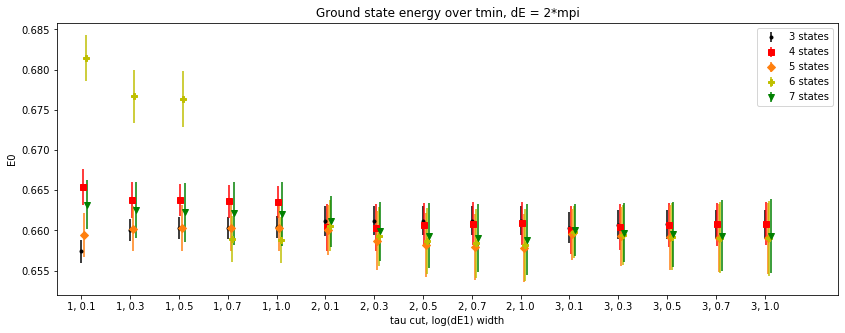

<Figure size 432x288 with 0 Axes>

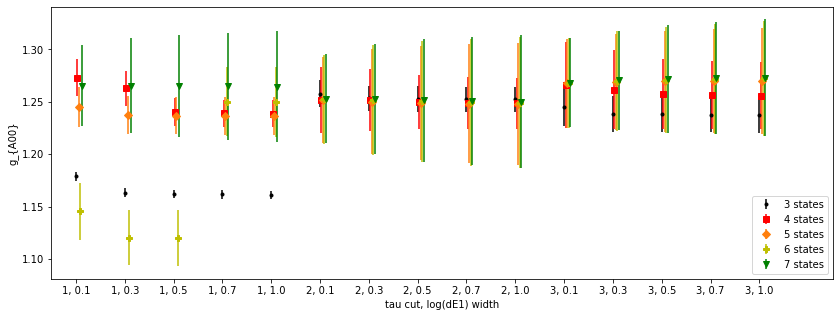

<Figure size 432x288 with 0 Axes>

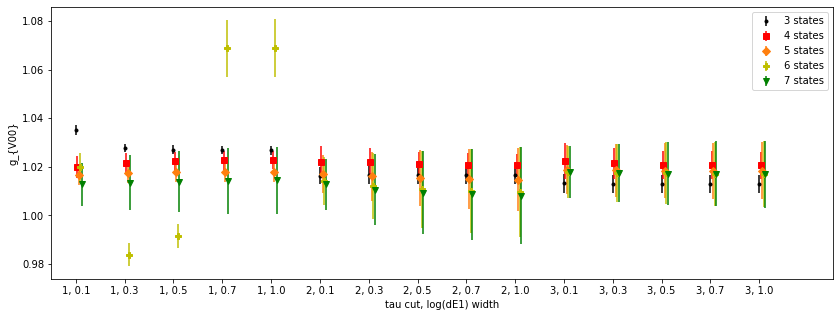

<Figure size 432x288 with 0 Axes>

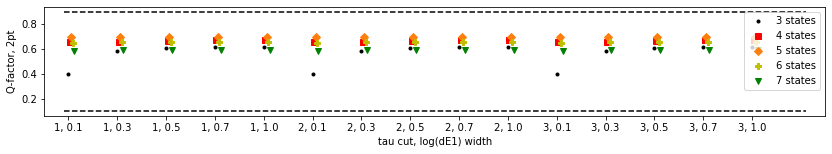

<Figure size 432x288 with 0 Axes>

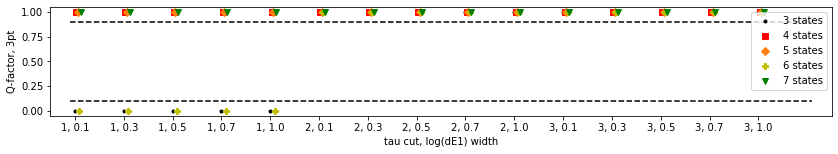

<Figure size 432x288 with 0 Axes>

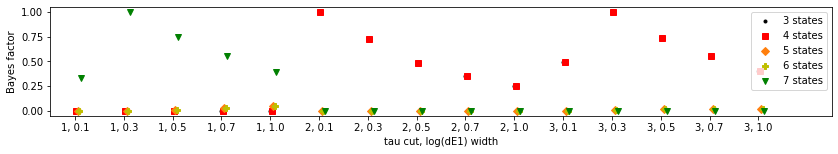

<Figure size 432x288 with 0 Axes>

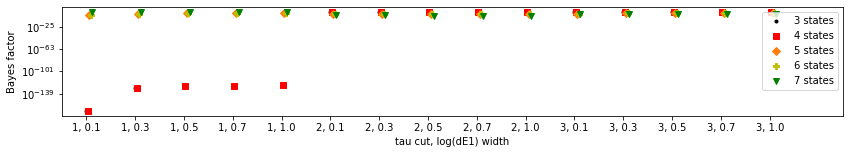

<Figure size 432x288 with 0 Axes>

In [87]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])





# Set an x-array to map the results to the graph
ax_ensemble_to_x_map = np.arange(0, 15, 1)
xticlocs = np.arange(0, 15, 1)
xticklabels = np.array(["1, 0.1", \
                        "1, 0.3", \
                        "1, 0.5", \
                        "1, 0.7", \
                        "1, 1.0", \
                        "2, 0.1", \
                        "2, 0.3", \
                        "2, 0.5", \
                        "2, 0.7", \
                        "2, 1.0", \
                        "3, 0.1", \
                        "3, 0.3", \
                        "3, 0.5", \
                        "3, 0.7", \
                        "3, 1.0"])



# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a0_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a0_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a0_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()


# Next, create the figure
#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a0_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

<Figure size 432x288 with 0 Axes>

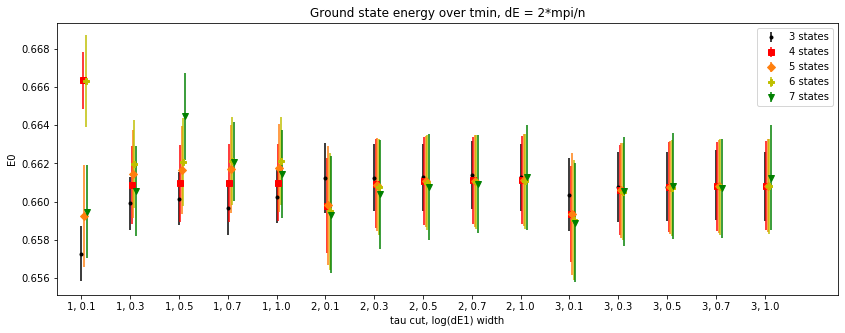

<Figure size 432x288 with 0 Axes>

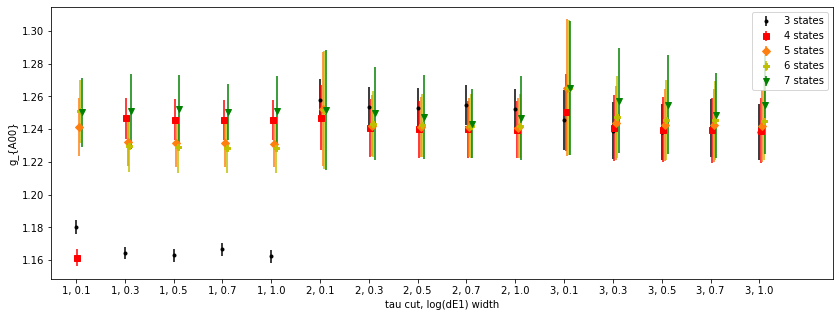

<Figure size 432x288 with 0 Axes>

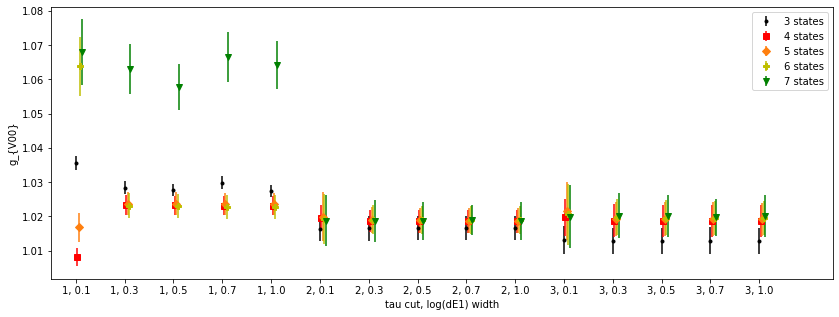

<Figure size 432x288 with 0 Axes>

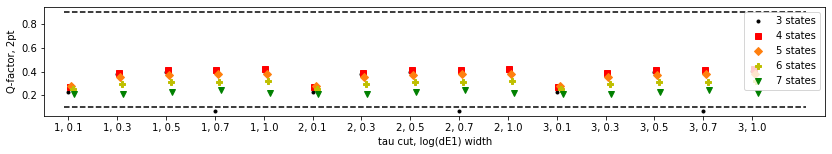

<Figure size 432x288 with 0 Axes>

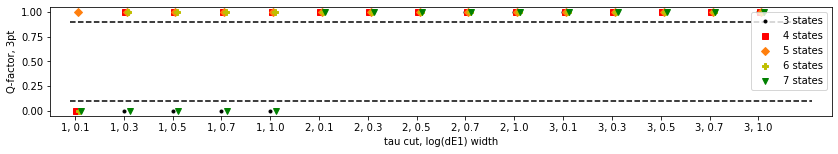

<Figure size 432x288 with 0 Axes>

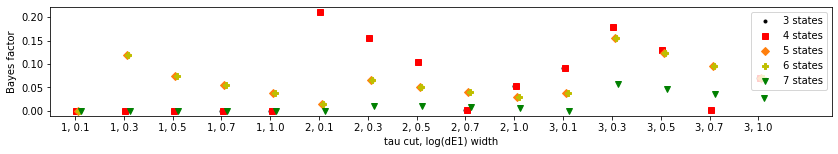

<Figure size 432x288 with 0 Axes>

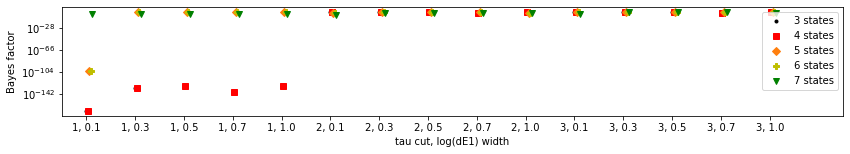

<Figure size 432x288 with 0 Axes>

In [88]:
# Now, 1/n
# Next, create the figure
#E0
plt.clf()
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a1_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a1_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a1_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a1_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()



# Next, create the figure
#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a1_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

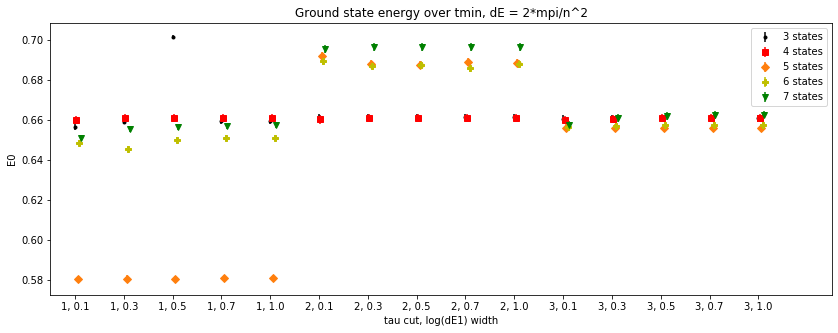

<Figure size 432x288 with 0 Axes>

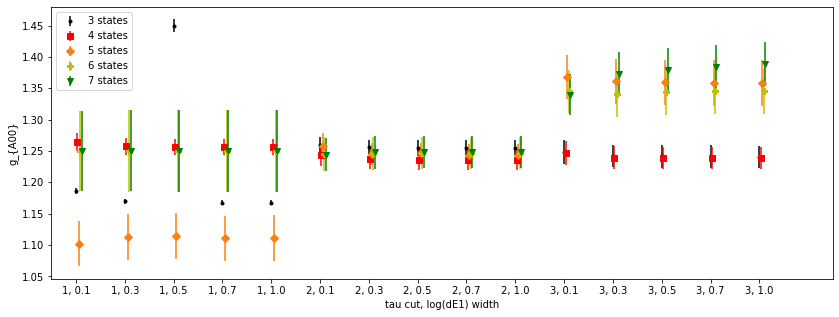

<Figure size 432x288 with 0 Axes>

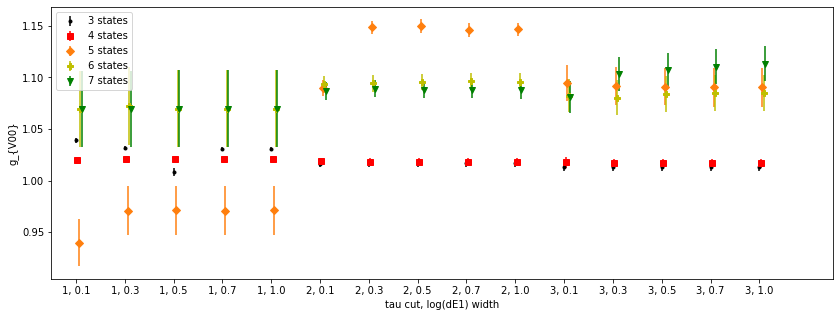

<Figure size 432x288 with 0 Axes>

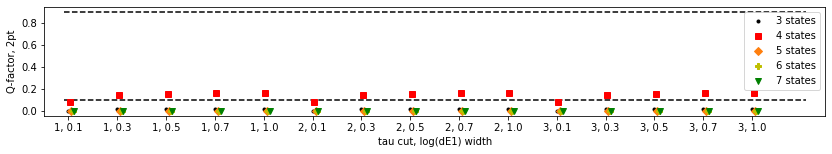

<Figure size 432x288 with 0 Axes>

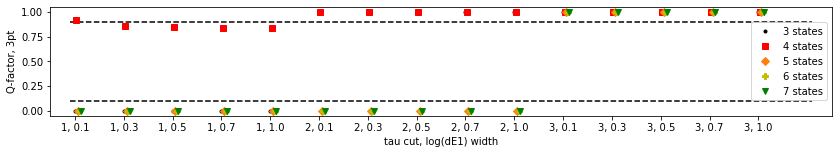

<Figure size 432x288 with 0 Axes>

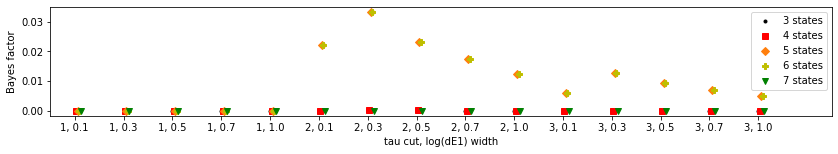

<Figure size 432x288 with 0 Axes>

In [89]:
# Now, 1/n^2
# Next, create the figure
#E0
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

# Now loop over the number of states used in 3-point
for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [E0_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [E0_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2")
plt.ylabel("E0")

plt.legend()
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gA00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gA00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{A00}")
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,5))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [gV00_a2_graph[i][k*2].mean for i in range(len(ax_ensemble_to_x_map))], yerr = [gV00_a2_graph[i][k*2].sdev for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
    
plt.legend()
plt.ylabel("g_{V00}")
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor, 2pt")
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [Q_a2_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
plt.legend()
plt.ylabel("Q-factor, 3pt")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,2))
plt.xlim([-0.5, 15.5])
plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("tau cut, log(dE1) width")

for k in range(len(n_z_vals)):
    plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor")
plt.show()

plt.clf()

# Next, create the figure
#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_2pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend()
#plt.ylabel("Bayes factor, 2pt")
#plt.show()

#plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for k in range(len(n_z_vals)):
    #plt.errorbar(ax_ensemble_to_x_map + k*0.03, [BF_a2_3pt_graph[i][k*2] for i in range(len(ax_ensemble_to_x_map))], fmt='.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend()
#plt.ylabel("Bayes factor, 3pt")
#plt.show()

## Now, do an analysis over the effects of t_min and the number of states on the fit results

Also, create .obj files to use as p0 values for the simultaneous-fit version

In [90]:
# Parameters outlining the 3-point t_min and number of states sampled over
tmin_range = np.arange(3, 11, 1)
numstates_range = np.arange(3, 8, 1)

In [102]:
# Create the datasets for each of the tmins'
x_all_dicts_2pt = []
y_all_dicts_2pt = []
x_all_dicts_3pt = []
y_all_dicts_3pt = []

for i in range(len(tmin_range)):
    temp_x_2pt = gv.BufferDict()
    temp_y_2pt = gv.BufferDict()
    temp_x_3pt = gv.BufferDict()
    temp_y_3pt = gv.BufferDict()
    
    x_all_dicts_2pt.append(temp_x_2pt)
    y_all_dicts_2pt.append(temp_y_2pt)
    x_all_dicts_3pt.append(temp_x_3pt)
    y_all_dicts_3pt.append(temp_y_3pt)
    
    x_2pt = np.array([l for l in range(2, 13)])
    x_3pt_uncut = t_1d_array
    
    y_2pt_SS = np.array([ gv_avg_data['2pt_SS'][l] for l in range(2,13)])
    y_2pt_PS = np.array([ gv_avg_data['2pt_PS'][l] for l in range(2,13)])
    y_2pt_all = np.transpose(np.array([[y_2pt_SS], [y_2pt_PS]]), axes=[2,0,1])
    y_3pt_A3_2d = np.array([ [gv_avg_data['3pt_A3'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
    y_3pt_A3 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_A3_2d)
    y_3pt_V4_2d = np.array([ [gv_avg_data['3pt_V4'][i][j] for j in range(1, i+tsep_vals[0])] for i in range(len(tsep_vals))])
    y_3pt_V4 = convert_2dto1d(t_1d_array, t_2d_array, y_3pt_V4_2d)
    y_3pt_all_uncut = np.transpose(np.array([[y_3pt_A3], [y_3pt_V4]]), axes=[2,0,1])
    
    x_3pt = []
    y_3pt_all = []
    for k in range(len(x_3pt_uncut)):
        if x_3pt_uncut[k][1] <= x_3pt_uncut[k][0]/2.:
            if x_3pt_uncut[k][0] >= tmin_range[i]:
                x_3pt.append(x_3pt_uncut[k].tolist())
                y_3pt_all.append(y_3pt_all_uncut[k].tolist())
            
    x_3pt = np.array(x_3pt)
    y_3pt_all = np.array(y_3pt_all)


    x_all_dicts_2pt[i]['2pt'] = x_2pt
    x_all_dicts_3pt[i]['3pt'] = x_3pt

    y_all_dicts_2pt[i]['2pt'] = y_2pt_all
    y_all_dicts_3pt[i]['3pt'] = y_3pt_all
    


In [103]:
# Now, define the priors

priors = []

for i in range(len(numstates_range)):
    priors.append([])
    
    priors[i].append(gv.BufferDict())
    priors[i].append(gv.BufferDict())
    priors[i].append(gv.BufferDict())
    
    num_zs = numstates_range[i]
    
    priors[i][0] = h5_dm.prior(num_zs, 2, 0.7, 0)
    priors[i][1] = h5_dm.prior(num_zs, 2, 0.7, 1)
    priors[i][2] = h5_dm.prior(num_zs, 2, 0.7, 2)


In [115]:
list_LogGBF_2pt_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_LogGBF_3pt_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_Q_2pt_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_Q_3pt_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_E0_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gA00_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gV00_a0 = np.array([[None]*len(numstates_range)]*len(tmin_range))

list_LogGBF_2pt_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_LogGBF_3pt_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_Q_2pt_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_Q_3pt_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_E0_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gA00_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gV00_a1 = np.array([[None]*len(numstates_range)]*len(tmin_range))

list_LogGBF_2pt_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_LogGBF_3pt_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_Q_2pt_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_Q_3pt_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_E0_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gA00_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gV00_a2 = np.array([[None]*len(numstates_range)]*len(tmin_range))


In [116]:
#Now, do the fit
for i in range(len(tmin_range)):
    for j in range(len(numstates_range)):
            num_zs = numstates_range[j]
            
            #print(np.shape(x_all_dicts_2pt[i]))
            #print(np.shape(all_at_once_dict(x_all_dicts_2pt[i], priors[0][0])))
            #print(np.shape())
            
            fit_a0_2pt = lsqfit.nonlinear_fit(data=(x_all_dicts_2pt[i], y_all_dicts_2pt[i] ), prior=priors[j][0],fcn=all_at_once_dict,debug=True, maxit=10000)
            fit_a1_2pt = lsqfit.nonlinear_fit(data=(x_all_dicts_2pt[i], y_all_dicts_2pt[i] ), prior=priors[j][1],fcn=all_at_once_dict,debug=True, maxit=10000)
            fit_a2_2pt = lsqfit.nonlinear_fit(data=(x_all_dicts_2pt[i], y_all_dicts_2pt[i] ), prior=priors[j][2],fcn=all_at_once_dict,debug=True, maxit=10000)
                
            fit_a0 = lsqfit.nonlinear_fit(data=(x_all_dicts_3pt[i], y_all_dicts_3pt[i] ), prior=fit_a0_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)
            fit_a1 = lsqfit.nonlinear_fit(data=(x_all_dicts_3pt[i], y_all_dicts_3pt[i] ), prior=fit_a1_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)
            fit_a2 = lsqfit.nonlinear_fit(data=(x_all_dicts_3pt[i], y_all_dicts_3pt[i] ), prior=fit_a2_2pt.p,fcn=all_at_once_dict,debug=True, maxit=10000)
            
            print("dE constant, tmin range: (", tmin_range[i], ", 12); num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a0.format(100))    
            list_LogGBF_2pt_a0[i][j] = fit_a0_2pt.logGBF
            list_LogGBF_3pt_a0[i][j] = fit_a0.logGBF
            list_Q_2pt_a0[i][j] = fit_a0_2pt.Q
            list_Q_3pt_a0[i][j] = fit_a0.Q
            list_E0_a0[i][j] = fit_a0.p['E0']
            list_gA00_a0[i][j] = fit_a0.p['gA3_00']
            list_gV00_a0[i][j] = fit_a0.p['gV4_00']
            
            print("dE proportional to 1/n, tmin range: (", tmin_range[i], ", 12); num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a1.format(100)) 
            list_LogGBF_2pt_a1[i][j] = fit_a1_2pt.logGBF
            list_LogGBF_3pt_a1[i][j] = fit_a1.logGBF
            list_Q_2pt_a1[i][j] = fit_a1_2pt.Q
            list_Q_3pt_a1[i][j] = fit_a1.Q
            list_E0_a1[i][j] = fit_a1.p['E0']
            list_gA00_a1[i][j] = fit_a1.p['gA3_00']
            list_gV00_a1[i][j] = fit_a1.p['gV4_00']
                
            print("dE proportional to 1/n^2, tmin range: (", tmin_range[i], ", 12); num_zs = ", num_zs, " num_states_FH = ", num_states_FH)
            print(fit_a2.format(100)) 
            list_LogGBF_2pt_a2[i][j] = fit_a2_2pt.logGBF
            list_LogGBF_3pt_a2[i][j] = fit_a2.logGBF
            list_Q_2pt_a2[i][j] = fit_a2_2pt.Q
            list_Q_3pt_a2[i][j] = fit_a2.Q
            list_E0_a2[i][j] = fit_a2.p['E0']
            list_gA00_a2[i][j] = fit_a2.p['gA3_00']
            list_gV00_a2[i][j] = fit_a2.p['gV4_00']
            
            # Pickle the fit results for chained so that they can be used as p0 for simultaneous
            current_posterior_a0 = open('chained_2pt_3pt_dEconst_tmin_{0}_nstates_{1}.obj'.format(tmin_range[i], num_zs), 'wb')
            pickle.dump(fit_a0.p, current_posterior_a0)
            current_posterior_a0.close()
            
            current_posterior_a1 = open('chained_2pt_3pt_dE1overn_tmin_{0}_nstates_{1}.obj'.format(tmin_range[i], num_zs), 'wb')
            pickle.dump(fit_a1.p, current_posterior_a1)
            current_posterior_a1.close()
            
            current_posterior_a2 = open('chained_2pt_3pt_dE1overn2_tmin_{0}_nstates_{1}.obj'.format(tmin_range[i], num_zs), 'wb')
            pickle.dump(fit_a2.p, current_posterior_a2)
            current_posterior_a2.close()

dE constant, tmin range: ( 3 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 14 [70]    Q = 2.7e-157    logGBF = 1371.8

Parameters:
             E0         0.6594 (14)        [    0.6614 (18) ]  *
             Z0      0.0007448 (42)        [ 0.0007586 (59) ]  **
        Ztilde0       0.002818 (19)        [  0.002870 (28) ]  *
             Z1      0.0010003 (93)        [  0.000711 (42) ]  *****
        Ztilde1       0.006627 (81)        [   0.00487 (32) ]  *****
             Z2      0.0016499 (80)        [  0.001328 (22) ]  *****
        Ztilde2       0.012896 (77)        [   0.00986 (22) ]  *****
       log(dE1)         -0.537 (20)        [    -0.756 (66) ]  ***
       log(dE2)         0.5848 (51)        [    -0.107 (53) ]  *****
         gA3_10        -0.0123 (47)        [      0.0 (1.0) ]  
         gV4_10        0.05017 (96)        [      0.0 (1.0) ]  
         gA3_11          0.671 (11)        [      0.0 (1.0) ]  
         gV4_11         0.8335 (79)    

Least Square Fit:
  chi2/dof [dof] = 14 [70]    Q = 1.3e-161    logGBF = 1361

Parameters:
             E0         0.6589 (14)        [    0.6614 (19) ]  *
             Z0      0.0007427 (42)        [ 0.0007588 (59) ]  **
        Ztilde0       0.002808 (19)        [  0.002870 (28) ]  **
             Z1      0.0010011 (93)        [  0.000705 (43) ]  *****
        Ztilde1       0.006595 (80)        [   0.00484 (32) ]  *****
             Z2      0.0016424 (79)        [  0.001325 (21) ]  *****
        Ztilde2       0.012860 (75)        [   0.00983 (22) ]  *****
       log(dE1)         -0.549 (20)        [    -0.762 (66) ]  ***
       log(dE2)         0.5856 (51)        [    -0.114 (52) ]  *****
         gA3_10        -0.0138 (46)        [      0.0 (1.0) ]  
         gV4_10        0.04957 (94)        [      0.0 (1.0) ]  
         gA3_11          0.669 (10)        [      0.0 (1.0) ]  
         gV4_11         0.8260 (77)        [      1.00 (20) ]  
         gA3_20         0.7150 (74)        [

Least Square Fit:
  chi2/dof [dof] = 1.6 [70]    Q = 0.00055    logGBF = 1781.1

Parameters:
             E0         0.6598 (18)        [    0.6612 (20) ]  
             Z0      0.0007499 (56)        [ 0.0007581 (65) ]  *
        Ztilde0       0.002820 (26)        [  0.002867 (31) ]  *
             Z1       0.000585 (27)        [  0.000706 (43) ]  **
        Ztilde1        0.00377 (20)        [   0.00482 (34) ]  ***
             Z2       0.000931 (61)        [   0.00121 (15) ]  *
        Ztilde2        0.00899 (82)        [   0.00932 (84) ]  
       log(dE1)         -0.965 (44)        [    -0.765 (70) ]  **
       log(dE2)         -0.337 (37)        [    -0.129 (57) ]  ***
       log(dE3)          1.008 (65)        [     -2.05 (70) ]  ****
             Z3        0.00114 (15)        [   0.00056 (35) ]  *
        Ztilde3         0.0038 (19)        [    0.0033 (19) ]  
         gA3_10         -0.270 (40)        [      0.0 (1.0) ]  
         gV4_10        -0.0039 (55)        [      0.0 (1.

dE constant, tmin range: ( 3 , 12); num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 2.6e+03 [70]    Q = 0    logGBF = -90650

Parameters:
             E0         0.6600 (20)        [    0.6609 (23) ]  
             Z0      0.0006199 (68)        [ 0.0007567 (79) ]  *****
        Ztilde0       0.002281 (31)        [  0.002861 (37) ]  *****
             Z1       0.000456 (39)        [  0.000698 (46) ]  *****
        Ztilde1        0.00379 (32)        [   0.00472 (40) ]  **
             Z2        0.00099 (12)        [   0.00118 (13) ]  *
        Ztilde2        0.00808 (75)        [   0.00903 (79) ]  *
       log(dE1)         -0.781 (66)        [    -0.782 (83) ]  
       log(dE2)         -0.169 (72)        [    -0.178 (78) ]  
       log(dE3)          -1.08 (59)        [     -1.08 (70) ]  
             Z3        0.00072 (33)        [   0.00053 (34) ]  
        Ztilde3         0.0020 (19)        [    0.0033 (19) ]  
       log(dE4)          -1.05 (61)        [     -1.05

Least Square Fit:
  chi2/dof [dof] = 3.3e+02 [70]    Q = 0    logGBF = -9718.7

Parameters:
             E0        0.6955 (12)        [    0.6640 (14) ]  *****
             Z0     0.0008250 (31)        [ 0.0007771 (40) ]  *****
        Ztilde0      0.003255 (15)        [  0.002938 (18) ]  *****
             Z1     -0.000146 (50)        [  0.000098 (89) ]  **
        Ztilde1        0.0389 (30)        [    0.0127 (30) ]  *****
             Z2     -0.000652 (61)        [  -0.00016 (12) ]  ****
        Ztilde2       -0.0653 (30)        [    0.0145 (30) ]  *****
       log(dE1)        -0.036 (90)        [     -0.91 (24) ]  ***
       log(dE2)         -1.27 (44)        [     -1.63 (54) ]  
       log(dE3)         -1.76 (55)        [     -2.05 (59) ]  
             Z3       0.00002 (38)        [  -0.00003 (39) ]  
        Ztilde3       -0.0007 (20)        [    0.0026 (20) ]  *
       log(dE4)         -2.10 (62)        [     -2.34 (64) ]  
             Z4      0.001431 (10)        [  0.001214 

Least Square Fit:
  chi2/dof [dof] = 6.6e+03 [70]    Q = 0    logGBF = -2.2778e+05

Parameters:
             E0         0.6594 (14)        [    0.6736 (19) ]  *****
             Z0      0.0004726 (43)        [ 0.0008032 (58) ]  *****
        Ztilde0       0.001730 (19)        [  0.003080 (25) ]  *****
             Z1        0.00024 (10)        [   0.00049 (15) ]  *
        Ztilde1         0.0061 (11)        [    0.0061 (12) ]  
             Z2        0.00049 (23)        [   0.00065 (23) ]  
        Ztilde2        -0.0039 (28)        [   -0.0032 (28) ]  
       log(dE1)         -0.516 (84)        [    -0.520 (98) ]  
       log(dE2)          -0.93 (17)        [     -0.94 (19) ]  
       log(dE3)          -2.75 (63)        [     -2.75 (64) ]  
             Z3        0.00025 (38)        [   0.00032 (38) ]  
        Ztilde3         0.0030 (20)        [    0.0036 (20) ]  
       log(dE4)          -3.60 (69)        [     -3.60 (69) ]  
             Z4        0.00090 (19)        [   0.00101 (

dE constant, tmin range: ( 3 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2e+03 [70]    Q = 0    logGBF = -39320

Parameters:
             E0         0.6701 (21)        [    0.6608 (23) ]  ***
             Z0      0.0006822 (72)        [ 0.0007562 (83) ]  *****
        Ztilde0       0.002588 (33)        [  0.002858 (38) ]  *****
             Z1       0.000539 (43)        [  0.000691 (48) ]  ***
        Ztilde1        0.00323 (35)        [   0.00466 (42) ]  ***
             Z2        0.00094 (13)        [   0.00114 (14) ]  *
        Ztilde2        0.00983 (83)        [   0.00877 (88) ]  *
       log(dE1)         -0.791 (73)        [    -0.792 (88) ]  
       log(dE2)         -0.193 (82)        [    -0.206 (87) ]  
       log(dE3)          -1.12 (62)        [     -1.12 (69) ]  
             Z3        0.00045 (34)        [   0.00052 (35) ]  
        Ztilde3         0.0021 (19)        [    0.0033 (19) ]  
       log(dE4)          -1.10 (62)        [     -1.

Least Square Fit:
  chi2/dof [dof] = 1.1e+04 [70]    Q = 0    logGBF = -3.8262e+05

Parameters:
             E0         0.6338 (11)        [    0.6421 (17) ]  ****
             Z0      0.0003226 (31)        [ 0.0006952 (47) ]  *****
        Ztilde0       0.001270 (15)        [  0.002651 (21) ]  *****
             Z1       -0.00005 (14)        [    -3(164)e-06 ]  
        Ztilde1         0.0048 (30)        [    0.0047 (30) ]  
             Z2      -0.000157 (75)        [ -0.000177 (81) ]  
        Ztilde2         0.0216 (30)        [    0.0213 (30) ]  
       log(dE1)          -0.86 (17)        [     -0.86 (17) ]  
       log(dE2)          -2.33 (68)        [     -2.33 (68) ]  
       log(dE3)          -3.16 (62)        [     -3.16 (65) ]  
             Z3       -0.00005 (38)        [  -0.00002 (39) ]  
        Ztilde3         0.0027 (20)        [    0.0026 (20) ]  
       log(dE4)          -3.74 (68)        [     -3.74 (68) ]  
             Z4       -0.00003 (38)        [    -1(390)e-0

dE constant, tmin range: ( 3 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 6.7e+02 [70]    Q = 0    logGBF = -21675

Parameters:
             E0        0.6811 (21)        [    0.6607 (24) ]  *****
             Z0     0.0007029 (74)        [ 0.0007559 (85) ]  *****
        Ztilde0      0.002705 (34)        [  0.002857 (39) ]  ***
             Z1      0.000596 (45)        [  0.000686 (50) ]  *
        Ztilde1       0.00294 (37)        [   0.00462 (43) ]  ***
             Z2       0.00091 (14)        [   0.00112 (15) ]  *
        Ztilde2       0.01036 (88)        [   0.00860 (95) ]  *
       log(dE1)        -0.800 (78)        [    -0.800 (91) ]  
       log(dE2)        -0.214 (88)        [    -0.226 (95) ]  
       log(dE3)         -1.15 (64)        [     -1.15 (69) ]  
             Z3       0.00036 (35)        [   0.00052 (35) ]  
        Ztilde3        0.0024 (19)        [    0.0034 (19) ]  
       log(dE4)         -1.14 (64)        [     -1.14 (70) ]  
   

Least Square Fit:
  chi2/dof [dof] = 1.1e+04 [70]    Q = 0    logGBF = -3.8919e+05

Parameters:
             E0         0.6342 (12)        [    0.6422 (17) ]  ****
             Z0      0.0003252 (32)        [ 0.0006957 (47) ]  *****
        Ztilde0       0.001286 (15)        [  0.002653 (21) ]  *****
             Z1       -0.00005 (13)        [     4(148)e-06 ]  
        Ztilde1         0.0049 (30)        [    0.0049 (30) ]  
             Z2      -0.000148 (76)        [ -0.000162 (83) ]  
        Ztilde2         0.0208 (30)        [    0.0205 (30) ]  
       log(dE1)          -0.88 (18)        [     -0.88 (18) ]  
       log(dE2)          -2.34 (68)        [     -2.34 (68) ]  
       log(dE3)          -3.16 (65)        [     -3.16 (66) ]  
             Z3       -0.00005 (37)        [  -0.00003 (39) ]  
        Ztilde3         0.0032 (20)        [    0.0031 (20) ]  
       log(dE4)          -3.74 (68)        [     -3.74 (69) ]  
             Z4       -0.00004 (38)        [  -0.00001 (39

dE constant, tmin range: ( 4 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 11 [68]    Q = 1.6e-110    logGBF = 1450.2

Parameters:
             E0         0.6607 (13)        [    0.6614 (18) ]  
             Z0      0.0007577 (39)        [ 0.0007586 (59) ]  
        Ztilde0       0.002898 (18)        [  0.002870 (28) ]  *
             Z1       0.001146 (13)        [  0.000711 (42) ]  *****
        Ztilde1        0.00787 (11)        [   0.00487 (32) ]  *****
             Z2      0.0016005 (85)        [  0.001328 (22) ]  *****
        Ztilde2       0.012468 (77)        [   0.00986 (22) ]  *****
       log(dE1)         -0.231 (26)        [    -0.756 (66) ]  *****
       log(dE2)         0.5812 (67)        [    -0.107 (53) ]  *****
         gA3_10         0.0252 (50)        [      0.0 (1.0) ]  
         gV4_10         0.0622 (20)        [      0.0 (1.0) ]  
         gA3_11          0.905 (33)        [      0.0 (1.0) ]  
         gV4_11          1.174 (45)     

dE constant, tmin range: ( 4 , 12); num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [68]    Q = 0.059    logGBF = 1750.7

Parameters:
             E0         0.6589 (19)        [    0.6611 (21) ]  *
             Z0      0.0007468 (62)        [ 0.0007574 (73) ]  *
        Ztilde0       0.002810 (28)        [  0.002864 (34) ]  *
             Z1       0.000601 (30)        [  0.000705 (44) ]  **
        Ztilde1        0.00377 (22)        [   0.00479 (37) ]  **
             Z2       0.000938 (70)        [   0.00123 (11) ]  **
        Ztilde2        0.00871 (62)        [   0.00939 (65) ]  *
       log(dE1)         -0.958 (50)        [    -0.770 (76) ]  **
       log(dE2)         -0.373 (42)        [    -0.143 (66) ]  ***
       log(dE3)          1.035 (72)        [     -1.02 (70) ]  **
             Z3        0.00145 (21)        [   0.00054 (32) ]  **
        Ztilde3         0.0054 (18)        [    0.0032 (19) ]  *
         gA3_10         -0.278 (42)        [      0.0

dE constant, tmin range: ( 4 , 12); num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [68]    Q = 0.42    logGBF = 1753.2

Parameters:
             E0         0.6606 (21)        [    0.6609 (23) ]  
             Z0      0.0007549 (70)        [ 0.0007567 (79) ]  
        Ztilde0       0.002848 (32)        [  0.002861 (37) ]  
             Z1       0.000667 (36)        [  0.000698 (46) ]  
        Ztilde1        0.00453 (31)        [   0.00472 (40) ]  
             Z2        0.00134 (11)        [   0.00118 (13) ]  *
        Ztilde2        0.00904 (74)        [   0.00903 (79) ]  
       log(dE1)         -0.820 (64)        [    -0.782 (83) ]  
       log(dE2)         -0.203 (67)        [    -0.178 (78) ]  
       log(dE3)          -0.63 (57)        [     -1.08 (70) ]  
             Z3       -0.00033 (26)        [   0.00053 (34) ]  **
        Ztilde3         0.0033 (19)        [    0.0033 (19) ]  
       log(dE4)           0.38 (38)        [     -1.05 (70) ]  **
       

Least Square Fit:
  chi2/dof [dof] = 5.7e+03 [68]    Q = 0    logGBF = -1.9079e+05

Parameters:
             E0         0.6296 (10)        [    0.6640 (14) ]  *****
             Z0      0.0003205 (29)        [ 0.0007771 (40) ]  *****
        Ztilde0       0.001161 (15)        [  0.002938 (18) ]  *****
             Z1      -0.000014 (74)        [  0.000098 (89) ]  *
        Ztilde1         0.0106 (29)        [    0.0127 (30) ]  
             Z2       -0.00010 (11)        [  -0.00016 (12) ]  
        Ztilde2         0.0154 (30)        [    0.0145 (30) ]  
       log(dE1)          -0.91 (20)        [     -0.91 (24) ]  
       log(dE2)          -1.63 (48)        [     -1.63 (54) ]  
       log(dE3)          -2.05 (58)        [     -2.05 (59) ]  
             Z3        0.00001 (35)        [  -0.00003 (39) ]  
        Ztilde3         0.0026 (20)        [    0.0026 (20) ]  
       log(dE4)          -2.34 (64)        [     -2.34 (64) ]  
             Z4       0.000818 (16)        [  0.001214 (

dE constant, tmin range: ( 4 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.9 [68]    Q = 0.71    logGBF = 1756.8

Parameters:
             E0         0.6596 (21)        [    0.6608 (23) ]  
             Z0      0.0007515 (72)        [ 0.0007562 (83) ]  
        Ztilde0       0.002836 (33)        [  0.002858 (38) ]  
             Z1       0.000680 (39)        [  0.000691 (48) ]  
        Ztilde1        0.00449 (32)        [   0.00466 (42) ]  
             Z2        0.00112 (11)        [   0.00114 (14) ]  
        Ztilde2        0.00876 (80)        [   0.00877 (88) ]  
       log(dE1)         -0.823 (67)        [    -0.792 (88) ]  
       log(dE2)         -0.247 (71)        [    -0.206 (87) ]  
       log(dE3)          -0.53 (54)        [     -1.12 (69) ]  
             Z3        0.00058 (30)        [   0.00052 (35) ]  
        Ztilde3         0.0039 (19)        [    0.0033 (19) ]  
       log(dE4)          -0.52 (63)        [     -1.11 (70) ]  
          

Least Square Fit:
  chi2/dof [dof] = 5.5e+03 [68]    Q = 0    logGBF = -1.8393e+05

Parameters:
             E0         0.6399 (11)        [    0.6693 (15) ]  *****
             Z0      0.0003462 (33)        [ 0.0007930 (44) ]  *****
        Ztilde0       0.001255 (15)        [  0.002998 (19) ]  *****
             Z1          -3(77)e-06        [  0.000114 (93) ]  *
        Ztilde1         0.0090 (29)        [    0.0112 (30) ]  
             Z2       -0.00010 (13)        [  -0.00015 (14) ]  
        Ztilde2         0.0118 (30)        [    0.0111 (30) ]  
       log(dE1)          -0.93 (19)        [     -0.93 (22) ]  
       log(dE2)          -1.65 (48)        [     -1.65 (52) ]  
       log(dE3)          -2.06 (61)        [     -2.06 (61) ]  
             Z3       -0.00002 (36)        [  -0.00006 (38) ]  
        Ztilde3         0.0033 (20)        [    0.0032 (20) ]  
       log(dE4)          -2.35 (65)        [     -2.35 (65) ]  
             Z4        0.00007 (34)        [  -0.00001 (

Least Square Fit:
  chi2/dof [dof] = 7.2e+03 [68]    Q = 0    logGBF = -2.4296e+05

Parameters:
             E0         0.6202 (12)        [    0.6421 (17) ]  *****
             Z0      0.0002733 (33)        [ 0.0006952 (47) ]  *****
        Ztilde0       0.001036 (15)        [  0.002651 (21) ]  *****
             Z1       -0.00005 (14)        [    -3(164)e-06 ]  
        Ztilde1         0.0048 (30)        [    0.0047 (30) ]  
             Z2      -0.000125 (75)        [ -0.000177 (81) ]  
        Ztilde2         0.0228 (30)        [    0.0213 (30) ]  
       log(dE1)          -0.86 (17)        [     -0.86 (17) ]  
       log(dE2)          -2.33 (68)        [     -2.33 (68) ]  
       log(dE3)          -3.16 (62)        [     -3.16 (65) ]  
             Z3       -0.00003 (38)        [  -0.00002 (39) ]  
        Ztilde3         0.0027 (20)        [    0.0026 (20) ]  
       log(dE4)          -3.74 (68)        [     -3.74 (68) ]  
             Z4       -0.00001 (38)        [    -1(390)e-

dE constant, tmin range: ( 4 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [68]    Q = 0.78    logGBF = 1757

Parameters:
             E0         0.6598 (22)        [    0.6607 (24) ]  
             Z0      0.0007519 (74)        [ 0.0007559 (85) ]  
        Ztilde0       0.002837 (34)        [  0.002857 (39) ]  
             Z1       0.000673 (41)        [  0.000686 (50) ]  
        Ztilde1        0.00446 (33)        [   0.00462 (43) ]  
             Z2        0.00109 (12)        [   0.00112 (15) ]  
        Ztilde2        0.00844 (86)        [   0.00860 (95) ]  
       log(dE1)         -0.830 (71)        [    -0.800 (91) ]  
       log(dE2)         -0.266 (76)        [    -0.226 (95) ]  
       log(dE3)          -0.94 (63)        [     -1.15 (69) ]  
             Z3        0.00050 (32)        [   0.00052 (35) ]  
        Ztilde3         0.0038 (19)        [    0.0034 (19) ]  
       log(dE4)          -0.80 (63)        [     -1.14 (70) ]  
           

Least Square Fit:
  chi2/dof [dof] = 5.1e+03 [68]    Q = 0    logGBF = -1.6999e+05

Parameters:
             E0         0.6443 (13)        [    0.6732 (18) ]  *****
             Z0      0.0003694 (45)        [ 0.0008036 (57) ]  *****
        Ztilde0       0.001328 (19)        [  0.003037 (23) ]  *****
             Z1       0.000025 (86)        [   0.00017 (10) ]  *
        Ztilde1         0.0061 (27)        [    0.0085 (29) ]  
             Z2       -0.00011 (14)        [  -0.00017 (15) ]  
        Ztilde2         0.0082 (29)        [    0.0079 (30) ]  
       log(dE1)          -0.93 (16)        [     -0.93 (17) ]  
       log(dE2)          -1.64 (46)        [     -1.64 (48) ]  
       log(dE3)          -2.06 (62)        [     -2.06 (62) ]  
             Z3       -0.00004 (36)        [  -0.00007 (38) ]  
        Ztilde3         0.0029 (20)        [    0.0029 (20) ]  
       log(dE4)          -2.35 (65)        [     -2.35 (65) ]  
             Z4        0.00004 (36)        [  -0.00001 (

Least Square Fit:
  chi2/dof [dof] = 7.2e+03 [68]    Q = 0    logGBF = -2.4465e+05

Parameters:
             E0         0.6218 (12)        [    0.6422 (17) ]  *****
             Z0      0.0002755 (33)        [ 0.0006957 (47) ]  *****
        Ztilde0       0.001050 (15)        [  0.002653 (21) ]  *****
             Z1       -0.00004 (13)        [     4(148)e-06 ]  
        Ztilde1         0.0049 (30)        [    0.0049 (30) ]  
             Z2      -0.000119 (76)        [ -0.000162 (83) ]  
        Ztilde2         0.0220 (30)        [    0.0205 (30) ]  
       log(dE1)          -0.88 (18)        [     -0.88 (18) ]  
       log(dE2)          -2.34 (68)        [     -2.34 (68) ]  
       log(dE3)          -3.16 (64)        [     -3.16 (66) ]  
             Z3       -0.00003 (38)        [  -0.00003 (39) ]  
        Ztilde3         0.0033 (20)        [    0.0031 (20) ]  
       log(dE4)          -3.74 (68)        [     -3.74 (69) ]  
             Z4       -0.00002 (38)        [  -0.00001 (3

dE constant, tmin range: ( 5 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 8.5 [64]    Q = 9.7e-78    logGBF = 1444.2

Parameters:
             E0         0.6600 (14)        [    0.6614 (18) ]  
             Z0      0.0007581 (40)        [ 0.0007586 (59) ]  
        Ztilde0       0.002907 (18)        [  0.002870 (28) ]  *
             Z1       0.001199 (16)        [  0.000711 (42) ]  *****
        Ztilde1        0.00824 (12)        [   0.00487 (32) ]  *****
             Z2      0.0015706 (97)        [  0.001328 (22) ]  *****
        Ztilde2       0.012295 (82)        [   0.00986 (22) ]  *****
       log(dE1)         -0.143 (27)        [    -0.756 (66) ]  *****
       log(dE2)          0.573 (12)        [    -0.107 (53) ]  *****
         gA3_10         0.0274 (59)        [      0.0 (1.0) ]  
         gV4_10         0.0654 (27)        [      0.0 (1.0) ]  
         gA3_11          1.199 (81)        [      0.0 (1.0) ]  *
         gV4_11           1.78 (12)    

dE constant, tmin range: ( 5 , 12); num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [64]    Q = 0.049    logGBF = 1659.1

Parameters:
             E0         0.6591 (19)        [    0.6611 (21) ]  
             Z0      0.0007480 (63)        [ 0.0007574 (73) ]  *
        Ztilde0       0.002816 (29)        [  0.002864 (34) ]  *
             Z1       0.000613 (31)        [  0.000705 (44) ]  **
        Ztilde1        0.00388 (23)        [   0.00479 (37) ]  **
             Z2       0.000946 (79)        [   0.00123 (11) ]  **
        Ztilde2        0.00866 (62)        [   0.00939 (65) ]  *
       log(dE1)         -0.934 (51)        [    -0.770 (76) ]  **
       log(dE2)         -0.365 (43)        [    -0.143 (66) ]  ***
       log(dE3)          1.036 (85)        [     -1.02 (70) ]  **
             Z3        0.00143 (24)        [   0.00054 (32) ]  **
        Ztilde3         0.0056 (18)        [    0.0032 (19) ]  *
         gA3_10         -0.260 (41)        [      0.0 

dE constant, tmin range: ( 5 , 12); num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [64]    Q = 0.41    logGBF = 1663.4

Parameters:
             E0        0.6611 (21)        [    0.6609 (23) ]  
             Z0     0.0007570 (70)        [ 0.0007567 (79) ]  
        Ztilde0      0.002858 (32)        [  0.002861 (37) ]  
             Z1      0.000672 (35)        [  0.000698 (46) ]  
        Ztilde1       0.00462 (30)        [   0.00472 (40) ]  
             Z2       0.00136 (10)        [   0.00118 (13) ]  *
        Ztilde2       0.00901 (74)        [   0.00903 (79) ]  
       log(dE1)        -0.800 (63)        [    -0.782 (83) ]  
       log(dE2)        -0.197 (65)        [    -0.178 (78) ]  
       log(dE3)         -0.63 (60)        [     -1.08 (70) ]  
             Z3      -0.00034 (25)        [   0.00053 (34) ]  **
        Ztilde3        0.0033 (19)        [    0.0033 (19) ]  
       log(dE4)          0.35 (41)        [     -1.05 (70) ]  **
             Z4     

dE constant, tmin range: ( 5 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.91 [64]    Q = 0.69    logGBF = 1666.9

Parameters:
             E0         0.6601 (21)        [    0.6608 (23) ]  
             Z0      0.0007534 (73)        [ 0.0007562 (83) ]  
        Ztilde0       0.002844 (33)        [  0.002858 (38) ]  
             Z1       0.000686 (38)        [  0.000691 (48) ]  
        Ztilde1        0.00458 (31)        [   0.00466 (42) ]  
             Z2        0.00113 (11)        [   0.00114 (14) ]  
        Ztilde2        0.00869 (80)        [   0.00877 (88) ]  
       log(dE1)         -0.804 (66)        [    -0.792 (88) ]  
       log(dE2)         -0.241 (70)        [    -0.206 (87) ]  
       log(dE3)          -0.68 (58)        [     -1.12 (69) ]  
             Z3        0.00059 (30)        [   0.00052 (35) ]  
        Ztilde3         0.0039 (19)        [    0.0033 (19) ]  
       log(dE4)          -0.49 (63)        [     -1.11 (70) ]  
         

Least Square Fit:
  chi2/dof [dof] = 2.7e+03 [64]    Q = 0    logGBF = -85715

Parameters:
             E0         0.6226 (12)        [    0.6693 (15) ]  *****
             Z0      0.0003502 (35)        [ 0.0007930 (44) ]  *****
        Ztilde0       0.001285 (16)        [  0.002998 (19) ]  *****
             Z1      -0.000013 (78)        [  0.000114 (93) ]  *
        Ztilde1         0.0062 (29)        [    0.0112 (30) ]  *
             Z2       -0.00013 (13)        [  -0.00015 (14) ]  
        Ztilde2         0.0132 (30)        [    0.0111 (30) ]  
       log(dE1)          -0.93 (19)        [     -0.93 (22) ]  
       log(dE2)          -1.64 (49)        [     -1.65 (52) ]  
       log(dE3)          -2.06 (61)        [     -2.06 (61) ]  
             Z3       -0.00002 (37)        [  -0.00006 (38) ]  
        Ztilde3         0.0035 (20)        [    0.0032 (20) ]  
       log(dE4)          -2.35 (65)        [     -2.35 (65) ]  
             Z4        0.00014 (35)        [  -0.00001 (39) 

dE constant, tmin range: ( 5 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.87 [64]    Q = 0.76    logGBF = 1667.4

Parameters:
             E0         0.6602 (22)        [    0.6607 (24) ]  
             Z0      0.0007538 (75)        [ 0.0007559 (85) ]  
        Ztilde0       0.002846 (34)        [  0.002857 (39) ]  
             Z1       0.000681 (40)        [  0.000686 (50) ]  
        Ztilde1        0.00456 (32)        [   0.00462 (43) ]  
             Z2        0.00110 (12)        [   0.00112 (15) ]  
        Ztilde2        0.00842 (86)        [   0.00860 (95) ]  
       log(dE1)         -0.808 (70)        [    -0.800 (91) ]  
       log(dE2)         -0.257 (75)        [    -0.226 (95) ]  
       log(dE3)          -0.98 (63)        [     -1.15 (69) ]  
             Z3        0.00056 (32)        [   0.00052 (35) ]  
        Ztilde3         0.0039 (19)        [    0.0034 (19) ]  
       log(dE4)          -0.83 (64)        [     -1.14 (70) ]  
         

Least Square Fit:
  chi2/dof [dof] = 2.6e+03 [64]    Q = 0    logGBF = -80651

Parameters:
             E0         0.6346 (14)        [    0.6732 (18) ]  *****
             Z0      0.0003929 (46)        [ 0.0008036 (57) ]  *****
        Ztilde0       0.001436 (20)        [  0.003037 (23) ]  *****
             Z1       0.000011 (83)        [   0.00017 (10) ]  *
        Ztilde1         0.0048 (26)        [    0.0085 (29) ]  *
             Z2       -0.00016 (15)        [  -0.00017 (15) ]  
        Ztilde2         0.0086 (29)        [    0.0079 (30) ]  
       log(dE1)          -0.93 (16)        [     -0.93 (17) ]  
       log(dE2)          -1.64 (47)        [     -1.64 (48) ]  
       log(dE3)          -2.06 (62)        [     -2.06 (62) ]  
             Z3       -0.00007 (37)        [  -0.00007 (38) ]  
        Ztilde3         0.0030 (20)        [    0.0029 (20) ]  
       log(dE4)          -2.35 (65)        [     -2.35 (65) ]  
             Z4        0.00008 (37)        [  -0.00001 (39) 

Least Square Fit:
  chi2/dof [dof] = 4.5e+03 [64]    Q = 0    logGBF = -1.4131e+05

Parameters:
             E0        0.6135 (12)        [    0.6422 (17) ]  *****
             Z0     0.0002561 (34)        [ 0.0006957 (47) ]  *****
        Ztilde0      0.000977 (16)        [  0.002653 (21) ]  *****
             Z1      -0.00005 (13)        [     4(148)e-06 ]  
        Ztilde1        0.0047 (30)        [    0.0049 (30) ]  
             Z2     -0.000134 (78)        [ -0.000162 (83) ]  
        Ztilde2        0.0238 (30)        [    0.0205 (30) ]  *
       log(dE1)         -0.88 (18)        [     -0.88 (18) ]  
       log(dE2)         -2.34 (68)        [     -2.34 (68) ]  
       log(dE3)         -3.16 (65)        [     -3.16 (66) ]  
             Z3      -0.00002 (38)        [  -0.00003 (39) ]  
        Ztilde3        0.0034 (20)        [    0.0031 (20) ]  
       log(dE4)         -3.74 (68)        [     -3.74 (69) ]  
             Z4         8(376)e-06        [  -0.00001 (39) ]  
      

dE constant, tmin range: ( 6 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 7.8 [60]    Q = 8.5e-65    logGBF = 1384.2

Parameters:
             E0         0.6583 (15)        [    0.6614 (18) ]  *
             Z0      0.0007532 (43)        [ 0.0007586 (59) ]  
        Ztilde0       0.002882 (20)        [  0.002870 (28) ]  
             Z1       0.001202 (16)        [  0.000711 (42) ]  *****
        Ztilde1        0.00818 (12)        [   0.00487 (32) ]  *****
             Z2      0.0015784 (98)        [  0.001328 (22) ]  *****
        Ztilde2       0.012444 (83)        [   0.00986 (22) ]  *****
       log(dE1)         -0.170 (27)        [    -0.756 (66) ]  *****
       log(dE2)          0.594 (11)        [    -0.107 (53) ]  *****
         gA3_10         0.0277 (56)        [      0.0 (1.0) ]  
         gV4_10         0.0642 (26)        [      0.0 (1.0) ]  
         gA3_11           0.95 (12)        [      0.0 (1.0) ]  
         gV4_11           1.76 (14)     

dE constant, tmin range: ( 6 , 12); num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.3 [60]    Q = 0.043    logGBF = 1563.6

Parameters:
             E0         0.6589 (19)        [    0.6611 (21) ]  *
             Z0      0.0007469 (64)        [ 0.0007574 (73) ]  *
        Ztilde0       0.002810 (29)        [  0.002864 (34) ]  *
             Z1       0.000603 (33)        [  0.000705 (44) ]  **
        Ztilde1        0.00378 (25)        [   0.00479 (37) ]  **
             Z2       0.000938 (81)        [   0.00123 (11) ]  **
        Ztilde2        0.00869 (62)        [   0.00939 (65) ]  *
       log(dE1)         -0.955 (53)        [    -0.770 (76) ]  **
       log(dE2)         -0.374 (45)        [    -0.143 (66) ]  ***
       log(dE3)          1.035 (83)        [     -1.02 (70) ]  **
             Z3        0.00145 (24)        [   0.00054 (32) ]  **
        Ztilde3         0.0054 (18)        [    0.0032 (19) ]  *
         gA3_10         -0.269 (43)        [      0.0

dE constant, tmin range: ( 6 , 12); num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [60]    Q = 0.33    logGBF = 1567.7

Parameters:
             E0         0.6610 (21)        [    0.6609 (23) ]  
             Z0      0.0007570 (70)        [ 0.0007567 (79) ]  
        Ztilde0       0.002858 (32)        [  0.002861 (37) ]  
             Z1       0.000672 (39)        [  0.000698 (46) ]  
        Ztilde1        0.00461 (33)        [   0.00472 (40) ]  
             Z2        0.00135 (10)        [   0.00118 (13) ]  *
        Ztilde2        0.00897 (75)        [   0.00903 (79) ]  
       log(dE1)         -0.802 (68)        [    -0.782 (83) ]  
       log(dE2)         -0.203 (69)        [    -0.178 (78) ]  
       log(dE3)          -0.61 (60)        [     -1.08 (70) ]  
             Z3       -0.00033 (25)        [   0.00053 (34) ]  **
        Ztilde3         0.0034 (19)        [    0.0033 (19) ]  
       log(dE4)           0.31 (41)        [     -1.05 (70) ]  *
      

dE constant, tmin range: ( 6 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.93 [60]    Q = 0.63    logGBF = 1571.2

Parameters:
             E0        0.6601 (21)        [    0.6608 (23) ]  
             Z0     0.0007534 (73)        [ 0.0007562 (83) ]  
        Ztilde0      0.002844 (34)        [  0.002858 (38) ]  
             Z1      0.000684 (41)        [  0.000691 (48) ]  
        Ztilde1       0.00456 (33)        [   0.00466 (42) ]  
             Z2       0.00112 (11)        [   0.00114 (14) ]  
        Ztilde2       0.00866 (81)        [   0.00877 (88) ]  
       log(dE1)        -0.806 (70)        [    -0.792 (88) ]  
       log(dE2)        -0.251 (73)        [    -0.206 (87) ]  
       log(dE3)         -0.56 (55)        [     -1.12 (69) ]  
             Z3       0.00058 (30)        [   0.00052 (35) ]  
        Ztilde3        0.0039 (19)        [    0.0033 (19) ]  
       log(dE4)         -0.53 (63)        [     -1.11 (70) ]  
             Z4       

Least Square Fit:
  chi2/dof [dof] = 1.9e+03 [60]    Q = 0    logGBF = -54357

Parameters:
             E0         0.5998 (12)        [    0.6693 (15) ]  *****
             Z0      0.0003268 (37)        [ 0.0007930 (44) ]  *****
        Ztilde0       0.001186 (16)        [  0.002998 (19) ]  *****
             Z1      -0.000045 (83)        [  0.000114 (93) ]  *
        Ztilde1         0.0092 (29)        [    0.0112 (30) ]  
             Z2       -0.00024 (13)        [  -0.00015 (14) ]  
        Ztilde2         0.0085 (30)        [    0.0111 (30) ]  
       log(dE1)          -0.92 (20)        [     -0.93 (22) ]  
       log(dE2)          -1.64 (51)        [     -1.65 (52) ]  
       log(dE3)          -2.06 (61)        [     -2.06 (61) ]  
             Z3       -0.00010 (38)        [  -0.00006 (38) ]  
        Ztilde3         0.0024 (20)        [    0.0032 (20) ]  
       log(dE4)          -2.35 (65)        [     -2.35 (65) ]  
             Z4        0.00017 (36)        [  -0.00001 (39) ]

dE constant, tmin range: ( 6 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.9 [60]    Q = 0.69    logGBF = 1572

Parameters:
             E0         0.6602 (22)        [    0.6607 (24) ]  
             Z0      0.0007541 (75)        [ 0.0007559 (85) ]  
        Ztilde0       0.002847 (34)        [  0.002857 (39) ]  
             Z1       0.000681 (42)        [  0.000686 (50) ]  
        Ztilde1        0.00456 (34)        [   0.00462 (43) ]  
             Z2        0.00111 (12)        [   0.00112 (15) ]  
        Ztilde2        0.00847 (86)        [   0.00860 (95) ]  
       log(dE1)         -0.806 (72)        [    -0.800 (91) ]  
       log(dE2)         -0.261 (77)        [    -0.226 (95) ]  
       log(dE3)          -0.74 (59)        [     -1.15 (69) ]  
             Z3        0.00055 (31)        [   0.00052 (35) ]  
        Ztilde3         0.0039 (19)        [    0.0034 (19) ]  
       log(dE4)          -0.85 (66)        [     -1.14 (70) ]  
            

Least Square Fit:
  chi2/dof [dof] = 1.8e+03 [60]    Q = 0    logGBF = -51497

Parameters:
             E0         0.6143 (15)        [    0.6732 (18) ]  *****
             Z0      0.0003749 (48)        [ 0.0008036 (57) ]  *****
        Ztilde0       0.001357 (21)        [  0.003037 (23) ]  *****
             Z1      -0.000023 (90)        [   0.00017 (10) ]  *
        Ztilde1         0.0070 (28)        [    0.0085 (29) ]  
             Z2       -0.00032 (15)        [  -0.00017 (15) ]  
        Ztilde2         0.0042 (29)        [    0.0079 (30) ]  *
       log(dE1)          -0.92 (16)        [     -0.93 (17) ]  
       log(dE2)          -1.64 (46)        [     -1.64 (48) ]  
       log(dE3)          -2.05 (61)        [     -2.06 (62) ]  
             Z3       -0.00019 (37)        [  -0.00007 (38) ]  
        Ztilde3         0.0016 (20)        [    0.0029 (20) ]  
       log(dE4)          -2.35 (65)        [     -2.35 (65) ]  
             Z4        0.00007 (38)        [  -0.00001 (39) 

Least Square Fit:
  chi2/dof [dof] = 2.8e+03 [60]    Q = 0    logGBF = -82513

Parameters:
             E0         0.6027 (13)        [    0.6422 (17) ]  *****
             Z0      0.0002528 (35)        [ 0.0006957 (47) ]  *****
        Ztilde0       0.000972 (16)        [  0.002653 (21) ]  *****
             Z1       -0.00007 (14)        [     4(148)e-06 ]  
        Ztilde1         0.0046 (30)        [    0.0049 (30) ]  
             Z2      -0.000167 (79)        [ -0.000162 (83) ]  
        Ztilde2         0.0254 (30)        [    0.0205 (30) ]  *
       log(dE1)          -0.88 (18)        [     -0.88 (18) ]  
       log(dE2)          -2.34 (68)        [     -2.34 (68) ]  
       log(dE3)          -3.16 (66)        [     -3.16 (66) ]  
             Z3         -7(382)e-06        [  -0.00003 (39) ]  
        Ztilde3         0.0036 (20)        [    0.0031 (20) ]  
       log(dE4)          -3.74 (69)        [     -3.74 (69) ]  
             Z4        0.00003 (38)        [  -0.00001 (39) ]

dE constant, tmin range: ( 7 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 6.3 [54]    Q = 2.2e-43    logGBF = 1293.3

Parameters:
             E0        0.6602 (16)        [    0.6614 (18) ]  
             Z0     0.0007592 (48)        [ 0.0007586 (59) ]  
        Ztilde0      0.002908 (23)        [  0.002870 (28) ]  *
             Z1      0.001148 (19)        [  0.000711 (42) ]  *****
        Ztilde1       0.00791 (16)        [   0.00487 (32) ]  *****
             Z2      0.001546 (11)        [  0.001328 (22) ]  *****
        Ztilde2       0.01204 (10)        [   0.00986 (22) ]  *****
       log(dE1)        -0.206 (38)        [    -0.756 (66) ]  *****
       log(dE2)         0.500 (14)        [    -0.107 (53) ]  *****
         gA3_10       -0.0060 (76)        [      0.0 (1.0) ]  
         gV4_10        0.0567 (34)        [      0.0 (1.0) ]  
         gA3_11          0.29 (31)        [      0.0 (1.0) ]  
         gV4_11          1.56 (16)        [      1.0

dE constant, tmin range: ( 7 , 12); num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.2 [54]    Q = 0.11    logGBF = 1416

Parameters:
             E0         0.6591 (20)        [    0.6611 (21) ]  
             Z0      0.0007477 (66)        [ 0.0007574 (73) ]  *
        Ztilde0       0.002815 (30)        [  0.002864 (34) ]  *
             Z1       0.000613 (34)        [  0.000705 (44) ]  **
        Ztilde1        0.00388 (26)        [   0.00479 (37) ]  **
             Z2       0.000980 (85)        [   0.00123 (11) ]  **
        Ztilde2        0.00888 (63)        [   0.00939 (65) ]  
       log(dE1)         -0.940 (57)        [    -0.770 (76) ]  **
       log(dE2)         -0.344 (47)        [    -0.143 (66) ]  ***
       log(dE3)           0.97 (10)        [     -1.02 (70) ]  **
             Z3        0.00135 (25)        [   0.00054 (32) ]  **
        Ztilde3         0.0050 (18)        [    0.0032 (19) ]  
         gA3_10         -0.248 (43)        [      0.0 (1.0)

Least Square Fit:
  chi2/dof [dof] = 1.8 [54]    Q = 0.00017    logGBF = 1401.4

Parameters:
             E0        0.6610 (18)        [    0.6614 (19) ]  
             Z0     0.0007548 (57)        [ 0.0007586 (60) ]  
        Ztilde0      0.002843 (27)        [  0.002869 (29) ]  
             Z1      0.000598 (34)        [  0.000705 (43) ]  **
        Ztilde1       0.00398 (25)        [   0.00483 (32) ]  **
             Z2       0.00081 (14)        [   0.00121 (16) ]  **
        Ztilde2       0.00933 (89)        [   0.00931 (89) ]  
       log(dE1)        -0.923 (54)        [    -0.763 (67) ]  **
       log(dE2)        -0.287 (42)        [    -0.121 (53) ]  ***
       log(dE3)          0.98 (12)        [     -3.16 (70) ]  *****
             Z3       0.00136 (32)        [   0.00054 (37) ]  **
        Ztilde3        0.0034 (19)        [    0.0032 (19) ]  
         gA3_10        -0.243 (42)        [      0.0 (1.0) ]  
         gV4_10        0.0074 (67)        [      0.0 (1.0) ]  
       

Least Square Fit:
  chi2/dof [dof] = 2.6 [54]    Q = 1.8e-09    logGBF = 1388.2

Parameters:
             E0         0.6625 (13)        [    0.6640 (14) ]  *
             Z0      0.0007712 (35)        [ 0.0007771 (40) ]  *
        Ztilde0       0.002906 (16)        [  0.002938 (18) ]  *
             Z1       0.000253 (48)        [  0.000098 (89) ]  *
        Ztilde1         0.0086 (29)        [    0.0127 (30) ]  *
             Z2      -0.000389 (68)        [  -0.00016 (12) ]  *
        Ztilde2         0.0110 (29)        [    0.0145 (30) ]  *
       log(dE1)          -0.73 (11)        [     -0.91 (24) ]  
       log(dE2)          -2.22 (27)        [     -1.63 (54) ]  *
       log(dE3)          0.803 (36)        [     -2.05 (59) ]  ****
             Z3        0.00098 (35)        [  -0.00003 (39) ]  **
        Ztilde3         0.0024 (20)        [    0.0026 (20) ]  
       log(dE4)          -5.53 (46)        [     -2.34 (64) ]  ****
             Z4       0.001201 (12)        [  0.001214 (1

dE constant, tmin range: ( 7 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.88 [54]    Q = 0.73    logGBF = 1421.8

Parameters:
             E0        0.6598 (22)        [    0.6608 (23) ]  
             Z0     0.0007521 (75)        [ 0.0007562 (83) ]  
        Ztilde0      0.002839 (34)        [  0.002858 (38) ]  
             Z1      0.000678 (41)        [  0.000691 (48) ]  
        Ztilde1       0.00448 (34)        [   0.00466 (42) ]  
             Z2       0.00109 (12)        [   0.00114 (14) ]  
        Ztilde2       0.00862 (81)        [   0.00877 (88) ]  
       log(dE1)        -0.825 (73)        [    -0.792 (88) ]  
       log(dE2)        -0.261 (74)        [    -0.206 (87) ]  
       log(dE3)         -0.71 (58)        [     -1.12 (69) ]  
             Z3       0.00064 (30)        [   0.00052 (35) ]  
        Ztilde3        0.0039 (19)        [    0.0033 (19) ]  
       log(dE4)         -0.48 (62)        [     -1.11 (70) ]  
             Z4       

Least Square Fit:
  chi2/dof [dof] = 6.2e+02 [54]    Q = 0    logGBF = -15240

Parameters:
             E0         0.6886 (14)        [    0.6693 (15) ]  *****
             Z0      0.0007120 (42)        [ 0.0007930 (44) ]  *****
        Ztilde0       0.002659 (18)        [  0.002998 (19) ]  *****
             Z1      -0.000441 (82)        [  0.000114 (93) ]  *****
        Ztilde1         0.0780 (30)        [    0.0112 (30) ]  *****
             Z2       -0.00163 (12)        [  -0.00015 (14) ]  *****
        Ztilde2        -0.0721 (30)        [    0.0111 (30) ]  *****
       log(dE1)          -0.79 (18)        [     -0.93 (22) ]  
       log(dE2)          -1.58 (50)        [     -1.65 (52) ]  
       log(dE3)          -2.00 (57)        [     -2.06 (61) ]  
             Z3       -0.00010 (38)        [  -0.00006 (38) ]  
        Ztilde3        -0.0111 (20)        [    0.0032 (20) ]  *****
       log(dE4)          -2.31 (63)        [     -2.35 (65) ]  
             Z4        0.00291 (37)  

Least Square Fit:
  chi2/dof [dof] = 1.9e+03 [54]    Q = 0    logGBF = -50757

Parameters:
             E0         0.5804 (13)        [    0.6421 (17) ]  *****
             Z0      0.0002408 (37)        [ 0.0006952 (47) ]  *****
        Ztilde0       0.000917 (17)        [  0.002651 (21) ]  *****
             Z1       -0.00011 (16)        [    -3(164)e-06 ]  
        Ztilde1         0.0053 (30)        [    0.0047 (30) ]  
             Z2      -0.000255 (78)        [ -0.000177 (81) ]  
        Ztilde2         0.0307 (30)        [    0.0213 (30) ]  ***
       log(dE1)          -0.85 (17)        [     -0.86 (17) ]  
       log(dE2)          -2.33 (67)        [     -2.33 (68) ]  
       log(dE3)          -3.16 (64)        [     -3.16 (65) ]  
             Z3       -0.00001 (39)        [  -0.00002 (39) ]  
        Ztilde3         0.0031 (20)        [    0.0026 (20) ]  
       log(dE4)          -3.74 (68)        [     -3.74 (68) ]  
             Z4        0.00006 (38)        [    -1(390)e-06

dE constant, tmin range: ( 7 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [54]    Q = 0.79    logGBF = 1422.6

Parameters:
             E0         0.6599 (22)        [    0.6607 (24) ]  
             Z0      0.0007526 (77)        [ 0.0007559 (85) ]  
        Ztilde0       0.002841 (35)        [  0.002857 (39) ]  
             Z1       0.000675 (42)        [  0.000686 (50) ]  
        Ztilde1        0.00448 (35)        [   0.00462 (43) ]  
             Z2        0.00108 (13)        [   0.00112 (15) ]  
        Ztilde2        0.00845 (86)        [   0.00860 (95) ]  
       log(dE1)         -0.825 (75)        [    -0.800 (91) ]  
       log(dE2)         -0.273 (79)        [    -0.226 (95) ]  
       log(dE3)          -0.79 (59)        [     -1.15 (69) ]  
             Z3        0.00063 (31)        [   0.00052 (35) ]  
        Ztilde3         0.0038 (19)        [    0.0034 (19) ]  
       log(dE4)          -0.84 (66)        [     -1.14 (70) ]  
         

Least Square Fit:
  chi2/dof [dof] = 6.9 [54]    Q = 7.6e-49    logGBF = 1286.1

Parameters:
             E0         0.6755 (12)        [    0.6732 (18) ]  *
             Z0      0.0008144 (32)        [ 0.0008036 (57) ]  *
        Ztilde0       0.003149 (16)        [  0.003037 (23) ]  ****
             Z1      -0.000049 (20)        [   0.00017 (10) ]  **
        Ztilde1         0.0286 (19)        [    0.0085 (29) ]  *****
             Z2       -0.00083 (12)        [  -0.00017 (15) ]  ****
        Ztilde2         0.0050 (30)        [    0.0079 (30) ]  
       log(dE1)         -0.021 (54)        [     -0.93 (17) ]  *****
       log(dE2)           0.29 (10)        [     -1.64 (48) ]  ****
       log(dE3)          -5.54 (49)        [     -2.06 (62) ]  *****
             Z3       -0.00034 (36)        [  -0.00007 (38) ]  
        Ztilde3         0.0027 (20)        [    0.0029 (20) ]  
       log(dE4)          -4.85 (60)        [     -2.35 (65) ]  ***
             Z4        0.00040 (37)      

dE constant, tmin range: ( 8 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 6.2 [48]    Q = 5.7e-38    logGBF = 1157.9

Parameters:
             E0         0.6593 (15)        [    0.6614 (18) ]  *
             Z0      0.0007573 (46)        [ 0.0007586 (59) ]  
        Ztilde0       0.002902 (21)        [  0.002870 (28) ]  *
             Z1       0.001173 (22)        [  0.000711 (42) ]  *****
        Ztilde1        0.00805 (17)        [   0.00487 (32) ]  *****
             Z2       0.001543 (11)        [  0.001328 (22) ]  *****
        Ztilde2        0.01205 (11)        [   0.00986 (22) ]  *****
       log(dE1)         -0.178 (38)        [    -0.756 (66) ]  *****
       log(dE2)          0.514 (19)        [    -0.107 (53) ]  *****
         gA3_10        -0.0025 (87)        [      0.0 (1.0) ]  
         gV4_10         0.0587 (36)        [      0.0 (1.0) ]  
         gA3_11          -1.79 (74)        [      0.0 (1.0) ]  *
         gV4_11           1.10 (19)   

Least Square Fit:
  chi2/dof [dof] = 6.4 [48]    Q = 1.3e-39    logGBF = 1153.5

Parameters:
             E0        0.6590 (16)        [    0.6614 (19) ]  *
             Z0     0.0007561 (46)        [ 0.0007588 (59) ]  
        Ztilde0      0.002897 (21)        [  0.002870 (28) ]  
             Z1      0.001178 (22)        [  0.000705 (43) ]  *****
        Ztilde1       0.00806 (17)        [   0.00484 (32) ]  *****
             Z2      0.001534 (11)        [  0.001325 (21) ]  *****
        Ztilde2       0.01199 (11)        [   0.00983 (22) ]  *****
       log(dE1)        -0.175 (38)        [    -0.762 (66) ]  *****
       log(dE2)         0.509 (19)        [    -0.114 (52) ]  *****
         gA3_10       -0.0032 (87)        [      0.0 (1.0) ]  
         gV4_10        0.0584 (37)        [      0.0 (1.0) ]  
         gA3_11         -1.79 (75)        [      0.0 (1.0) ]  *
         gV4_11          1.10 (19)        [      1.00 (20) ]  
         gA3_20         0.829 (24)        [      0.0 (1.

Least Square Fit:
  chi2/dof [dof] = 1.5 [48]    Q = 0.016    logGBF = 1258.1

Parameters:
             E0         0.6599 (19)        [    0.6612 (20) ]  
             Z0      0.0007509 (61)        [ 0.0007581 (65) ]  *
        Ztilde0       0.002829 (28)        [  0.002867 (31) ]  *
             Z1       0.000620 (36)        [  0.000706 (43) ]  **
        Ztilde1        0.00400 (27)        [   0.00482 (34) ]  **
             Z2        0.00087 (13)        [   0.00121 (15) ]  **
        Ztilde2        0.00916 (84)        [   0.00932 (84) ]  
       log(dE1)         -0.918 (58)        [    -0.765 (70) ]  **
       log(dE2)         -0.304 (47)        [    -0.129 (57) ]  ***
       log(dE3)           0.95 (12)        [     -2.05 (70) ]  ****
             Z3        0.00133 (30)        [   0.00056 (35) ]  **
        Ztilde3         0.0040 (19)        [    0.0033 (19) ]  
         gA3_10         -0.223 (43)        [      0.0 (1.0) ]  
         gV4_10         0.0064 (80)        [      0.0 (1.0

dE constant, tmin range: ( 8 , 12); num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1 [48]    Q = 0.42    logGBF = 1265.6

Parameters:
             E0         0.6612 (21)        [    0.6609 (23) ]  
             Z0      0.0007572 (72)        [ 0.0007567 (79) ]  
        Ztilde0       0.002858 (33)        [  0.002861 (37) ]  
             Z1       0.000663 (41)        [  0.000698 (46) ]  
        Ztilde1        0.00455 (35)        [   0.00472 (40) ]  
             Z2        0.00135 (11)        [   0.00118 (13) ]  *
        Ztilde2        0.00893 (75)        [   0.00903 (79) ]  
       log(dE1)         -0.816 (72)        [    -0.782 (83) ]  
       log(dE2)         -0.209 (72)        [    -0.178 (78) ]  
       log(dE3)          -0.72 (63)        [     -1.08 (70) ]  
             Z3       -0.00031 (25)        [   0.00053 (34) ]  **
        Ztilde3         0.0034 (19)        [    0.0033 (19) ]  
       log(dE4)           0.29 (43)        [     -1.05 (70) ]  *
        

dE constant, tmin range: ( 8 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.84 [48]    Q = 0.77    logGBF = 1269.5

Parameters:
             E0         0.6601 (22)        [    0.6608 (23) ]  
             Z0      0.0007530 (75)        [ 0.0007562 (83) ]  
        Ztilde0       0.002842 (34)        [  0.002858 (38) ]  
             Z1       0.000676 (42)        [  0.000691 (48) ]  
        Ztilde1        0.00449 (34)        [   0.00466 (42) ]  
             Z2        0.00109 (12)        [   0.00114 (14) ]  
        Ztilde2        0.00857 (81)        [   0.00877 (88) ]  
       log(dE1)         -0.824 (73)        [    -0.792 (88) ]  
       log(dE2)         -0.261 (74)        [    -0.206 (87) ]  
       log(dE3)          -0.74 (58)        [     -1.12 (69) ]  
             Z3        0.00062 (30)        [   0.00052 (35) ]  
        Ztilde3         0.0040 (19)        [    0.0033 (19) ]  
       log(dE4)          -0.48 (62)        [     -1.11 (70) ]  
         

Least Square Fit:
  chi2/dof [dof] = 3.3 [48]    Q = 1.4e-13    logGBF = 1229.7

Parameters:
             E0        0.6639 (13)        [    0.6693 (15) ]  ***
             Z0     0.0007730 (35)        [ 0.0007930 (44) ]  ****
        Ztilde0      0.002965 (18)        [  0.002998 (19) ]  *
             Z1      0.000681 (42)        [  0.000114 (93) ]  *****
        Ztilde1        0.0117 (30)        [    0.0112 (30) ]  
             Z2     -0.000543 (74)        [  -0.00015 (14) ]  **
        Ztilde2        0.0114 (30)        [    0.0111 (30) ]  
       log(dE1)         0.358 (67)        [     -0.93 (22) ]  *****
       log(dE2)         -5.34 (31)        [     -1.65 (52) ]  *****
       log(dE3)         -0.80 (53)        [     -2.06 (61) ]  **
             Z3      -0.00067 (29)        [  -0.00006 (38) ]  *
        Ztilde3        0.0031 (20)        [    0.0032 (20) ]  
       log(dE4)         -0.16 (46)        [     -2.35 (65) ]  ***
             Z4       0.00019 (38)        [  -0.00001 (39

dE constant, tmin range: ( 8 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.81 [48]    Q = 0.83    logGBF = 1270.3

Parameters:
             E0        0.6602 (22)        [    0.6607 (24) ]  
             Z0     0.0007536 (77)        [ 0.0007559 (85) ]  
        Ztilde0      0.002845 (35)        [  0.002857 (39) ]  
             Z1      0.000674 (43)        [  0.000686 (50) ]  
        Ztilde1       0.00449 (35)        [   0.00462 (43) ]  
             Z2       0.00108 (12)        [   0.00112 (15) ]  
        Ztilde2       0.00841 (86)        [   0.00860 (95) ]  
       log(dE1)        -0.823 (75)        [    -0.800 (91) ]  
       log(dE2)        -0.272 (79)        [    -0.226 (95) ]  
       log(dE3)         -0.81 (59)        [     -1.15 (69) ]  
             Z3       0.00061 (31)        [   0.00052 (35) ]  
        Ztilde3        0.0039 (19)        [    0.0034 (19) ]  
       log(dE4)         -0.83 (66)        [     -1.14 (70) ]  
             Z4       

Least Square Fit:
  chi2/dof [dof] = 1.5 [48]    Q = 0.0087    logGBF = 1261.8

Parameters:
             E0         0.6707 (16)        [    0.6732 (18) ]  *
             Z0      0.0007938 (50)        [ 0.0008036 (57) ]  *
        Ztilde0       0.002996 (21)        [  0.003037 (23) ]  *
             Z1       0.000330 (86)        [   0.00017 (10) ]  *
        Ztilde1         0.0081 (28)        [    0.0085 (29) ]  
             Z2       -0.00025 (14)        [  -0.00017 (15) ]  
        Ztilde2         0.0073 (30)        [    0.0079 (30) ]  
       log(dE1)          -0.82 (13)        [     -0.93 (17) ]  
       log(dE2)          -2.79 (42)        [     -1.64 (48) ]  **
       log(dE3)          -2.12 (59)        [     -2.06 (62) ]  
             Z3        0.00002 (37)        [  -0.00007 (38) ]  
        Ztilde3         0.0028 (20)        [    0.0029 (20) ]  
       log(dE4)          -2.46 (64)        [     -2.35 (65) ]  
             Z4        0.00042 (26)        [  -0.00001 (39) ]  *
     

dE constant, tmin range: ( 9 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.7 [40]    Q = 3.1e-28    logGBF = 975.42

Parameters:
             E0         0.6595 (17)        [    0.6614 (18) ]  
             Z0      0.0007581 (52)        [ 0.0007586 (59) ]  
        Ztilde0       0.002902 (25)        [  0.002870 (28) ]  *
             Z1       0.001134 (23)        [  0.000711 (42) ]  *****
        Ztilde1        0.00781 (19)        [   0.00487 (32) ]  *****
             Z2       0.001529 (13)        [  0.001328 (22) ]  *****
        Ztilde2        0.01186 (13)        [   0.00986 (22) ]  *****
       log(dE1)         -0.220 (45)        [    -0.756 (66) ]  *****
       log(dE2)          0.463 (21)        [    -0.107 (53) ]  *****
         gA3_10         -0.013 (11)        [      0.0 (1.0) ]  
         gV4_10         0.0513 (41)        [      0.0 (1.0) ]  
         gA3_11          -0.38 (92)        [      0.0 (1.0) ]  
         gV4_11           1.02 (20)     

dE constant, tmin range: ( 9 , 12); num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 1.1 [40]    Q = 0.34    logGBF = 1056.1

Parameters:
             E0         0.6597 (20)        [    0.6611 (21) ]  
             Z0      0.0007507 (67)        [ 0.0007574 (73) ]  
        Ztilde0       0.002830 (31)        [  0.002864 (34) ]  
             Z1       0.000639 (39)        [  0.000705 (44) ]  *
        Ztilde1        0.00415 (31)        [   0.00479 (37) ]  *
             Z2       0.001073 (89)        [   0.00123 (11) ]  *
        Ztilde2        0.00906 (64)        [   0.00939 (65) ]  
       log(dE1)         -0.889 (65)        [    -0.770 (76) ]  *
       log(dE2)         -0.288 (56)        [    -0.143 (66) ]  **
       log(dE3)           0.83 (16)        [     -1.02 (70) ]  **
             Z3        0.00110 (26)        [   0.00054 (32) ]  *
        Ztilde3         0.0045 (18)        [    0.0032 (19) ]  
         gA3_10         -0.239 (50)        [      0.0 (1.0) ]  
 

Least Square Fit:
  chi2/dof [dof] = 1.8 [40]    Q = 0.0019    logGBF = 1043.3

Parameters:
             E0         0.6611 (18)        [    0.6614 (19) ]  
             Z0      0.0007560 (57)        [ 0.0007586 (60) ]  
        Ztilde0       0.002853 (27)        [  0.002869 (29) ]  
             Z1       0.000647 (40)        [  0.000705 (43) ]  *
        Ztilde1        0.00436 (29)        [   0.00483 (32) ]  *
             Z2        0.00095 (14)        [   0.00121 (16) ]  *
        Ztilde2        0.00936 (89)        [   0.00931 (89) ]  
       log(dE1)         -0.851 (61)        [    -0.763 (67) ]  *
       log(dE2)         -0.220 (49)        [    -0.121 (53) ]  *
       log(dE3)           0.76 (19)        [     -3.16 (70) ]  *****
             Z3        0.00109 (32)        [   0.00054 (37) ]  *
        Ztilde3         0.0034 (19)        [    0.0032 (19) ]  
         gA3_10         -0.217 (46)        [      0.0 (1.0) ]  
         gV4_10         0.0201 (83)        [      0.0 (1.0) ]  
 

Least Square Fit:
  chi2/dof [dof] = 2 [40]    Q = 0.00015    logGBF = 1046.4

Parameters:
             E0         0.6733 (17)        [    0.6736 (19) ]  
             Z0      0.0008032 (52)        [ 0.0008032 (58) ]  
        Ztilde0       0.003074 (22)        [  0.003080 (25) ]  
             Z1        0.00049 (13)        [   0.00049 (15) ]  
        Ztilde1        0.00844 (85)        [    0.0061 (12) ]  **
             Z2        0.00049 (19)        [   0.00065 (23) ]  
        Ztilde2        -0.0019 (26)        [   -0.0032 (28) ]  
       log(dE1)         -0.445 (81)        [    -0.520 (98) ]  
       log(dE2)          -1.51 (13)        [     -0.94 (19) ]  **
       log(dE3)           0.88 (10)        [     -2.75 (64) ]  *****
             Z3        0.00030 (38)        [   0.00032 (38) ]  
        Ztilde3         0.0030 (20)        [    0.0036 (20) ]  
       log(dE4)          -4.17 (69)        [     -3.60 (69) ]  
             Z4        0.00110 (17)        [   0.00101 (19) ]  
    

Least Square Fit:
  chi2/dof [dof] = 2.1 [40]    Q = 3.4e-05    logGBF = 1028.2

Parameters:
             E0         0.6415 (16)        [    0.6421 (17) ]  
             Z0      0.0006930 (45)        [ 0.0006952 (47) ]  
        Ztilde0       0.002628 (18)        [  0.002651 (21) ]  *
             Z1       0.000629 (61)        [    -3(164)e-06 ]  ***
        Ztilde1         0.0048 (30)        [    0.0047 (30) ]  
             Z2      -0.000213 (66)        [ -0.000177 (81) ]  
        Ztilde2         0.0215 (30)        [    0.0213 (30) ]  
       log(dE1)         -1.573 (87)        [     -0.86 (17) ]  ****
       log(dE2)          -0.54 (33)        [     -2.33 (68) ]  **
       log(dE3)          -2.65 (52)        [     -3.16 (65) ]  
             Z3        0.00022 (29)        [  -0.00002 (39) ]  
        Ztilde3         0.0026 (20)        [    0.0026 (20) ]  
       log(dE4)          0.673 (89)        [     -3.74 (68) ]  *****
             Z4       -0.00010 (39)        [    -1(390)e-06 

Least Square Fit:
  chi2/dof [dof] = 2.2 [40]    Q = 2.1e-05    logGBF = 1026.6

Parameters:
             E0         0.6414 (16)        [    0.6422 (17) ]  
             Z0      0.0006928 (45)        [ 0.0006957 (47) ]  
        Ztilde0       0.002626 (19)        [  0.002653 (21) ]  *
             Z1       0.000624 (68)        [     4(148)e-06 ]  ****
        Ztilde1         0.0049 (30)        [    0.0049 (30) ]  
             Z2      -0.000135 (64)        [ -0.000162 (83) ]  
        Ztilde2         0.0205 (30)        [    0.0205 (30) ]  
       log(dE1)          -1.54 (13)        [     -0.88 (18) ]  ***
       log(dE2)          -1.24 (58)        [     -2.34 (68) ]  *
       log(dE3)          -1.74 (53)        [     -3.16 (66) ]  **
             Z3       -0.00034 (28)        [  -0.00003 (39) ]  
        Ztilde3         0.0031 (20)        [    0.0031 (20) ]  
       log(dE4)          0.741 (69)        [     -3.74 (69) ]  *****
             Z4       -0.00004 (39)        [  -0.00001 (39)

dE constant, tmin range: ( 10 , 12); num_zs =  3  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 5.2 [32]    Q = 3.6e-20    logGBF = 786.17

Parameters:
             E0        0.6589 (17)        [    0.6614 (18) ]  *
             Z0     0.0007558 (55)        [ 0.0007586 (59) ]  
        Ztilde0      0.002887 (26)        [  0.002870 (28) ]  
             Z1      0.001091 (23)        [  0.000711 (42) ]  *****
        Ztilde1       0.00748 (19)        [   0.00487 (32) ]  *****
             Z2      0.001509 (13)        [  0.001328 (22) ]  *****
        Ztilde2       0.01171 (14)        [   0.00986 (22) ]  *****
       log(dE1)        -0.287 (46)        [    -0.756 (66) ]  *****
       log(dE2)         0.410 (23)        [    -0.107 (53) ]  *****
         gA3_10        -0.030 (14)        [      0.0 (1.0) ]  
         gV4_10        0.0413 (39)        [      0.0 (1.0) ]  
         gA3_11         -0.38 (98)        [      0.0 (1.0) ]  
         gV4_11          1.00 (20)        [      1.

dE constant, tmin range: ( 10 , 12); num_zs =  4  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.98 [32]    Q = 0.5    logGBF = 844.46

Parameters:
             E0         0.6594 (20)        [    0.6611 (21) ]  
             Z0      0.0007499 (66)        [ 0.0007574 (73) ]  *
        Ztilde0       0.002828 (31)        [  0.002864 (34) ]  *
             Z1       0.000656 (40)        [  0.000705 (44) ]  *
        Ztilde1        0.00425 (31)        [   0.00479 (37) ]  *
             Z2       0.001099 (91)        [   0.00123 (11) ]  *
        Ztilde2        0.00925 (64)        [   0.00939 (65) ]  
       log(dE1)         -0.872 (65)        [    -0.770 (76) ]  *
       log(dE2)         -0.252 (58)        [    -0.143 (66) ]  *
       log(dE3)           0.66 (21)        [     -1.02 (70) ]  **
             Z3        0.00104 (26)        [   0.00054 (32) ]  *
        Ztilde3         0.0041 (18)        [    0.0032 (19) ]  
         gA3_10         -0.206 (54)        [      0.0 (1.0) ]  

dE constant, tmin range: ( 10 , 12); num_zs =  5  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.74 [32]    Q = 0.85    logGBF = 846.57

Parameters:
             E0         0.6595 (21)        [    0.6609 (23) ]  
             Z0      0.0007508 (72)        [ 0.0007567 (79) ]  
        Ztilde0       0.002833 (33)        [  0.002861 (37) ]  
             Z1       0.000670 (42)        [  0.000698 (46) ]  
        Ztilde1        0.00437 (35)        [   0.00472 (40) ]  
             Z2        0.00108 (12)        [   0.00118 (13) ]  
        Ztilde2        0.00880 (76)        [   0.00903 (79) ]  
       log(dE1)         -0.848 (72)        [    -0.782 (83) ]  
       log(dE2)         -0.251 (70)        [    -0.178 (78) ]  
       log(dE3)          -0.82 (63)        [     -1.08 (70) ]  
             Z3        0.00060 (30)        [   0.00053 (34) ]  
        Ztilde3         0.0039 (19)        [    0.0033 (19) ]  
       log(dE4)          -0.08 (50)        [     -1.05 (70) ]  *
       

dE constant, tmin range: ( 10 , 12); num_zs =  6  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.68 [32]    Q = 0.91    logGBF = 847.42

Parameters:
             E0        0.6597 (22)        [    0.6608 (23) ]  
             Z0     0.0007515 (75)        [ 0.0007562 (83) ]  
        Ztilde0      0.002836 (34)        [  0.002858 (38) ]  
             Z1      0.000665 (44)        [  0.000691 (48) ]  
        Ztilde1       0.00437 (36)        [   0.00466 (42) ]  
             Z2       0.00107 (13)        [   0.00114 (14) ]  
        Ztilde2       0.00858 (84)        [   0.00877 (88) ]  
       log(dE1)        -0.849 (76)        [    -0.792 (88) ]  
       log(dE2)        -0.269 (79)        [    -0.206 (87) ]  
       log(dE3)         -0.86 (62)        [     -1.12 (69) ]  
             Z3       0.00061 (32)        [   0.00052 (35) ]  
        Ztilde3        0.0038 (19)        [    0.0033 (19) ]  
       log(dE4)         -0.59 (62)        [     -1.11 (70) ]  
             Z4      

dE constant, tmin range: ( 10 , 12); num_zs =  7  num_states_FH =  3
Least Square Fit:
  chi2/dof [dof] = 0.64 [32]    Q = 0.94    logGBF = 847.98

Parameters:
             E0         0.6598 (22)        [    0.6607 (24) ]  
             Z0      0.0007519 (77)        [ 0.0007559 (85) ]  
        Ztilde0       0.002837 (35)        [  0.002857 (39) ]  
             Z1       0.000662 (45)        [  0.000686 (50) ]  
        Ztilde1        0.00436 (38)        [   0.00462 (43) ]  
             Z2        0.00106 (14)        [   0.00112 (15) ]  
        Ztilde2        0.00839 (90)        [   0.00860 (95) ]  
       log(dE1)         -0.851 (79)        [    -0.800 (91) ]  
       log(dE2)         -0.284 (86)        [    -0.226 (95) ]  
       log(dE3)          -0.94 (63)        [     -1.15 (69) ]  
             Z3        0.00060 (32)        [   0.00052 (35) ]  
        Ztilde3         0.0037 (19)        [    0.0034 (19) ]  
       log(dE4)          -0.89 (66)        [     -1.14 (70) ]  
        

In [122]:
# Automate the read-out and read-in of the files
dim_1 = len([list_gV00_a0])
dim_2 = len(list_gV00_a0)
dim_3 = len(list_gV00_a0[0])

print("dim_1 = ", dim_1)
print("dim_2 = ", dim_2)
print("dim_3 = ", dim_3)

def dataset_to_CSV(file, dataset):
    for i in range(len(dataset)):
        for j in range(len(dataset[i])):
            file.write("{}".format(dataset[i][j][0]))
            for k in range(1, len(dataset[i][j])):
                file.write(", {}".format(dataset[i][j][k]))
                
            file.write("; ")
            
        file.write("\n")
    file.close()

def CSV_to_dataset(file):
    outdata = np.array([[[None]*dim_3]*dim_2]*dim_1)
    
    i = 0
    j = 0
    for line in file:
        sublines = line.split(";")[:-1]
        for subline in sublines:
            vals = subline.split(',')
            
            for k in range(len(vals)):
                outdata[i][j][k] = float(vals[k])
                
            j += 1
            
        i += 1
        j = 0
        
    return outdata

dim_1 =  1
dim_2 =  8
dim_3 =  5


In [130]:
# Write to file
F_logGBF_2pt_a0_tmin = open("tmincomp_chained2pt3pt_logGBF_a0_2pt_data.csv","w")
F_logGBF_3pt_a0_tmin = open("tmincomp_chained2pt3pt_logGBF_a0_3pt_data.csv","w")
F_Q_2pt_a0_tmin = open("tmincomp_chained2pt3pt_Q_a0_2pt_data.csv","w")
F_Q_3pt_a0_tmin = open("tmincomp_chained2pt3pt_Q_a0_3pt_data.csv","w")
F_E0_a0_tmin = open("tmincomp_chained2pt3pt_E0_a0_data.csv","w")
F_E0_err_a0_tmin = open("tmincomp_chained2pt3pt_E0_err_a0_data.csv","w")
F_gA00_a0_tmin = open("tmincomp_chained2pt3pt_gA00_a0_data.csv","w")
F_gA00_err_a0_tmin = open("tmincomp_chained2pt3pt_gA00_err_a0_data.csv","w")
F_gV00_a0_tmin = open("tmincomp_chained2pt3pt_gV00_a0_data.csv","w")
F_gV00_err_a0_tmin = open("tmincomp_chained2pt3pt_gV00_err_a0_data.csv","w")

F_logGBF_2pt_a1_tmin = open("tmincomp_chained2pt3pt_logGBF_a1_2pt_data.csv","w")
F_logGBF_3pt_a1_tmin = open("tmincomp_chained2pt3pt_logGBF_a1_3pt_data.csv","w")
F_Q_2pt_a1_tmin = open("tmincomp_chained2pt3pt_Q_a1_2pt_data.csv","w")
F_Q_3pt_a1_tmin = open("tmincomp_chained2pt3pt_Q_a1_3pt_data.csv","w")
F_E0_a1_tmin = open("tmincomp_chained2pt3pt_E0_a1_data.csv","w")
F_E0_err_a1_tmin = open("tmincomp_chained2pt3pt_E0_err_a1_data.csv","w")
F_gA00_a1_tmin = open("tmincomp_chained2pt3pt_gA00_a1_data.csv","w")
F_gA00_err_a1_tmin = open("tmincomp_chained2pt3pt_gA00_err_a1_data.csv","w")
F_gV00_a1_tmin = open("tmincomp_chained2pt3pt_gV00_a1_data.csv","w")
F_gV00_err_a1_tmin = open("tmincomp_chained2pt3pt_gV00_err_a1_data.csv","w")

F_logGBF_2pt_a2_tmin = open("tmincomp_chained2pt3pt_logGBF_a2_2pt_data.csv","w")
F_logGBF_3pt_a2_tmin = open("tmincomp_chained2pt3pt_logGBF_a2_3pt_data.csv","w")
F_Q_2pt_a2_tmin = open("tmincomp_chained2pt3pt_Q_a2_2pt_data.csv","w")
F_Q_3pt_a2_tmin = open("tmincomp_chained2pt3pt_Q_a2_3pt_data.csv","w")
F_E0_a2_tmin = open("tmincomp_chained2pt3pt_E0_a2_data.csv","w")
F_E0_err_a2_tmin = open("tmincomp_chained2pt3pt_E0_err_a2_data.csv","w")
F_gA00_a2_tmin = open("tmincomp_chained2pt3pt_gA00_a2_data.csv","w")
F_gA00_err_a2_tmin = open("tmincomp_chained2pt3pt_gA00_err_a2_data.csv","w")
F_gV00_a2_tmin = open("tmincomp_chained2pt3pt_gV00_a2_data.csv","w")
F_gV00_err_a2_tmin = open("tmincomp_chained2pt3pt_gV00_err_a2_data.csv","w")

dataset_to_CSV(F_logGBF_2pt_a0_tmin, np.array([list_LogGBF_2pt_a0]))
dataset_to_CSV(F_logGBF_3pt_a0_tmin, np.array([list_LogGBF_3pt_a0]))
dataset_to_CSV(F_Q_2pt_a0_tmin, np.array([list_Q_2pt_a0]))
dataset_to_CSV(F_Q_3pt_a0_tmin, np.array([list_Q_3pt_a0]))
dataset_to_CSV(F_E0_a0_tmin, np.array([ [ [ list_E0_a0[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_E0_err_a0_tmin, np.array([ [ [list_E0_a0[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gA00_a0_tmin, np.array([ [ [list_gA00_a0[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gA00_err_a0_tmin, np.array([ [ [list_gA00_a0[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gV00_a0_tmin, np.array([ [ [list_gV00_a0[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gV00_err_a0_tmin, np.array([ [ [list_gV00_a0[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))

dataset_to_CSV(F_logGBF_2pt_a1_tmin, np.array([list_LogGBF_2pt_a1]))
dataset_to_CSV(F_logGBF_3pt_a1_tmin, np.array([list_LogGBF_3pt_a1]))
dataset_to_CSV(F_Q_2pt_a1_tmin, np.array([list_Q_2pt_a1]))
dataset_to_CSV(F_Q_3pt_a1_tmin, np.array([list_Q_3pt_a1]))
dataset_to_CSV(F_E0_a1_tmin, np.array([ [ [list_E0_a1[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_E0_err_a1_tmin, np.array([ [ [list_E0_a1[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gA00_a1_tmin, np.array([ [ [list_gA00_a1[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gA00_err_a1_tmin, np.array([ [ [list_gA00_a1[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gV00_a1_tmin, np.array([ [ [list_gV00_a1[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gV00_err_a1_tmin, np.array([ [ [list_gV00_a1[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))

    
dataset_to_CSV(F_logGBF_2pt_a2_tmin, np.array([list_LogGBF_2pt_a2]))
dataset_to_CSV(F_logGBF_3pt_a2_tmin, np.array([list_LogGBF_3pt_a2]))
dataset_to_CSV(F_Q_2pt_a2_tmin, np.array([list_Q_2pt_a2]))
dataset_to_CSV(F_Q_3pt_a2_tmin, np.array([list_Q_3pt_a2]))
dataset_to_CSV(F_E0_a2_tmin, np.array([ [ [list_E0_a2[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_E0_err_a2_tmin, np.array([ [ [list_E0_a2[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gA00_a2_tmin, np.array([ [ [list_gA00_a2[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gA00_err_a2_tmin, np.array([ [ [list_gA00_a2[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gV00_a2_tmin, np.array([ [ [list_gV00_a2[i][j].mean for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))
dataset_to_CSV(F_gV00_err_a2_tmin, np.array([ [ [list_gV00_a2[i][j].sdev for j in range(len(numstates_range))] for i in range(len(tmin_range))] ]))

In [131]:
# Read in files

F_logGBF_2pt_a0_tmin_read = open("tmincomp_chained2pt3pt_logGBF_a0_2pt_data.csv","r")
F_logGBF_3pt_a0_tmin_read = open("tmincomp_chained2pt3pt_logGBF_a0_3pt_data.csv","r")
F_Q_2pt_a0_tmin_read = open("tmincomp_chained2pt3pt_Q_a0_2pt_data.csv","r")
F_Q_3pt_a0_tmin_read = open("tmincomp_chained2pt3pt_Q_a0_3pt_data.csv","r")
F_E0_a0_tmin_read = open("tmincomp_chained2pt3pt_E0_a0_data.csv","r")
F_E0_err_a0_tmin_read = open("tmincomp_chained2pt3pt_E0_err_a0_data.csv","r")
F_gA00_a0_tmin_read = open("tmincomp_chained2pt3pt_gA00_a0_data.csv","r")
F_gA00_err_a0_tmin_read = open("tmincomp_chained2pt3pt_gA00_err_a0_data.csv","r")
F_gV00_a0_tmin_read = open("tmincomp_chained2pt3pt_gV00_a0_data.csv","r")
F_gV00_err_a0_tmin_read = open("tmincomp_chained2pt3pt_gV00_err_a0_data.csv","r")

F_logGBF_2pt_a1_tmin_read = open("tmincomp_chained2pt3pt_logGBF_a1_2pt_data.csv","r")
F_logGBF_3pt_a1_tmin_read = open("tmincomp_chained2pt3pt_logGBF_a1_3pt_data.csv","r")
F_Q_2pt_a1_tmin_read = open("tmincomp_chained2pt3pt_Q_a1_2pt_data.csv","r")
F_Q_3pt_a1_tmin_read = open("tmincomp_chained2pt3pt_Q_a1_3pt_data.csv","r")
F_E0_a1_tmin_read = open("tmincomp_chained2pt3pt_E0_a1_data.csv","r")
F_E0_err_a1_tmin_read = open("tmincomp_chained2pt3pt_E0_err_a1_data.csv","r")
F_gA00_a1_tmin_read = open("tmincomp_chained2pt3pt_gA00_a1_data.csv","r")
F_gA00_err_a1_tmin_read = open("tmincomp_chained2pt3pt_gA00_err_a1_data.csv","r")
F_gV00_a1_tmin_read = open("tmincomp_chained2pt3pt_gV00_a1_data.csv","r")
F_gV00_err_a1_tmin_read = open("tmincomp_chained2pt3pt_gV00_err_a1_data.csv","r")

F_logGBF_2pt_a2_tmin_read = open("tmincomp_chained2pt3pt_logGBF_a2_2pt_data.csv","r")
F_logGBF_3pt_a2_tmin_read = open("tmincomp_chained2pt3pt_logGBF_a2_3pt_data.csv","r")
F_Q_2pt_a2_tmin_read = open("tmincomp_chained2pt3pt_Q_a2_2pt_data.csv","r")
F_Q_3pt_a2_tmin_read = open("tmincomp_chained2pt3pt_Q_a2_3pt_data.csv","r")
F_E0_a2_tmin_read = open("tmincomp_chained2pt3pt_E0_a2_data.csv","r")
F_E0_err_a2_tmin_read = open("tmincomp_chained2pt3pt_E0_err_a2_data.csv","r")
F_gA00_a2_tmin_read = open("tmincomp_chained2pt3pt_gA00_a2_data.csv","r")
F_gA00_err_a2_tmin_read = open("tmincomp_chained2pt3pt_gA00_err_a2_data.csv","r")
F_gV00_a2_tmin_read = open("tmincomp_chained2pt3pt_gV00_a2_data.csv","r")
F_gV00_err_a2_tmin_read = open("tmincomp_chained2pt3pt_gV00_err_a2_data.csv","r")

list_logGBF_2pt_a0_tmin_read = CSV_to_dataset(F_logGBF_2pt_a0_tmin_read)[0]
list_logGBF_3pt_a0_tmin_read = CSV_to_dataset(F_logGBF_3pt_a0_tmin_read)[0]
list_Q_2pt_a0_tmin_read = CSV_to_dataset(F_Q_2pt_a0_tmin_read)[0]
list_Q_3pt_a0_tmin_read = CSV_to_dataset(F_Q_3pt_a0_tmin_read)[0]
list_E0_mean_a0_tmin_read = CSV_to_dataset(F_E0_a0_tmin_read)[0]
list_E0_err_a0_tmin_read = CSV_to_dataset(F_E0_err_a0_tmin_read)[0]
list_gA00_mean_a0_tmin_read = CSV_to_dataset(F_gA00_a0_tmin_read)[0]
list_gA00_err_a0_tmin_read = CSV_to_dataset(F_gA00_err_a0_tmin_read)[0]
list_gV00_mean_a0_tmin_read = CSV_to_dataset(F_gV00_a0_tmin_read)[0]
list_gV00_err_a0_tmin_read = CSV_to_dataset(F_gV00_err_a0_tmin_read)[0]

list_logGBF_2pt_a1_tmin_read = CSV_to_dataset(F_logGBF_2pt_a1_tmin_read)[0]
list_logGBF_3pt_a1_tmin_read = CSV_to_dataset(F_logGBF_3pt_a1_tmin_read)[0]
list_Q_2pt_a1_tmin_read = CSV_to_dataset(F_Q_2pt_a1_tmin_read)[0]
list_Q_3pt_a1_tmin_read = CSV_to_dataset(F_Q_3pt_a1_tmin_read)[0]
list_E0_mean_a1_tmin_read = CSV_to_dataset(F_E0_a1_tmin_read)[0]
list_E0_err_a1_tmin_read = CSV_to_dataset(F_E0_err_a1_tmin_read)[0]
list_gA00_mean_a1_tmin_read = CSV_to_dataset(F_gA00_a1_tmin_read)[0]
list_gA00_err_a1_tmin_read = CSV_to_dataset(F_gA00_err_a1_tmin_read)[0]
list_gV00_mean_a1_tmin_read = CSV_to_dataset(F_gV00_a1_tmin_read)[0]
list_gV00_err_a1_tmin_read = CSV_to_dataset(F_gV00_err_a1_tmin_read)[0]

list_logGBF_2pt_a2_tmin_read = CSV_to_dataset(F_logGBF_2pt_a2_tmin_read)[0]
list_logGBF_3pt_a2_tmin_read = CSV_to_dataset(F_logGBF_3pt_a2_tmin_read)[0]
list_Q_2pt_a2_tmin_read = CSV_to_dataset(F_Q_2pt_a2_tmin_read)[0]
list_Q_3pt_a2_tmin_read = CSV_to_dataset(F_Q_3pt_a2_tmin_read)[0]
list_E0_mean_a2_tmin_read = CSV_to_dataset(F_E0_a2_tmin_read)[0]
list_E0_err_a2_tmin_read = CSV_to_dataset(F_E0_err_a2_tmin_read)[0]
list_gA00_mean_a2_tmin_read = CSV_to_dataset(F_gA00_a2_tmin_read)[0]
list_gA00_err_a2_tmin_read = CSV_to_dataset(F_gA00_err_a2_tmin_read)[0]
list_gV00_mean_a2_tmin_read = CSV_to_dataset(F_gV00_a2_tmin_read)[0]
list_gV00_err_a2_tmin_read = CSV_to_dataset(F_gV00_err_a2_tmin_read)[0]

list_E0_a0_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gA00_a0_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gV00_a0_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))

list_E0_a1_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gA00_a1_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gV00_a1_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))

list_E0_a2_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gA00_a2_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))
list_gV00_a2_tmin_read = np.array([[None]*len(numstates_range)]*len(tmin_range))


for i in range(len(tmin_range)):
    for j in range(len(numstates_range)):
        list_E0_a0_tmin_read[i][j] = gv.gvar(list_E0_mean_a0_tmin_read[i][j], list_E0_err_a0_tmin_read[i][j])
        list_gA00_a0_tmin_read[i][j] = gv.gvar(list_gA00_mean_a0_tmin_read[i][j], list_gA00_err_a0_tmin_read[i][j])
        list_gV00_a0_tmin_read[i][j] = gv.gvar(list_gV00_mean_a0_tmin_read[i][j], list_gV00_err_a0_tmin_read[i][j])
            
        list_E0_a1_tmin_read[i][j] = gv.gvar(list_E0_mean_a1_tmin_read[i][j], list_E0_err_a1_tmin_read[i][j])
        list_gA00_a1_tmin_read[i][j] = gv.gvar(list_gA00_mean_a1_tmin_read[i][j], list_gA00_err_a1_tmin_read[i][j])
        list_gV00_a1_tmin_read[i][j] = gv.gvar(list_gV00_mean_a1_tmin_read[i][j], list_gV00_err_a1_tmin_read[i][j])
            
        list_E0_a2_tmin_read[i][j] = gv.gvar(list_E0_mean_a2_tmin_read[i][j], list_E0_err_a2_tmin_read[i][j])
        list_gA00_a2_tmin_read[i][j] = gv.gvar(list_gA00_mean_a2_tmin_read[i][j], list_gA00_err_a2_tmin_read[i][j])
        list_gV00_a2_tmin_read[i][j] = gv.gvar(list_gV00_mean_a2_tmin_read[i][j], list_gV00_err_a2_tmin_read[i][j])



In [132]:
# First, create a max logGBF array over tau cuts to calculate the Bayes factor
log_GBF_a0_tmin = list_logGBF_2pt_a0_tmin_read + list_logGBF_3pt_a0_tmin_read
log_GBF_a1_tmin = list_logGBF_2pt_a1_tmin_read + list_logGBF_3pt_a1_tmin_read
log_GBF_a2_tmin = list_logGBF_2pt_a2_tmin_read + list_logGBF_3pt_a2_tmin_read

log_GBF_max_a0_tmin = np.array([np.max(log_GBF_a0_tmin[i]) for i in range(len(tmin_range))])
log_GBF_max_a1_tmin = np.array([np.max(log_GBF_a1_tmin[i]) for i in range(len(tmin_range))])
log_GBF_max_a2_tmin = np.array([np.max(log_GBF_a2_tmin[i]) for i in range(len(tmin_range))])

log_GBF_max_tmin = np.array([np.max(np.array([log_GBF_max_a0_tmin[i], log_GBF_max_a1_tmin[i], log_GBF_max_a2_tmin[i]])) for i in range(len(tmin_range))])



In [133]:
# Now, calculate the Bayes factor
BF_a0_tmin = np.exp(np.array([ [log_GBF_a0_tmin[i][j] - log_GBF_max_tmin[i] for j in range(len(numstates_range)) ] for i in range(len(tmin_range)) ]))
BF_a1_tmin = np.exp(np.array([ [log_GBF_a1_tmin[i][j] - log_GBF_max_tmin[i] for j in range(len(numstates_range)) ] for i in range(len(tmin_range)) ]))
BF_a2_tmin = np.exp(np.array([ [log_GBF_a2_tmin[i][j] - log_GBF_max_tmin[i] for j in range(len(numstates_range)) ] for i in range(len(tmin_range)) ]))



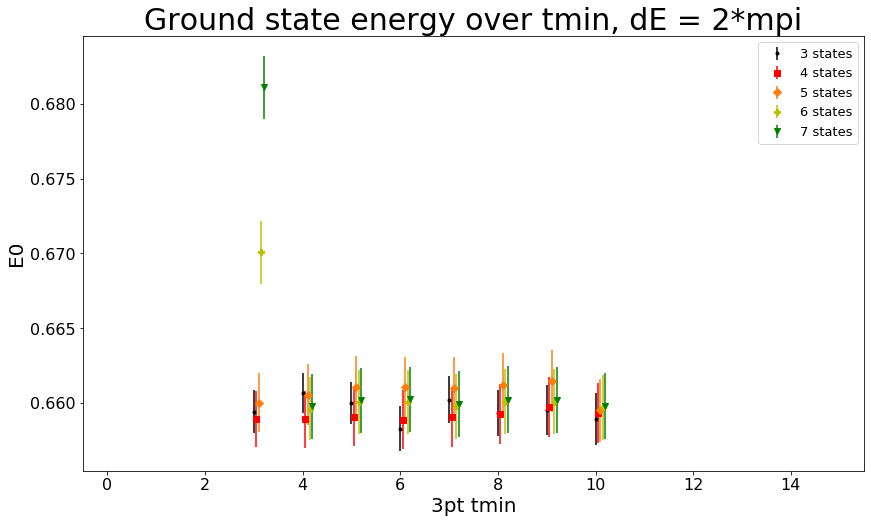

<Figure size 432x288 with 0 Axes>

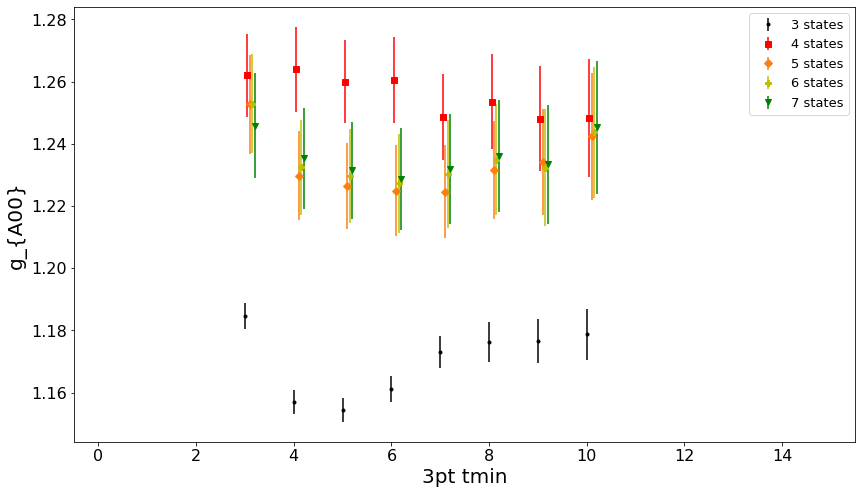

<Figure size 432x288 with 0 Axes>

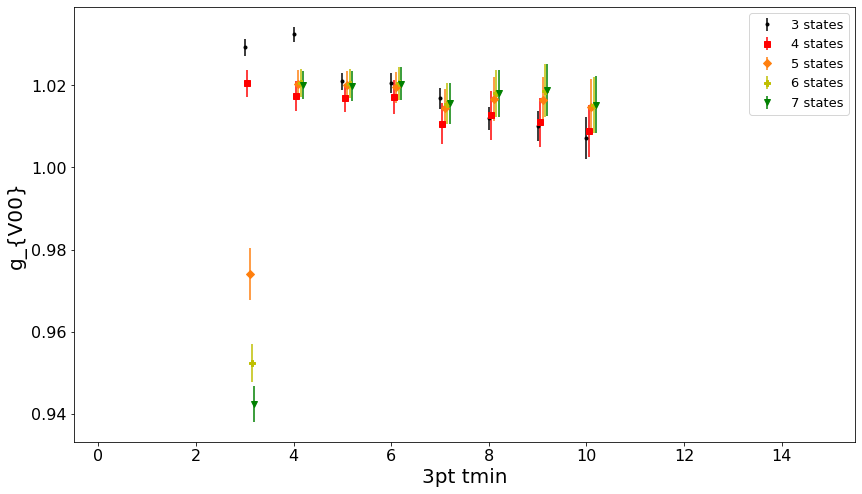

<Figure size 432x288 with 0 Axes>

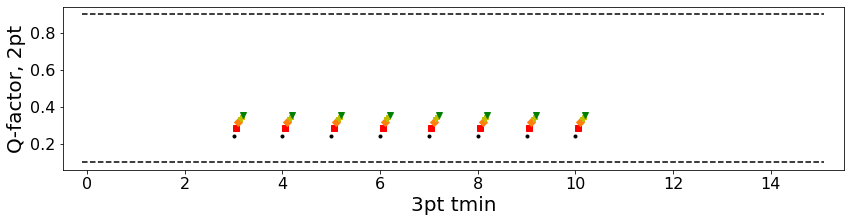

<Figure size 432x288 with 0 Axes>

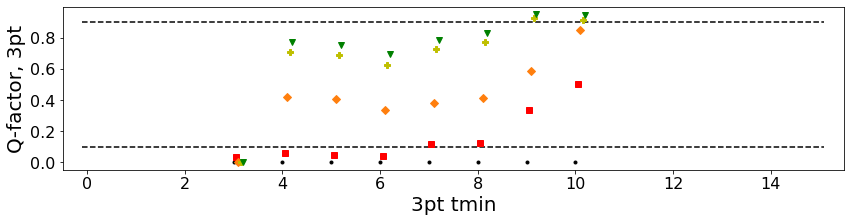

<Figure size 432x288 with 0 Axes>

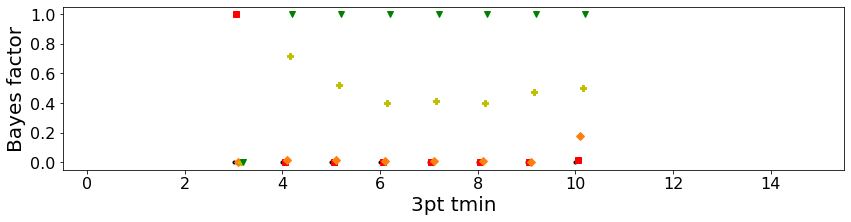

<Figure size 432x288 with 0 Axes>

In [134]:
# First, define colors, markers, and legend labels to be used for each number of states
ax_markers = np.array(['.', 's', 'D', 'P', 'v', 'h', 'X', '^', '*', 'p', 'd'])
ax_colors = np.array(['k', 'r', 'tab:orange', 'y', 'g', 'b', 'tab:purple', 'c', 'm', 'tab:grey', 'tab:brown'])
ax_labels = np.array(["3 states", "4 states", "5 states", "6 states", "7 states"])


# Now create an "upper bound" and "lower bound" plot on Q
samp_line = np.linspace(-0.1,15.1,500)
Q_01_line = np.linspace(0.1,0.1,500)
Q_09_line = np.linspace(0.9,0.9,500)

# Next, create the figure
#E0
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

# Now loop over the number of states used in 3-point
for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_E0_a0_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_E0_a0_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.title("Ground state energy over tmin, dE = 2*mpi", fontsize=30)
plt.ylabel("E0", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=13)
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_gA00_a0_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_gA00_a0_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.legend(fontsize=13)
plt.ylabel("g_{A00}", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_gV00_a0_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_gV00_a0_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.legend(fontsize=13)
plt.ylabel("g_{V00}", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_Q_2pt_a0_tmin_read[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
   
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
#plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_Q_3pt_a0_tmin_read[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
#plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [BF_a0_tmin[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
#plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

#Bayes
#plt.figure(figsize = (14,2))
#plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
#plt.xlabel("tau cut, log(dE1) width")

#for j in range(len(numstates_range)):
    #plt.semilogy(ax_ensemble_to_x_map + k*0.03, [BF_a0_graph[i][k] for i in range(len(ax_ensemble_to_x_map))], '.', marker = ax_markers[k], color = ax_colors[k], label = ax_labels[k])

    
#plt.legend(loc = 'upper right')
#plt.ylabel("Bayes factor")
#plt.xticks(fontsize=16)
#plt.yticks(fontsize=16)
#plt.show()

#plt.clf()

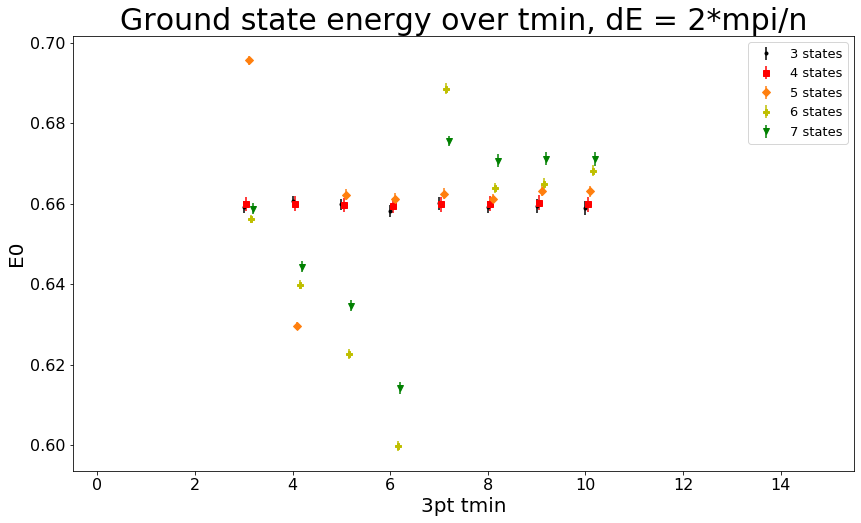

<Figure size 432x288 with 0 Axes>

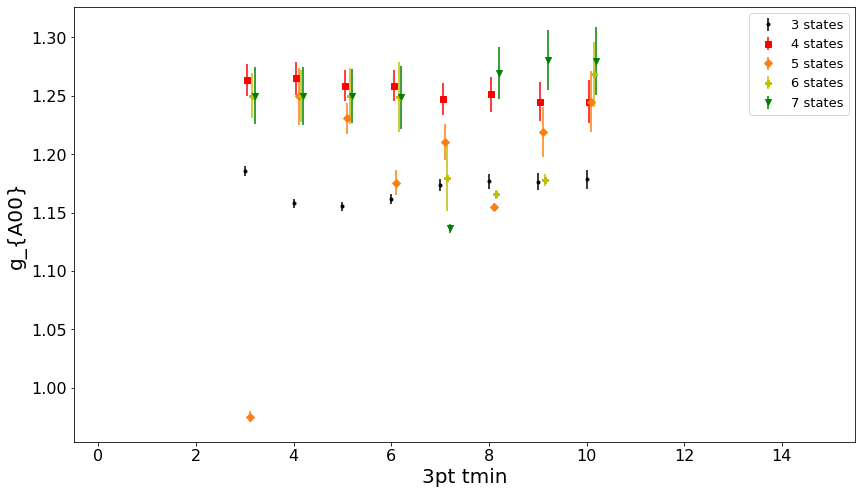

<Figure size 432x288 with 0 Axes>

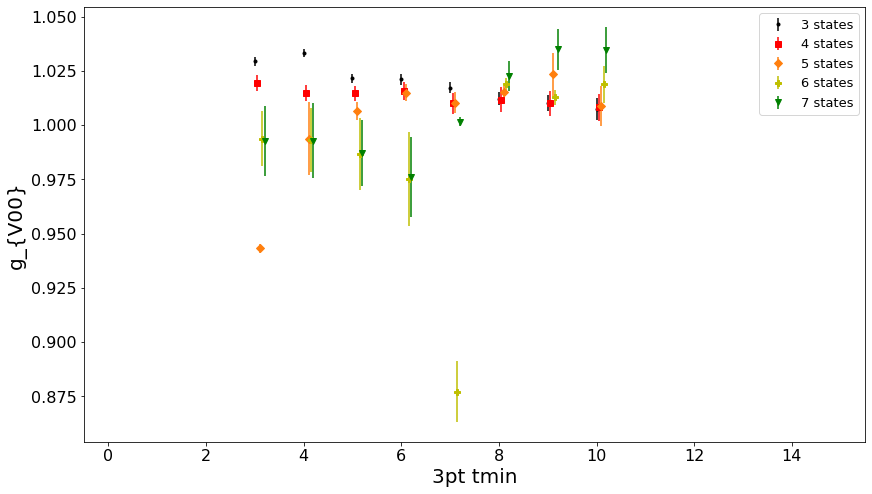

<Figure size 432x288 with 0 Axes>

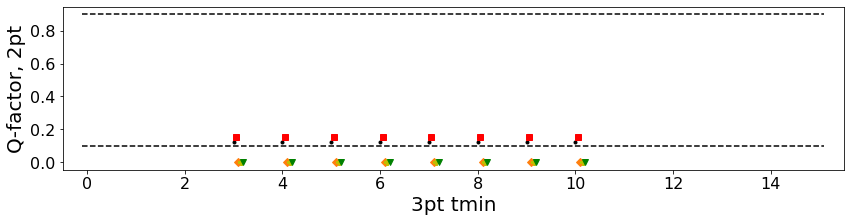

<Figure size 432x288 with 0 Axes>

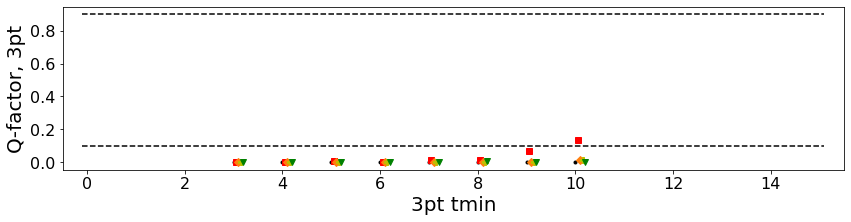

<Figure size 432x288 with 0 Axes>

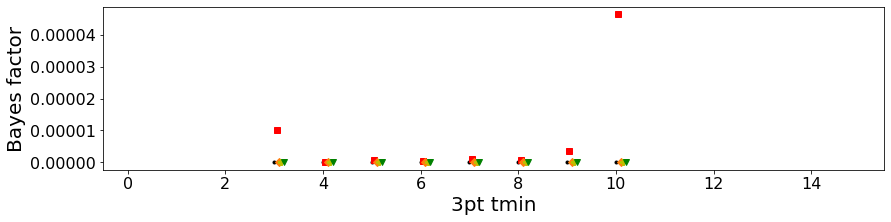

<Figure size 432x288 with 0 Axes>

In [135]:
# Next, create the figure
#E0
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

# Now loop over the number of states used in 3-point
for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_E0_a1_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_E0_a1_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n", fontsize=30)
plt.ylabel("E0", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=13)
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_gA00_a1_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_gA00_a1_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.legend(fontsize=13)
plt.ylabel("g_{A00}", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_gV00_a1_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_gV00_a1_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.legend(fontsize=13)
plt.ylabel("g_{V00}", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_Q_2pt_a1_tmin_read[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
   
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
#plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_Q_3pt_a1_tmin_read[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
#plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [BF_a1_tmin[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
#plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

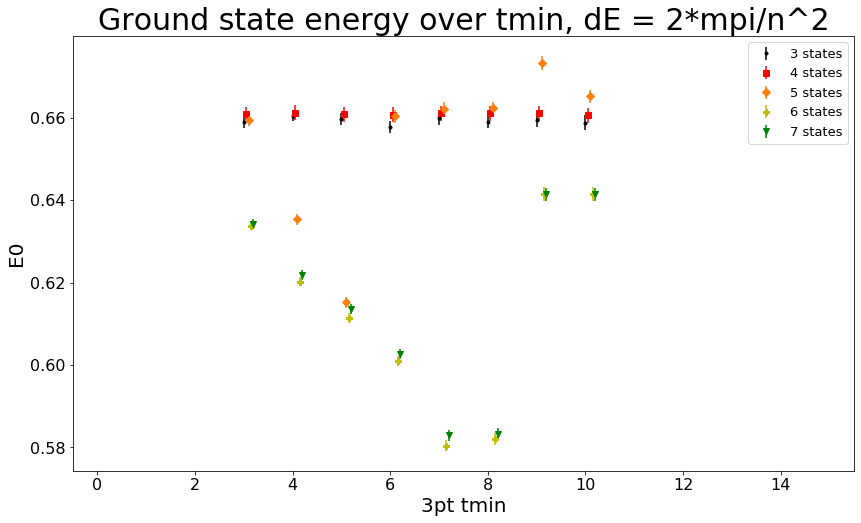

<Figure size 432x288 with 0 Axes>

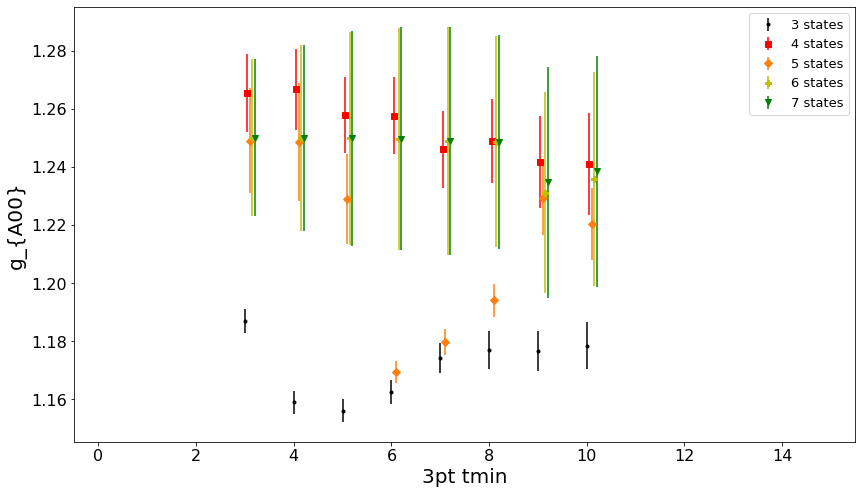

<Figure size 432x288 with 0 Axes>

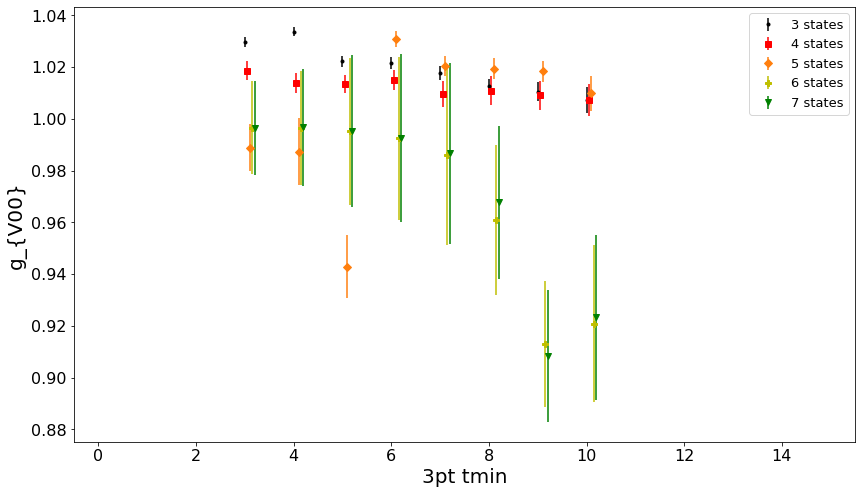

<Figure size 432x288 with 0 Axes>

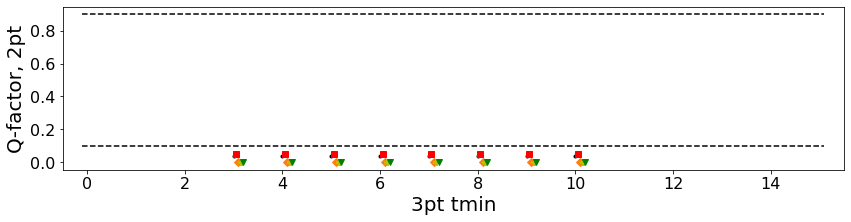

<Figure size 432x288 with 0 Axes>

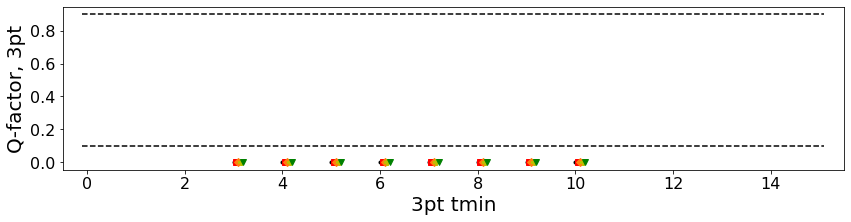

<Figure size 432x288 with 0 Axes>

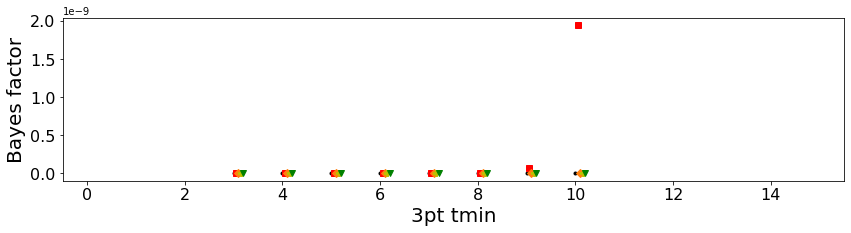

<Figure size 432x288 with 0 Axes>

In [136]:
# Next, create the figure
#E0
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

# Now loop over the number of states used in 3-point
for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_E0_a2_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_E0_a2_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.title("Ground state energy over tmin, dE = 2*mpi/n^2", fontsize=30)
plt.ylabel("E0", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=13)
plt.show()

plt.clf()

# Next, create the figure
#gA00
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_gA00_a2_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_gA00_a2_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.legend(fontsize=13)
plt.ylabel("g_{A00}", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#gV00
plt.figure(figsize = (14,8))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_gV00_a2_tmin_read[i][j].mean for i in range(len(tmin_range))], yerr = [list_gV00_a2_tmin_read[i][j].sdev for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
plt.legend(fontsize=13)
plt.ylabel("g_{V00}", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#Q-factor
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_Q_2pt_a2_tmin_read[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
   
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
#plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 2pt", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

#Q-factor
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [list_Q_3pt_a2_tmin_read[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
plt.plot(samp_line, Q_01_line, "k--")
plt.plot(samp_line, Q_09_line, "k--")
    
#plt.legend(loc = 'upper right')
plt.ylabel("Q-factor, 3pt", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()

# Next, create the figure
#Bayes
plt.figure(figsize = (14,3))
plt.xlim([-0.5, 15.5])
#plt.xticks(ticks = xticlocs, labels=xticklabels)
plt.xlabel("3pt tmin", fontsize=20)

for j in range(len(numstates_range)):
    plt.errorbar(tmin_range + j*0.05, [BF_a2_tmin[i][j] for i in range(len(tmin_range))], fmt='.', marker = ax_markers[j], color = ax_colors[j], label = ax_labels[j])
    
#plt.legend(loc = 'upper right')
plt.ylabel("Bayes factor", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

plt.clf()